In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [11]:
#Expects timeseries.py in same folder as nb. 
from fastai.vision import *
from pathlib import Path
import pdb
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import log_loss

import fastai.callbacks.hooks

In [4]:
path = Path("")

In [6]:
class JSONImageItemList(ImageItemList):
    def get(self, i):
        img = self.items[i]
        angle = img["inc_angle"]
        a,b = torch.tensor(img["band_1"]), torch.tensor(img["band_2"])
        a = a / a.min()
        b = b / b.min()
        img = torch.stack([a,b,(a+b)/2],dim=0).view(3,75,75)
        return Image(img)
        
    
    @classmethod
    def from_json(cls,js,**kwargs):
        return cls(js,**kwargs)

In [28]:
class ParallelAlex(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.hero = create_body(models.alexnet,pretrained=True)
        self.parallel = create_body(models.alexnet,pretrained=False)
        self.classifier = create_head(512 * 2,num_classes)
        
    def forward(self, x):
        x = torch.cat([self.hero(x),self.parallel(x)],dim=1)
        return self.classifier(x)

In [5]:
class SidekickAlexNet(nn.Module):
    def __init__(self, num_classes=1000,width=8,pretrained=True):
        super().__init__()
        
        self.hero = create_body(models.alexnet,pretrained=pretrained)
        ml = [f for i,f in enumerate(next(self.hero.children()).children()) if i in [2,5,7,9,12]]
        self.hooks = fastai.callbacks.Hooks(ml,lambda m,i,o: o,detach=False)
        
        self.features = nn.ModuleList(
            [nn.Sequential(nn.Conv2d(3, 8*width, kernel_size=11, stride=4, padding=2),nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=3, stride=2)),
            nn.Sequential(nn.Conv2d(8*width + 64, 24 * width, kernel_size=5, padding=2),nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=3, stride=2)),
            nn.Sequential(nn.Conv2d(24*width + 192, 48 * width, kernel_size=3, padding=1),nn.ReLU(inplace=True)),
            nn.Sequential(nn.Conv2d(48*width + 384, 32 * width, kernel_size=3, padding=1),nn.ReLU(inplace=True)),
            nn.Sequential(nn.Conv2d(32*width + 256, 32 * width, kernel_size=3, padding=1),nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=3, stride=2))])
        
        self.classifier = create_head((32*width + 256)*2,num_classes)

    def forward(self, x):
        bs = x.shape[0]
        pt = self.hero(x)
        
        x = self.features[0](x)
        for f, a in zip(self.features[1:],self.hooks.stored):
            x = f(torch.cat([x,a],dim=1))
            
        x = torch.cat([x,pt],dim=1)    
        x = self.classifier(x)
        return x

In [8]:
def logloss(preds,target):
    preds = torch.softmax(preds,dim=1)
    preds = preds.cpu().detach().numpy()
    target = target.cpu().detach().numpy()
    return torch.tensor(log_loss(target,preds))

In [7]:
jsIn = json.load((path/"train.json").open())

In [29]:
def getData():
    src = (JSONImageItemList.from_json(jsIn)
           .random_split_by_pct(0.2)
           .label_from_func(lambda item: item["is_iceberg"] == 1))
    
    tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
    return src.transform(tfms,size=75).databunch(bs=16,num_workers=0).normalize(imagenet_stats)

def doRun():
    out = []
    data = getData()    
    learn = create_cnn(data,models.alexnet,metrics=[accuracy,logloss])
    learn.freeze()
    learn.fit_one_cycle(10,1e-3)
    learn.unfreeze()
    learn.fit_one_cycle(20,1e-5)
    out.append(max([m[0].item() for m in learn.recorder.metrics]))
    out.append(max([m[1].item() for m in learn.recorder.metrics]))
    
    learnSK = Learner(data,ParallelAlex(data.train_ds.c),metrics=[accuracy,logloss])
    learnSK.split([learnSK.model.hero,learnSK.model.parallel,learnSK.model.classifier])
    learnSK.freeze_to(1)
    learnSK.fit_one_cycle(20,1e-3)
    learnSK.fit_one_cycle(10,1e-4)
    out.append(max([m[0].item() for m in learnSK.recorder.metrics]))
    out.append(max([m[1].item() for m in learnSK.recorder.metrics]))
    
    learnSK = Learner(data,SidekickAlexNet(data.train_ds.c,width=8),metrics=[accuracy,logloss])
    learnSK.split([learnSK.model.hero,learnSK.model.features[0],learnSK.model.classifier])
    learnSK.freeze_to(1)
    learnSK.fit_one_cycle(20,1e-3)
    learnSK.fit_one_cycle(10,1e-4)
    out.append(max([m[0].item() for m in learnSK.recorder.metrics]))
    out.append(max([m[1].item() for m in learnSK.recorder.metrics]))
    
    return out

In [30]:
results = [doRun() for _ in progress_bar(range(80))]

epoch,train_loss,valid_loss,accuracy,logloss
1,0.766522,0.542125,0.709375,0.542125
2,0.625688,0.458645,0.756250,0.458645
3,0.543660,0.495358,0.775000,0.495358
4,0.508399,0.429022,0.765625,0.429022
5,0.479077,0.477050,0.775000,0.477050
6,0.469714,0.408842,0.803125,0.408842
7,0.436294,0.432891,0.796875,0.432891
8,0.443268,0.402330,0.787500,0.402330
9,0.460040,0.450983,0.781250,0.450983
10,0.414189,0.412496,0.790625,0.412496


epoch,train_loss,valid_loss,accuracy,logloss
1,0.439303,0.404824,0.790625,0.404824
2,0.451025,0.395404,0.784375,0.395404
3,0.421055,0.403161,0.781250,0.403161
4,0.404764,0.389194,0.790625,0.389194
5,0.405621,0.410833,0.796875,0.410833
6,0.423082,0.396629,0.784375,0.396629
7,0.418055,0.461679,0.778125,0.461679
8,0.401619,0.383613,0.803125,0.383613
9,0.440067,0.388501,0.790625,0.388501
10,0.399374,0.370817,0.818750,0.370817


epoch,train_loss,valid_loss,accuracy,logloss
1,0.569346,0.548746,0.650000,0.548746
2,0.453763,0.582195,0.662500,0.582195
3,0.458977,0.480950,0.756250,0.480950
4,0.455662,0.649641,0.606250,0.649641
5,0.432379,0.396431,0.778125,0.396431
6,0.437334,0.403349,0.796875,0.403349
7,0.449259,0.678616,0.612500,0.678616
8,0.423258,0.423151,0.796875,0.423151
9,0.406664,0.359173,0.806250,0.359173
10,0.384871,0.614703,0.634375,0.614703


epoch,train_loss,valid_loss,accuracy,logloss
1,0.298618,0.271615,0.875000,0.271615
2,0.297114,0.291202,0.865625,0.291202
3,0.323205,0.312531,0.868750,0.312531
4,0.292281,0.270464,0.871875,0.270464
5,0.285131,0.261871,0.871875,0.261871
6,0.283481,0.268253,0.871875,0.268253
7,0.276994,0.278449,0.875000,0.278449
8,0.277394,0.264845,0.875000,0.264845
9,0.270519,0.267749,0.871875,0.267749
10,0.261616,0.283934,0.868750,0.283934


epoch,train_loss,valid_loss,accuracy,logloss
1,0.484569,0.433804,0.793750,0.433804
2,0.430737,0.348840,0.809375,0.348840
3,0.401662,0.344119,0.809375,0.344119
4,0.402709,0.923636,0.606250,0.923636
5,0.397621,0.347114,0.821875,0.347114
6,0.394126,0.319888,0.846875,0.319888
7,0.377179,0.330642,0.837500,0.330642
8,0.360821,0.320734,0.862500,0.320734
9,0.347560,0.298511,0.853125,0.298511
10,0.352101,0.323731,0.828125,0.323731


epoch,train_loss,valid_loss,accuracy,logloss
1,0.256743,0.260736,0.884375,0.260736
2,0.264481,0.261820,0.887500,0.261820
3,0.249261,0.258414,0.887500,0.258414
4,0.274577,0.258093,0.871875,0.258093
5,0.261201,0.252015,0.884375,0.252015
6,0.270135,0.268546,0.881250,0.268546
7,0.261087,0.256691,0.890625,0.256691
8,0.272713,0.253527,0.890625,0.253527
9,0.249633,0.251890,0.884375,0.251890
10,0.282899,0.247957,0.900000,0.247957


epoch,train_loss,valid_loss,accuracy,logloss
1,0.743311,0.547190,0.693750,0.547190
2,0.620497,0.487975,0.750000,0.487975
3,0.529723,0.448447,0.778125,0.448447
4,0.513621,0.434614,0.778125,0.434614
5,0.479688,0.417190,0.793750,0.417190
6,0.456184,0.411355,0.800000,0.411355
7,0.449377,0.410746,0.800000,0.410746
8,0.448186,0.432900,0.793750,0.432900
9,0.458178,0.406984,0.800000,0.406984
10,0.458533,0.398672,0.793750,0.398672


epoch,train_loss,valid_loss,accuracy,logloss
1,0.442628,0.404452,0.793750,0.404452
2,0.453935,0.409848,0.796875,0.409848
3,0.423913,0.418433,0.793750,0.418433
4,0.420774,0.395862,0.787500,0.395862
5,0.438585,0.387502,0.781250,0.387502
6,0.433662,0.384650,0.781250,0.384650
7,0.401631,0.391181,0.781250,0.391181
8,0.396644,0.388680,0.790625,0.388680
9,0.410879,0.372290,0.784375,0.372290
10,0.379525,0.373091,0.784375,0.373091


epoch,train_loss,valid_loss,accuracy,logloss
1,0.573821,0.489307,0.806250,0.489307
2,0.495954,0.415588,0.762500,0.415588
3,0.447478,0.882201,0.606250,0.882201
4,0.419671,0.774504,0.628125,0.774503
5,0.432021,0.630390,0.662500,0.630390
6,0.413461,0.444913,0.762500,0.444913
7,0.411724,0.394468,0.831250,0.394468
8,0.414473,0.436460,0.787500,0.436460
9,0.411634,0.420669,0.781250,0.420669
10,0.420255,0.446979,0.775000,0.446979


epoch,train_loss,valid_loss,accuracy,logloss
1,0.355787,0.379921,0.809375,0.379921
2,0.375586,0.361185,0.812500,0.361185
3,0.353747,0.354290,0.828125,0.354290
4,0.365618,0.344085,0.828125,0.344086
5,0.380497,0.348447,0.831250,0.348447
6,0.343910,0.342495,0.831250,0.342495
7,0.341924,0.341532,0.843750,0.341532
8,0.342349,0.339727,0.821875,0.339727
9,0.317479,0.325949,0.821875,0.325949
10,0.332014,0.343461,0.840625,0.343461


epoch,train_loss,valid_loss,accuracy,logloss
1,0.491528,0.379063,0.828125,0.379063
2,0.408743,0.341645,0.840625,0.341645
3,0.408983,1.386003,0.500000,1.386003
4,0.408514,0.788632,0.615625,0.788632
5,0.357569,0.359096,0.834375,0.359096
6,0.362080,0.473999,0.740625,0.473999
7,0.350241,0.406469,0.781250,0.406469
8,0.351564,0.304589,0.853125,0.304589
9,0.316599,0.404228,0.800000,0.404228
10,0.311650,0.275542,0.875000,0.275542


epoch,train_loss,valid_loss,accuracy,logloss
1,0.277376,0.261163,0.875000,0.261163
2,0.251481,0.267154,0.871875,0.267154
3,0.257735,0.272679,0.881250,0.272680
4,0.247552,0.259949,0.878125,0.259949
5,0.233991,0.263993,0.881250,0.263993
6,0.232441,0.267362,0.878125,0.267362
7,0.237795,0.260682,0.875000,0.260682
8,0.264156,0.255902,0.878125,0.255902
9,0.224040,0.254455,0.875000,0.254455
10,0.234637,0.255352,0.871875,0.255352


epoch,train_loss,valid_loss,accuracy,logloss
1,0.767431,0.528211,0.725000,0.528211
2,0.636685,0.447809,0.781250,0.447809
3,0.538987,0.472831,0.765625,0.472831
4,0.528680,0.390405,0.790625,0.390405
5,0.468413,0.436412,0.787500,0.436412
6,0.472703,0.394681,0.800000,0.394681
7,0.457515,0.385862,0.800000,0.385862
8,0.443558,0.384444,0.818750,0.384444
9,0.414687,0.384145,0.806250,0.384145
10,0.411646,0.382919,0.812500,0.382919


epoch,train_loss,valid_loss,accuracy,logloss
1,0.420143,0.377033,0.821875,0.377033
2,0.424304,0.371702,0.812500,0.371702
3,0.423102,0.387061,0.793750,0.387061
4,0.406157,0.386515,0.784375,0.386515
5,0.421623,0.385936,0.809375,0.385936
6,0.421178,0.376886,0.815625,0.376886
7,0.390780,0.356221,0.825000,0.356221
8,0.387292,0.371470,0.803125,0.371470
9,0.386910,0.367486,0.796875,0.367486
10,0.373141,0.358196,0.809375,0.358196


epoch,train_loss,valid_loss,accuracy,logloss
1,0.549093,0.544868,0.659375,0.544868
2,0.472875,1.107685,0.568750,1.107686
3,0.448772,0.444970,0.756250,0.444970
4,0.436215,0.424265,0.768750,0.424265
5,0.427566,0.793398,0.621875,0.793398
6,0.401534,0.435514,0.775000,0.435514
7,0.413975,0.491315,0.712500,0.491315
8,0.416994,1.335771,0.590625,1.335771
9,0.412834,0.477051,0.759375,0.477051
10,0.378669,0.584815,0.718750,0.584815


epoch,train_loss,valid_loss,accuracy,logloss
1,0.286599,0.304941,0.875000,0.304941
2,0.273945,0.304991,0.865625,0.304991
3,0.294194,0.306127,0.865625,0.306127
4,0.294125,0.295573,0.878125,0.295573
5,0.271593,0.304295,0.868750,0.304295
6,0.282667,0.288212,0.887500,0.288212
7,0.284113,0.289596,0.881250,0.289596
8,0.281981,0.286644,0.875000,0.286644
9,0.286313,0.288227,0.878125,0.288227
10,0.284698,0.281598,0.871875,0.281598


epoch,train_loss,valid_loss,accuracy,logloss
1,0.505375,0.405807,0.803125,0.405807
2,0.413106,0.422816,0.796875,0.422816
3,0.394700,0.716367,0.718750,0.716367
4,0.389134,0.579368,0.781250,0.579368
5,0.394381,0.461014,0.743750,0.461014
6,0.392051,0.687237,0.646875,0.687237
7,0.376685,0.338908,0.856250,0.338908
8,0.353267,0.759393,0.625000,0.759393
9,0.353201,0.618981,0.737500,0.618981
10,0.356415,0.379563,0.806250,0.379563


epoch,train_loss,valid_loss,accuracy,logloss
1,0.288544,0.268399,0.871875,0.268399
2,0.285984,0.264019,0.881250,0.264019
3,0.278521,0.271772,0.881250,0.271772
4,0.300519,0.273948,0.862500,0.273948
5,0.265032,0.286783,0.856250,0.286783
6,0.276253,0.266254,0.878125,0.266254
7,0.263427,0.255901,0.881250,0.255901
8,0.247645,0.259315,0.884375,0.259315
9,0.269391,0.257319,0.887500,0.257319
10,0.283349,0.258292,0.881250,0.258292


epoch,train_loss,valid_loss,accuracy,logloss
1,0.822963,0.621146,0.700000,0.621146
2,0.652967,0.577150,0.703125,0.577150
3,0.566338,0.489606,0.762500,0.489606
4,0.516894,0.537489,0.737500,0.537489
5,0.525165,0.484614,0.753125,0.484614
6,0.466767,0.517622,0.775000,0.517622
7,0.442760,0.466792,0.787500,0.466792
8,0.450569,0.443211,0.800000,0.443211
9,0.437097,0.468273,0.806250,0.468273
10,0.440045,0.495370,0.781250,0.495370


epoch,train_loss,valid_loss,accuracy,logloss
1,0.427733,0.460052,0.803125,0.460052
2,0.448394,0.533781,0.762500,0.533781
3,0.427898,0.442687,0.812500,0.442687
4,0.419774,0.434039,0.775000,0.434039
5,0.396162,0.551988,0.775000,0.551988
6,0.436359,0.429839,0.756250,0.429839
7,0.433413,0.438215,0.781250,0.438215
8,0.424765,0.392773,0.793750,0.392773
9,0.390944,0.389788,0.806250,0.389788
10,0.402199,0.406722,0.796875,0.406722


epoch,train_loss,valid_loss,accuracy,logloss
1,0.556371,0.488759,0.775000,0.488759
2,0.477893,0.408226,0.778125,0.408226
3,0.465861,0.467337,0.753125,0.467337
4,0.447452,0.497449,0.762500,0.497449
5,0.434762,0.766451,0.600000,0.766451
6,0.437290,0.389305,0.825000,0.389305
7,0.427485,0.419129,0.809375,0.419129
8,0.411330,0.418855,0.796875,0.418855
9,0.406102,1.183539,0.537500,1.183539
10,0.410388,0.607473,0.693750,0.607473


epoch,train_loss,valid_loss,accuracy,logloss
1,0.292591,0.335322,0.837500,0.335321
2,0.297218,0.322641,0.859375,0.322641
3,0.311127,0.357131,0.834375,0.357131
4,0.319517,0.373014,0.840625,0.373014
5,0.302123,0.358900,0.834375,0.358900
6,0.284858,0.349524,0.834375,0.349524
7,0.279562,0.319423,0.871875,0.319423
8,0.272368,0.321134,0.846875,0.321134
9,0.281216,0.310674,0.875000,0.310674
10,0.291480,0.329724,0.843750,0.329724


epoch,train_loss,valid_loss,accuracy,logloss
1,0.481115,0.370673,0.828125,0.370673
2,0.408363,0.340504,0.815625,0.340504
3,0.397625,0.486006,0.750000,0.486006
4,0.421550,2.232616,0.565625,2.232616
5,0.396776,0.360311,0.828125,0.360311
6,0.387575,0.375935,0.818750,0.375935
7,0.363770,0.348558,0.821875,0.348558
8,0.375936,0.346592,0.837500,0.346592
9,0.363991,0.358534,0.818750,0.358534
10,0.345750,0.319003,0.853125,0.319003


epoch,train_loss,valid_loss,accuracy,logloss
1,0.249457,0.340674,0.871875,0.340674
2,0.268199,0.341099,0.859375,0.341099
3,0.277939,0.295608,0.884375,0.295608
4,0.275898,0.324098,0.859375,0.324098
5,0.249066,0.433592,0.884375,0.432809
6,0.269537,0.388460,0.884375,0.388460
7,0.258415,0.424991,0.878125,0.417902
8,0.281705,0.318384,0.868750,0.318384
9,0.258929,0.352956,0.871875,0.352956
10,0.250877,0.359143,0.875000,0.359143


epoch,train_loss,valid_loss,accuracy,logloss
1,0.761659,0.603022,0.675000,0.603022
2,0.596505,0.558645,0.737500,0.558645
3,0.527988,0.502505,0.768750,0.502505
4,0.513815,0.585941,0.712500,0.585941
5,0.471692,0.443722,0.750000,0.443722
6,0.480744,0.487105,0.746875,0.487105
7,0.472933,0.451102,0.800000,0.451102
8,0.444050,0.440671,0.787500,0.440671
9,0.457984,0.454713,0.793750,0.454713
10,0.421201,0.450503,0.790625,0.450503


epoch,train_loss,valid_loss,accuracy,logloss
1,0.432594,0.514221,0.803125,0.514221
2,0.429005,0.444230,0.796875,0.444230
3,0.432193,0.415148,0.806250,0.415148
4,0.453802,0.425711,0.803125,0.425711
5,0.436259,0.408471,0.812500,0.408471
6,0.417145,0.411445,0.818750,0.411445
7,0.410286,0.408920,0.781250,0.408920
8,0.408623,0.398129,0.800000,0.398129
9,0.423846,0.383950,0.803125,0.383950
10,0.389902,0.420792,0.800000,0.420792


epoch,train_loss,valid_loss,accuracy,logloss
1,0.566084,0.508832,0.740625,0.508832
2,0.495660,0.402305,0.806250,0.402305
3,0.473183,0.646959,0.615625,0.646959
4,0.468648,0.417437,0.796875,0.417436
5,0.458163,0.428684,0.796875,0.428684
6,0.427192,0.408965,0.803125,0.408965
7,0.415065,0.640479,0.631250,0.640478
8,0.406327,0.396191,0.787500,0.396191
9,0.421826,0.379453,0.800000,0.379453
10,0.396081,0.595425,0.675000,0.595425


epoch,train_loss,valid_loss,accuracy,logloss
1,0.301109,0.290006,0.868750,0.290006
2,0.302043,0.296231,0.856250,0.296231
3,0.316757,0.253563,0.896875,0.253563
4,0.308527,0.292134,0.856250,0.292134
5,0.295649,0.281178,0.881250,0.281178
6,0.289679,0.282858,0.865625,0.282858
7,0.306793,0.263702,0.881250,0.263702
8,0.298514,0.259953,0.890625,0.259953
9,0.298884,0.240738,0.906250,0.240738
10,0.296779,0.244488,0.893750,0.244488


epoch,train_loss,valid_loss,accuracy,logloss
1,0.525207,0.412335,0.806250,0.412335
2,0.442569,0.378915,0.809375,0.378915
3,0.420829,0.458049,0.775000,0.458049
4,0.393140,0.747956,0.587500,0.747956
5,0.381934,0.775130,0.725000,0.775130
6,0.381896,0.726003,0.625000,0.726003
7,0.364586,0.578058,0.718750,0.578058
8,0.352409,0.618573,0.687500,0.618573
9,0.344997,0.285347,0.871875,0.285347
10,0.338909,0.325513,0.856250,0.325513


epoch,train_loss,valid_loss,accuracy,logloss
1,0.273739,0.257842,0.903125,0.257842
2,0.275815,0.258101,0.896875,0.258101
3,0.276376,0.264513,0.896875,0.264513
4,0.280807,0.253734,0.896875,0.253734
5,0.270705,0.255590,0.887500,0.255590
6,0.250926,0.259891,0.893750,0.259891
7,0.262455,0.250873,0.900000,0.250873
8,0.252345,0.256110,0.896875,0.256110
9,0.268721,0.245419,0.906250,0.245419
10,0.252202,0.243840,0.903125,0.243840


epoch,train_loss,valid_loss,accuracy,logloss
1,0.776670,0.509260,0.737500,0.509260
2,0.650036,0.437100,0.790625,0.437100
3,0.564537,0.470115,0.809375,0.470115
4,0.510368,0.417844,0.818750,0.417844
5,0.501331,0.499589,0.796875,0.499589
6,0.471141,0.422587,0.815625,0.422587
7,0.446316,0.424214,0.840625,0.424214
8,0.456566,0.442091,0.846875,0.442091
9,0.448705,0.451194,0.828125,0.451194
10,0.460603,0.462865,0.856250,0.462865


epoch,train_loss,valid_loss,accuracy,logloss
1,0.435002,0.423362,0.840625,0.423362
2,0.432488,0.396823,0.840625,0.396823
3,0.440302,0.392424,0.840625,0.392424
4,0.423750,0.378175,0.837500,0.378175
5,0.419971,0.369185,0.846875,0.369185
6,0.438617,0.427398,0.831250,0.427398
7,0.407588,0.384801,0.834375,0.384801
8,0.397805,0.361228,0.837500,0.361228
9,0.388499,0.360266,0.840625,0.360266
10,0.400688,0.357751,0.843750,0.357751


epoch,train_loss,valid_loss,accuracy,logloss
1,0.576262,0.497042,0.696875,0.497042
2,0.494601,0.586808,0.709375,0.586808
3,0.458365,0.937468,0.562500,0.937468
4,0.469554,0.433587,0.762500,0.433587
5,0.440377,0.387495,0.818750,0.387495
6,0.430325,0.513499,0.721875,0.513499
7,0.453011,0.539266,0.746875,0.539266
8,0.447194,0.368879,0.831250,0.368879
9,0.418090,0.359403,0.846875,0.359403
10,0.444765,0.385563,0.828125,0.385563


epoch,train_loss,valid_loss,accuracy,logloss
1,0.319769,0.277129,0.887500,0.277129
2,0.323417,0.298273,0.878125,0.298273
3,0.321363,0.307294,0.884375,0.307294
4,0.340952,0.270007,0.884375,0.270007
5,0.339155,0.283624,0.868750,0.283624
6,0.329118,0.305472,0.881250,0.305472
7,0.369562,0.357788,0.887500,0.357788
8,0.334432,0.304991,0.881250,0.304991
9,0.328134,0.293306,0.887500,0.293306
10,0.310392,0.302855,0.903125,0.302855


epoch,train_loss,valid_loss,accuracy,logloss
1,0.506968,0.349285,0.850000,0.349285
2,0.429467,0.389136,0.828125,0.389136
3,0.408652,0.827189,0.634375,0.827189
4,0.384926,0.370719,0.821875,0.370719
5,0.392524,0.604057,0.696875,0.604057
6,0.380867,0.317504,0.862500,0.317504
7,0.386045,0.386581,0.837500,0.386581
8,0.359897,0.284638,0.875000,0.284638
9,0.360427,0.304407,0.856250,0.304407
10,0.345770,0.312163,0.868750,0.312163


epoch,train_loss,valid_loss,accuracy,logloss
1,0.288082,0.290683,0.875000,0.290683
2,0.265802,0.290146,0.871875,0.290146
3,0.285457,0.280041,0.878125,0.280041
4,0.281896,0.287053,0.868750,0.287053
5,0.272880,0.280850,0.878125,0.280850
6,0.255835,0.288589,0.875000,0.288589
7,0.252624,0.286446,0.875000,0.286446
8,0.248844,0.290312,0.868750,0.290312
9,0.259707,0.290160,0.868750,0.290160
10,0.262950,0.284829,0.868750,0.284829


epoch,train_loss,valid_loss,accuracy,logloss
1,0.762379,0.516235,0.768750,0.516235
2,0.607426,0.437902,0.768750,0.437902
3,0.535344,0.427809,0.762500,0.427809
4,0.520036,0.423903,0.765625,0.423903
5,0.489990,0.461221,0.775000,0.461221
6,0.480055,0.438267,0.775000,0.438267
7,0.466926,0.454742,0.756250,0.454742
8,0.431636,0.356865,0.831250,0.356865
9,0.427138,0.384491,0.803125,0.384491
10,0.451127,0.410653,0.803125,0.410653


epoch,train_loss,valid_loss,accuracy,logloss
1,0.436122,0.388155,0.800000,0.388155
2,0.439482,0.376862,0.806250,0.376862
3,0.442097,0.380500,0.812500,0.380500
4,0.423711,0.398065,0.803125,0.398065
5,0.403700,0.391185,0.790625,0.391185
6,0.410811,0.389859,0.803125,0.389859
7,0.412223,0.416013,0.787500,0.416013
8,0.393174,0.347291,0.843750,0.347291
9,0.379120,0.351956,0.840625,0.351956
10,0.381527,0.343743,0.853125,0.343743


epoch,train_loss,valid_loss,accuracy,logloss
1,0.546983,0.500795,0.737500,0.500795
2,0.479662,0.425668,0.784375,0.425668
3,0.454255,1.250193,0.675000,1.250193
4,0.458868,0.536062,0.681250,0.536062
5,0.433889,0.394049,0.803125,0.394049
6,0.452404,0.479948,0.731250,0.479948
7,0.411896,0.696087,0.750000,0.696087
8,0.409209,0.690655,0.756250,0.690655
9,0.439289,0.414068,0.793750,0.414068
10,0.421403,1.045197,0.565625,1.045197


epoch,train_loss,valid_loss,accuracy,logloss
1,0.303281,0.285580,0.868750,0.285580
2,0.307461,0.301967,0.850000,0.301967
3,0.298980,0.292559,0.859375,0.292559
4,0.327688,0.282366,0.868750,0.282366
5,0.321903,0.257820,0.893750,0.257820
6,0.304199,0.291956,0.871875,0.291956
7,0.292998,0.256948,0.878125,0.256948
8,0.288709,0.269051,0.875000,0.269051
9,0.296546,0.281383,0.881250,0.281383
10,0.288212,0.277763,0.875000,0.277763


epoch,train_loss,valid_loss,accuracy,logloss
1,0.478991,0.398635,0.800000,0.398635
2,0.419457,0.461327,0.746875,0.461327
3,0.411072,0.563363,0.756250,0.563363
4,0.392968,0.320262,0.856250,0.320262
5,0.389210,1.032864,0.559375,1.032864
6,0.397253,0.419284,0.778125,0.419284
7,0.381716,0.447219,0.753125,0.447219
8,0.361422,0.356590,0.828125,0.356590
9,0.372772,0.347751,0.825000,0.347751
10,0.347836,0.300236,0.868750,0.300236


epoch,train_loss,valid_loss,accuracy,logloss
1,0.261812,0.255217,0.900000,0.255217
2,0.276488,0.258120,0.896875,0.258120
3,0.265772,0.262741,0.875000,0.262741
4,0.250164,0.269826,0.875000,0.269826
5,0.271623,0.266016,0.878125,0.266016
6,0.246383,0.257008,0.875000,0.257008
7,0.260968,0.262509,0.887500,0.262509
8,0.267946,0.255969,0.890625,0.255969
9,0.282211,0.251780,0.884375,0.251780
10,0.249993,0.257374,0.878125,0.257374


epoch,train_loss,valid_loss,accuracy,logloss
1,0.763722,0.593263,0.715625,0.593263
2,0.635029,0.425398,0.821875,0.425398
3,0.567799,0.437652,0.806250,0.437652
4,0.509440,0.412860,0.800000,0.412860
5,0.494515,0.358498,0.825000,0.358498
6,0.482989,0.378787,0.834375,0.378787
7,0.480391,0.365772,0.840625,0.365772
8,0.444616,0.359317,0.850000,0.359317
9,0.442600,0.354989,0.840625,0.354989
10,0.440291,0.366366,0.837500,0.366366


epoch,train_loss,valid_loss,accuracy,logloss
1,0.431815,0.364711,0.834375,0.364711
2,0.429630,0.354008,0.834375,0.354008
3,0.442060,0.358900,0.837500,0.358900
4,0.445008,0.354129,0.850000,0.354129
5,0.433593,0.362299,0.825000,0.362299
6,0.416751,0.346073,0.840625,0.346073
7,0.422281,0.361019,0.821875,0.361019
8,0.426028,0.362216,0.837500,0.362216
9,0.428851,0.339403,0.837500,0.339403
10,0.441931,0.330302,0.846875,0.330302


epoch,train_loss,valid_loss,accuracy,logloss
1,0.547686,0.481728,0.750000,0.481728
2,0.477439,0.534009,0.681250,0.534009
3,0.442424,0.400976,0.796875,0.400976
4,0.445440,0.480273,0.712500,0.480273
5,0.442597,0.451227,0.759375,0.451227
6,0.447864,0.390196,0.821875,0.390196
7,0.444940,0.403372,0.787500,0.403372
8,0.436626,0.341158,0.818750,0.341158
9,0.444513,0.417117,0.778125,0.417117
10,0.435173,0.463440,0.737500,0.463440


epoch,train_loss,valid_loss,accuracy,logloss
1,0.313951,0.270780,0.893750,0.270780
2,0.339296,0.286759,0.893750,0.286759
3,0.314795,0.393198,0.828125,0.393198
4,0.312920,0.241101,0.890625,0.241101
5,0.311301,0.264312,0.887500,0.264312
6,0.312267,0.266925,0.887500,0.266925
7,0.325414,0.271800,0.887500,0.271800
8,0.304285,0.263891,0.890625,0.263891
9,0.297766,0.260566,0.887500,0.260566
10,0.306849,0.256340,0.893750,0.256340


epoch,train_loss,valid_loss,accuracy,logloss
1,0.484041,0.422694,0.800000,0.422694
2,0.429981,0.334139,0.875000,0.334139
3,0.430353,1.969839,0.512500,1.969839
4,0.399210,0.449017,0.793750,0.449017
5,0.399770,0.809726,0.596875,0.809726
6,0.394559,0.312603,0.868750,0.312603
7,0.380239,0.861240,0.609375,0.861240
8,0.365757,0.334725,0.840625,0.334725
9,0.365967,0.304911,0.865625,0.304911
10,0.338379,0.314542,0.853125,0.314542


epoch,train_loss,valid_loss,accuracy,logloss
1,0.260965,0.227808,0.912500,0.227807
2,0.270299,0.230788,0.909375,0.230788
3,0.267438,0.231838,0.896875,0.231838
4,0.260930,0.233094,0.906250,0.233094
5,0.261800,0.267995,0.884375,0.267995
6,0.259512,0.237741,0.900000,0.237741
7,0.270237,0.226742,0.903125,0.226742
8,0.255713,0.225198,0.903125,0.225198
9,0.247622,0.224931,0.903125,0.224931
10,0.264421,0.231406,0.906250,0.231406


epoch,train_loss,valid_loss,accuracy,logloss
1,0.796714,0.525302,0.753125,0.525302
2,0.649695,0.424939,0.812500,0.424939
3,0.580806,0.426069,0.809375,0.426069
4,0.531448,0.387674,0.812500,0.387674
5,0.480054,0.375444,0.809375,0.375444
6,0.483201,0.354722,0.840625,0.354722
7,0.486246,0.367015,0.825000,0.367015
8,0.449944,0.357467,0.821875,0.357467
9,0.437108,0.367280,0.821875,0.367280
10,0.445893,0.365736,0.825000,0.365736


epoch,train_loss,valid_loss,accuracy,logloss
1,0.441142,0.361289,0.815625,0.361289
2,0.442606,0.366388,0.828125,0.366388
3,0.440881,0.355102,0.834375,0.355102
4,0.438370,0.359059,0.812500,0.359059
5,0.437448,0.355082,0.834375,0.355082
6,0.425243,0.338237,0.834375,0.338237
7,0.439586,0.336522,0.834375,0.336522
8,0.407310,0.344518,0.834375,0.344518
9,0.410007,0.371058,0.843750,0.371058
10,0.419081,0.368778,0.812500,0.368778


epoch,train_loss,valid_loss,accuracy,logloss
1,0.523208,0.507185,0.665625,0.507185
2,0.464557,0.426803,0.778125,0.426803
3,0.466054,0.400275,0.796875,0.400275
4,0.432849,1.242769,0.587500,1.242769
5,0.427730,0.541987,0.690625,0.541987
6,0.438647,0.800444,0.612500,0.800444
7,0.413396,0.616809,0.718750,0.616809
8,0.389767,0.632021,0.634375,0.632021
9,0.400481,0.345402,0.831250,0.345402
10,0.391119,0.463020,0.775000,0.463020


epoch,train_loss,valid_loss,accuracy,logloss
1,0.326690,0.216485,0.915625,0.216485
2,0.308566,0.219317,0.915625,0.219317
3,0.310837,0.234409,0.896875,0.234409
4,0.319907,0.217637,0.903125,0.217637
5,0.333046,0.229841,0.900000,0.229841
6,0.321181,0.213604,0.903125,0.213604
7,0.306979,0.220230,0.887500,0.220230
8,0.294161,0.215514,0.909375,0.215514
9,0.315862,0.223112,0.890625,0.223112
10,0.296593,0.218268,0.900000,0.218268


epoch,train_loss,valid_loss,accuracy,logloss
1,0.499054,0.365046,0.850000,0.365046
2,0.417148,0.474867,0.775000,0.474867
3,0.420400,0.476286,0.759375,0.476286
4,0.402104,0.567596,0.675000,0.567596
5,0.400325,1.039266,0.668750,1.039267
6,0.390693,0.310972,0.856250,0.310972
7,0.371181,0.324493,0.834375,0.324493
8,0.367588,0.299296,0.862500,0.299296
9,0.360633,0.274164,0.875000,0.274164
10,0.355225,0.304339,0.865625,0.304339


epoch,train_loss,valid_loss,accuracy,logloss
1,0.275318,0.255591,0.881250,0.255591
2,0.268233,0.273330,0.881250,0.273330
3,0.281281,0.242540,0.890625,0.242540
4,0.277924,0.259023,0.881250,0.259023
5,0.284560,0.267576,0.868750,0.267576
6,0.274074,0.255034,0.878125,0.255034
7,0.266020,0.250155,0.878125,0.250155
8,0.267379,0.246155,0.884375,0.246155
9,0.282548,0.243004,0.890625,0.243004
10,0.272219,0.250509,0.881250,0.250509


epoch,train_loss,valid_loss,accuracy,logloss
1,0.721052,0.603528,0.721875,0.603528
2,0.634933,0.453037,0.775000,0.453037
3,0.556967,0.448942,0.775000,0.448942
4,0.496410,0.504900,0.743750,0.504900
5,0.460986,0.428685,0.790625,0.428685
6,0.466715,0.437540,0.784375,0.437541
7,0.460365,0.430023,0.781250,0.430023
8,0.431661,0.424525,0.793750,0.424525
9,0.427894,0.410220,0.800000,0.410221
10,0.423650,0.411163,0.796875,0.411163


epoch,train_loss,valid_loss,accuracy,logloss
1,0.425548,0.408901,0.815625,0.408901
2,0.418595,0.412076,0.818750,0.412076
3,0.415069,0.408543,0.803125,0.408543
4,0.398655,0.423122,0.784375,0.423122
5,0.415287,0.401865,0.800000,0.401865
6,0.410283,0.432128,0.790625,0.432128
7,0.433978,0.401525,0.803125,0.401525
8,0.400506,0.378359,0.818750,0.378359
9,0.390498,0.381789,0.812500,0.381789
10,0.387101,0.390909,0.803125,0.390909


epoch,train_loss,valid_loss,accuracy,logloss
1,0.553600,0.532644,0.775000,0.532644
2,0.466206,0.379512,0.834375,0.379512
3,0.446611,0.600192,0.675000,0.600192
4,0.430682,0.957364,0.606250,0.957364
5,0.412445,0.934914,0.653125,0.934914
6,0.388894,1.326901,0.668750,1.326901
7,0.382654,1.320782,0.562500,1.320782
8,0.401984,2.102635,0.600000,2.102635
9,0.382842,0.387894,0.803125,0.387894
10,0.355330,0.497948,0.765625,0.497948


epoch,train_loss,valid_loss,accuracy,logloss
1,0.279185,0.335377,0.834375,0.335377
2,0.265637,0.355930,0.837500,0.355930
3,0.271497,0.358521,0.856250,0.358521
4,0.285742,0.364252,0.831250,0.364252
5,0.280593,0.336166,0.846875,0.336166
6,0.275265,0.338914,0.837500,0.338914
7,0.254411,0.336524,0.837500,0.336524
8,0.267842,0.338547,0.853125,0.338547
9,0.276743,0.339002,0.850000,0.339002
10,0.296203,0.332946,0.846875,0.332946


epoch,train_loss,valid_loss,accuracy,logloss
1,0.472924,0.386884,0.803125,0.386884
2,0.419668,0.376089,0.803125,0.376089
3,0.403892,0.362696,0.828125,0.362696
4,0.404520,0.377304,0.809375,0.377304
5,0.367474,1.249913,0.609375,1.249913
6,0.361795,0.351995,0.806250,0.351995
7,0.354079,0.576932,0.681250,0.576932
8,0.328136,0.437468,0.778125,0.437468
9,0.337428,0.370836,0.784375,0.370836
10,0.334764,0.334857,0.846875,0.334857


epoch,train_loss,valid_loss,accuracy,logloss
1,0.225547,0.299045,0.862500,0.299045
2,0.245498,0.284747,0.868750,0.284747
3,0.233502,0.303889,0.859375,0.303889
4,0.228706,0.293622,0.846875,0.293622
5,0.234440,0.287877,0.859375,0.287877
6,0.251142,0.286200,0.862500,0.286200
7,0.242638,0.281104,0.859375,0.281104
8,0.244826,0.279544,0.865625,0.279544
9,0.235801,0.278540,0.862500,0.278540
10,0.241055,0.278431,0.865625,0.278431


epoch,train_loss,valid_loss,accuracy,logloss
1,0.749210,0.513544,0.725000,0.513544
2,0.610719,0.459032,0.800000,0.459032
3,0.559670,0.496875,0.740625,0.496875
4,0.524581,0.481438,0.746875,0.481438
5,0.491983,0.437823,0.800000,0.437823
6,0.469273,0.394432,0.812500,0.394432
7,0.450702,0.412594,0.809375,0.412594
8,0.454582,0.407686,0.803125,0.407686
9,0.435216,0.391588,0.803125,0.391588
10,0.429161,0.395129,0.806250,0.395129


epoch,train_loss,valid_loss,accuracy,logloss
1,0.455058,0.392172,0.793750,0.392172
2,0.438532,0.389999,0.793750,0.389999
3,0.429527,0.372729,0.815625,0.372729
4,0.456658,0.380209,0.815625,0.380209
5,0.417046,0.395067,0.800000,0.395067
6,0.431068,0.430828,0.806250,0.430828
7,0.440051,0.378068,0.812500,0.378068
8,0.409768,0.378363,0.828125,0.378362
9,0.405912,0.370816,0.806250,0.370816
10,0.416530,0.369427,0.818750,0.369427


epoch,train_loss,valid_loss,accuracy,logloss
1,0.528923,0.490286,0.753125,0.490286
2,0.479997,0.713206,0.565625,0.713206
3,0.464035,0.431829,0.771875,0.431829
4,0.441955,0.577643,0.681250,0.577643
5,0.442856,0.492639,0.715625,0.492639
6,0.444766,0.648010,0.646875,0.648010
7,0.432541,0.391800,0.812500,0.391800
8,0.399243,0.354807,0.825000,0.354807
9,0.426057,0.538087,0.693750,0.538087
10,0.428178,0.338875,0.834375,0.338875


epoch,train_loss,valid_loss,accuracy,logloss
1,0.306462,0.278186,0.868750,0.278186
2,0.307590,0.283454,0.868750,0.283454
3,0.294230,0.298442,0.868750,0.298442
4,0.301395,0.313679,0.853125,0.313679
5,0.297359,0.267652,0.878125,0.267652
6,0.314645,0.270568,0.890625,0.270568
7,0.303704,0.278837,0.875000,0.278837
8,0.298218,0.264398,0.878125,0.264398
9,0.310183,0.268337,0.875000,0.268337
10,0.298669,0.272906,0.878125,0.272906


epoch,train_loss,valid_loss,accuracy,logloss
1,0.482403,0.407657,0.806250,0.407657
2,0.419851,0.689901,0.684375,0.689901
3,0.395646,0.359266,0.828125,0.359266
4,0.396817,1.014565,0.693750,1.014565
5,0.390059,0.438487,0.784375,0.438487
6,0.361083,0.484084,0.812500,0.484084
7,0.359311,0.586861,0.718750,0.586861
8,0.365141,0.787304,0.746875,0.787304
9,0.346882,0.339878,0.828125,0.339878
10,0.353309,10.253149,0.521875,10.231197


epoch,train_loss,valid_loss,accuracy,logloss
1,0.272198,0.250206,0.875000,0.250207
2,0.271317,0.256811,0.900000,0.256811
3,0.292782,0.245457,0.906250,0.245457
4,0.286419,0.274757,0.893750,0.274757
5,0.284977,0.254000,0.903125,0.254000
6,0.271335,0.245609,0.881250,0.245609
7,0.269910,0.248194,0.893750,0.248194
8,0.253358,0.240009,0.887500,0.240009
9,0.296942,0.247639,0.875000,0.247639
10,0.276456,0.252892,0.896875,0.252892


epoch,train_loss,valid_loss,accuracy,logloss
1,0.784970,0.584831,0.725000,0.584831
2,0.646905,0.476247,0.765625,0.476247
3,0.557961,0.461434,0.746875,0.461434
4,0.516348,0.399910,0.790625,0.399910
5,0.499908,0.422479,0.793750,0.422479
6,0.482122,0.410744,0.762500,0.410744
7,0.457500,0.379909,0.803125,0.379909
8,0.455095,0.382310,0.796875,0.382310
9,0.450481,0.388188,0.800000,0.388188
10,0.431004,0.385881,0.800000,0.385881


epoch,train_loss,valid_loss,accuracy,logloss
1,0.419446,0.396297,0.787500,0.396297
2,0.437113,0.370169,0.809375,0.370169
3,0.442787,0.376501,0.800000,0.376501
4,0.442766,0.389193,0.790625,0.389193
5,0.426030,0.405635,0.793750,0.405635
6,0.436063,0.374352,0.818750,0.374352
7,0.414259,0.394547,0.821875,0.394547
8,0.410952,0.361338,0.831250,0.361338
9,0.391697,0.371395,0.825000,0.371395
10,0.396725,0.357856,0.825000,0.357856


epoch,train_loss,valid_loss,accuracy,logloss
1,0.553352,0.482824,0.803125,0.482824
2,0.480977,0.417968,0.796875,0.417968
3,0.446824,0.625983,0.693750,0.625983
4,0.449858,0.651551,0.603125,0.651551
5,0.462380,0.506776,0.700000,0.506776
6,0.451118,0.488211,0.721875,0.488211
7,0.431346,0.358184,0.840625,0.358184
8,0.429899,0.321982,0.859375,0.321982
9,0.403070,0.313167,0.878125,0.313167
10,0.397942,0.450930,0.756250,0.450930


epoch,train_loss,valid_loss,accuracy,logloss
1,0.314878,0.268747,0.871875,0.268747
2,0.314201,0.267590,0.878125,0.267590
3,0.327516,0.322974,0.843750,0.322974
4,0.328636,0.267656,0.884375,0.267656
5,0.295064,0.276054,0.868750,0.276054
6,0.294672,0.267208,0.878125,0.267208
7,0.292980,0.257582,0.881250,0.257582
8,0.294143,0.263128,0.881250,0.263128
9,0.310883,0.263592,0.878125,0.263593
10,0.318551,0.267092,0.875000,0.267092


epoch,train_loss,valid_loss,accuracy,logloss
1,0.489364,0.381575,0.812500,0.381575
2,0.417979,0.444230,0.784375,0.444230
3,0.389300,0.328097,0.837500,0.328097
4,0.377054,0.357034,0.815625,0.357034
5,0.389531,0.377357,0.793750,0.377357
6,0.370910,0.341226,0.831250,0.341226
7,0.341820,0.317257,0.828125,0.317257
8,0.367011,0.318184,0.846875,0.318184
9,0.329820,0.408819,0.828125,0.408819
10,0.343495,0.276850,0.868750,0.276850


epoch,train_loss,valid_loss,accuracy,logloss
1,0.261698,0.227153,0.893750,0.227153
2,0.265250,0.226459,0.900000,0.226459
3,0.260884,0.224661,0.900000,0.224661
4,0.238600,0.219440,0.909375,0.219440
5,0.260787,0.224605,0.890625,0.224605
6,0.256394,0.215480,0.903125,0.215480
7,0.262976,0.213910,0.912500,0.213910
8,0.262930,0.213779,0.906250,0.213779
9,0.279838,0.218470,0.903125,0.218470
10,0.261478,0.216794,0.906250,0.216794


epoch,train_loss,valid_loss,accuracy,logloss
1,0.719875,0.517379,0.721875,0.517379
2,0.575687,0.409456,0.796875,0.409456
3,0.552389,0.398796,0.796875,0.398796
4,0.498212,0.386028,0.818750,0.386028
5,0.498627,0.410059,0.784375,0.410059
6,0.477421,0.399961,0.800000,0.399961
7,0.453431,0.438541,0.803125,0.438541
8,0.459994,0.393122,0.796875,0.393122
9,0.446028,0.376797,0.815625,0.376797
10,0.421680,0.442258,0.800000,0.442258


epoch,train_loss,valid_loss,accuracy,logloss
1,0.429900,0.388304,0.812500,0.388304
2,0.419860,0.384515,0.803125,0.384515
3,0.418292,0.383049,0.809375,0.383049
4,0.477561,0.399229,0.803125,0.399229
5,0.438752,0.377509,0.818750,0.377509
6,0.427553,0.353202,0.818750,0.353202
7,0.396268,0.360181,0.809375,0.360181
8,0.391945,0.352954,0.812500,0.352954
9,0.402947,0.344813,0.821875,0.344813
10,0.396587,0.356267,0.803125,0.356267


epoch,train_loss,valid_loss,accuracy,logloss
1,0.574424,0.521814,0.725000,0.521814
2,0.490575,0.538550,0.712500,0.538550
3,0.445316,0.592825,0.712500,0.592825
4,0.437530,1.040550,0.550000,1.040550
5,0.450032,0.404614,0.812500,0.404614
6,0.430554,0.351305,0.843750,0.351305
7,0.419201,0.366810,0.828125,0.366810
8,0.421078,0.361566,0.846875,0.361566
9,0.410194,0.350526,0.809375,0.350526
10,0.398439,0.511051,0.728125,0.511051


epoch,train_loss,valid_loss,accuracy,logloss
1,0.302480,0.289208,0.859375,0.289208
2,0.315527,0.278222,0.884375,0.278222
3,0.319817,0.292053,0.875000,0.292053
4,0.312715,0.292918,0.843750,0.292918
5,0.327879,0.269920,0.900000,0.269920
6,0.314947,0.280760,0.878125,0.280760
7,0.304888,0.269423,0.875000,0.269423
8,0.295605,0.287053,0.837500,0.287053
9,0.325726,0.272211,0.862500,0.272211
10,0.306839,0.262071,0.887500,0.262071


epoch,train_loss,valid_loss,accuracy,logloss
1,0.518242,0.396383,0.818750,0.396383
2,0.418687,0.444156,0.762500,0.444156
3,0.400224,0.348261,0.834375,0.348262
4,0.400076,0.351202,0.825000,0.351202
5,0.385530,0.325838,0.846875,0.325838
6,0.372654,0.445594,0.793750,0.445594
7,0.373303,0.296418,0.865625,0.296418
8,0.362828,0.416848,0.781250,0.416848
9,0.359743,0.314370,0.843750,0.314370
10,0.326964,0.293216,0.840625,0.293216


epoch,train_loss,valid_loss,accuracy,logloss
1,0.277650,0.273111,0.881250,0.273111
2,0.264587,0.273171,0.881250,0.273171
3,0.260927,0.303985,0.853125,0.303985
4,0.268954,0.300830,0.868750,0.300830
5,0.273533,0.267826,0.887500,0.267826
6,0.267607,0.263763,0.884375,0.263763
7,0.253868,0.267649,0.881250,0.267649
8,0.269640,0.260732,0.890625,0.260732
9,0.265606,0.264876,0.881250,0.264876
10,0.262399,0.265230,0.893750,0.265230


epoch,train_loss,valid_loss,accuracy,logloss
1,0.757492,0.539162,0.765625,0.539162
2,0.610264,0.480998,0.803125,0.480998
3,0.568760,0.477085,0.762500,0.477085
4,0.530988,0.438783,0.800000,0.438783
5,0.502230,0.422664,0.771875,0.422664
6,0.485627,0.408251,0.781250,0.408251
7,0.496552,0.392986,0.800000,0.392986
8,0.472963,0.421282,0.796875,0.421282
9,0.429486,0.456542,0.790625,0.456542
10,0.463661,0.463226,0.790625,0.463226


epoch,train_loss,valid_loss,accuracy,logloss
1,0.446080,0.418756,0.787500,0.418756
2,0.457751,0.408933,0.800000,0.408933
3,0.452266,0.425555,0.778125,0.425555
4,0.433054,0.382272,0.800000,0.382272
5,0.424081,0.436796,0.787500,0.436796
6,0.432822,0.415836,0.796875,0.415836
7,0.410307,0.420318,0.815625,0.420318
8,0.405662,0.350778,0.834375,0.350778
9,0.437946,0.389383,0.806250,0.389383
10,0.397849,0.363811,0.821875,0.363811


epoch,train_loss,valid_loss,accuracy,logloss
1,0.559461,0.700279,0.534375,0.700279
2,0.470727,0.597058,0.687500,0.597058
3,0.441739,0.571076,0.734375,0.571076
4,0.416861,0.506408,0.706250,0.506408
5,0.449206,1.138944,0.528125,1.138944
6,0.439575,0.707088,0.612500,0.707088
7,0.417400,0.512142,0.728125,0.512142
8,0.430995,0.363313,0.809375,0.363313
9,0.408022,0.462389,0.790625,0.462389
10,0.391863,0.781594,0.606250,0.781594


epoch,train_loss,valid_loss,accuracy,logloss
1,0.310384,0.280067,0.884375,0.280067
2,0.309116,0.285107,0.875000,0.285107
3,0.316261,0.283083,0.862500,0.283083
4,0.313696,0.272441,0.859375,0.272441
5,0.304979,0.284597,0.875000,0.284597
6,0.298436,0.289987,0.878125,0.289987
7,0.317277,0.285746,0.875000,0.285746
8,0.307999,0.286165,0.862500,0.286165
9,0.290098,0.272449,0.871875,0.272449
10,0.302625,0.308295,0.853125,0.308295


epoch,train_loss,valid_loss,accuracy,logloss
1,0.497329,0.398650,0.793750,0.398650
2,0.426708,0.734551,0.684375,0.734551
3,0.411373,0.344887,0.840625,0.344887
4,0.394576,0.587211,0.687500,0.587211
5,0.392280,0.353167,0.809375,0.353167
6,0.378823,0.292363,0.856250,0.292363
7,0.369165,0.316942,0.859375,0.316942
8,0.369850,0.660572,0.640625,0.660572
9,0.349426,0.316759,0.834375,0.316759
10,0.352793,0.300817,0.846875,0.300817


epoch,train_loss,valid_loss,accuracy,logloss
1,0.246209,0.257945,0.893750,0.257945
2,0.261000,0.254814,0.890625,0.254814
3,0.255149,0.253210,0.890625,0.253210
4,0.251928,0.245874,0.906250,0.245874
5,0.299408,0.251077,0.900000,0.251077
6,0.279265,0.254992,0.918750,0.254992
7,0.256299,0.255231,0.903125,0.255231
8,0.258737,0.250272,0.896875,0.250272
9,0.269113,0.253906,0.884375,0.253906
10,0.272376,0.244060,0.909375,0.244060


epoch,train_loss,valid_loss,accuracy,logloss
1,0.774219,0.592071,0.734375,0.592071
2,0.621804,0.601682,0.775000,0.601682
3,0.548914,0.586123,0.743750,0.586123
4,0.485383,0.514257,0.756250,0.514257
5,0.503663,0.492093,0.762500,0.492093
6,0.481998,0.455976,0.753125,0.455976
7,0.460759,0.492579,0.737500,0.492579
8,0.423542,0.456565,0.768750,0.456565
9,0.426251,0.453598,0.765625,0.453598
10,0.416914,0.427863,0.787500,0.427863


epoch,train_loss,valid_loss,accuracy,logloss
1,0.421674,0.457195,0.762500,0.457195
2,0.413121,0.455260,0.775000,0.455260
3,0.389919,0.434063,0.800000,0.434063
4,0.432516,0.424287,0.800000,0.424287
5,0.427106,0.421248,0.790625,0.421248
6,0.404499,0.444053,0.812500,0.444053
7,0.411933,0.420545,0.821875,0.420545
8,0.397184,0.431548,0.800000,0.431548
9,0.361470,0.413531,0.806250,0.413531
10,0.383316,0.403596,0.818750,0.403596


epoch,train_loss,valid_loss,accuracy,logloss
1,0.572148,0.544301,0.696875,0.544301
2,0.474904,0.560057,0.728125,0.560057
3,0.426461,0.764865,0.553125,0.764865
4,0.424214,0.632822,0.606250,0.632822
5,0.444338,0.427551,0.803125,0.427551
6,0.455936,0.446011,0.796875,0.446011
7,0.434648,0.426812,0.800000,0.426812
8,0.421019,0.381219,0.812500,0.381219
9,0.402224,0.432942,0.793750,0.432942
10,0.396799,0.410150,0.800000,0.410150


epoch,train_loss,valid_loss,accuracy,logloss
1,0.304507,0.324533,0.856250,0.324533
2,0.309367,0.313659,0.856250,0.313659
3,0.311743,0.316357,0.853125,0.316357
4,0.305237,0.350966,0.821875,0.350966
5,0.297847,0.301343,0.875000,0.301343
6,0.297486,0.327360,0.846875,0.327360
7,0.277393,0.295763,0.868750,0.295763
8,0.270551,0.326998,0.843750,0.326998
9,0.271466,0.308326,0.850000,0.308326
10,0.287721,0.300693,0.856250,0.300693


epoch,train_loss,valid_loss,accuracy,logloss
1,0.472790,0.456436,0.731250,0.456436
2,0.438071,0.456575,0.750000,0.456575
3,0.397874,0.506795,0.768750,0.506795
4,0.400386,0.420085,0.803125,0.420085
5,0.379344,0.343084,0.831250,0.343084
6,0.398727,0.451890,0.753125,0.451890
7,0.366207,0.374881,0.815625,0.374881
8,0.343945,0.412158,0.800000,0.412158
9,0.343325,0.362540,0.803125,0.362540
10,0.345227,0.346522,0.809375,0.346522


epoch,train_loss,valid_loss,accuracy,logloss
1,0.273910,0.290711,0.859375,0.290711
2,0.293063,0.290925,0.856250,0.290925
3,0.282302,0.288210,0.859375,0.288210
4,0.259601,0.297043,0.843750,0.297043
5,0.267402,0.291130,0.865625,0.291130
6,0.256885,0.287851,0.853125,0.287851
7,0.251093,0.283038,0.865625,0.283038
8,0.235501,0.287284,0.859375,0.287284
9,0.244921,0.287185,0.865625,0.287185
10,0.257477,0.289259,0.862500,0.289259


epoch,train_loss,valid_loss,accuracy,logloss
1,0.800740,0.485631,0.759375,0.485631
2,0.643140,0.392757,0.800000,0.392757
3,0.549107,0.379840,0.815625,0.379840
4,0.507235,0.379119,0.818750,0.379119
5,0.477411,0.338609,0.853125,0.338609
6,0.484841,0.358283,0.825000,0.358283
7,0.477405,0.384600,0.828125,0.384600
8,0.452707,0.344017,0.856250,0.344017
9,0.441063,0.350403,0.856250,0.350403
10,0.449391,0.349437,0.856250,0.349437


epoch,train_loss,valid_loss,accuracy,logloss
1,0.441008,0.352980,0.843750,0.352980
2,0.417071,0.339354,0.859375,0.339354
3,0.431210,0.337223,0.850000,0.337223
4,0.439603,0.338942,0.846875,0.338942
5,0.418771,0.332146,0.837500,0.332146
6,0.438430,0.328200,0.846875,0.328200
7,0.392937,0.323855,0.843750,0.323855
8,0.405993,0.346687,0.840625,0.346687
9,0.401197,0.343951,0.850000,0.343951
10,0.400751,0.322786,0.837500,0.322786


epoch,train_loss,valid_loss,accuracy,logloss
1,0.569999,0.465358,0.809375,0.465358
2,0.499336,0.456319,0.812500,0.456319
3,0.459509,0.483580,0.740625,0.483580
4,0.430585,0.482340,0.737500,0.482340
5,0.455919,0.370322,0.828125,0.370322
6,0.482440,6.838171,0.468750,6.695210
7,0.436498,0.628077,0.618750,0.628077
8,0.429949,0.354952,0.837500,0.354952
9,0.412921,0.345625,0.843750,0.345625
10,0.399894,0.318126,0.862500,0.318126


epoch,train_loss,valid_loss,accuracy,logloss
1,0.291487,0.283585,0.871875,0.283585
2,0.314060,0.319427,0.853125,0.319427
3,0.314405,0.361922,0.856250,0.361922
4,0.300665,0.294682,0.881250,0.294682
5,0.294927,0.294707,0.856250,0.294707
6,0.286670,0.289057,0.871875,0.289057
7,0.312464,0.335268,0.871875,0.335268
8,0.293801,0.288701,0.878125,0.288701
9,0.287382,0.324364,0.865625,0.324364
10,0.293594,0.304786,0.881250,0.304786


epoch,train_loss,valid_loss,accuracy,logloss
1,0.508434,0.396459,0.781250,0.396459
2,0.426341,0.337062,0.840625,0.337062
3,0.402828,0.321718,0.846875,0.321718
4,0.400589,0.408994,0.821875,0.408994
5,0.379638,0.504473,0.778125,0.504473
6,0.379518,0.345796,0.837500,0.345796
7,0.366132,0.520753,0.712500,0.520753
8,0.345809,0.348603,0.840625,0.348603
9,0.366749,0.305070,0.865625,0.305070
10,0.321398,0.306221,0.853125,0.306221


epoch,train_loss,valid_loss,accuracy,logloss
1,0.283563,0.271532,0.893750,0.271532
2,0.254175,0.273277,0.884375,0.273277
3,0.261406,0.285456,0.881250,0.285456
4,0.259604,0.260994,0.887500,0.260994
5,0.244978,0.265707,0.881250,0.265707
6,0.247847,0.277848,0.884375,0.277848
7,0.243677,0.273219,0.884375,0.273219
8,0.265122,0.270277,0.887500,0.270277
9,0.242589,0.273380,0.884375,0.273380
10,0.223140,0.277427,0.881250,0.277427


epoch,train_loss,valid_loss,accuracy,logloss
1,0.848713,0.587828,0.690625,0.587828
2,0.631387,0.457751,0.781250,0.457751
3,0.563233,0.475662,0.775000,0.475662
4,0.532110,0.427157,0.803125,0.427157
5,0.489703,0.411172,0.787500,0.411172
6,0.444757,0.399497,0.800000,0.399497
7,0.454954,0.434786,0.771875,0.434786
8,0.458752,0.411119,0.787500,0.411119
9,0.450189,0.403890,0.775000,0.403890
10,0.431585,0.441152,0.768750,0.441152


epoch,train_loss,valid_loss,accuracy,logloss
1,0.436648,0.430348,0.790625,0.430348
2,0.442020,0.407653,0.793750,0.407653
3,0.417102,0.461663,0.778125,0.461663
4,0.444009,0.426743,0.778125,0.426743
5,0.415119,0.442782,0.815625,0.442782
6,0.430279,0.394533,0.809375,0.394533
7,0.462785,0.422984,0.812500,0.422984
8,0.437428,0.421693,0.812500,0.421693
9,0.395740,0.453213,0.787500,0.453213
10,0.381507,0.368204,0.825000,0.368204


epoch,train_loss,valid_loss,accuracy,logloss
1,0.560256,0.500795,0.759375,0.500795
2,0.486444,0.922797,0.550000,0.922797
3,0.472710,0.437060,0.771875,0.437060
4,0.421016,0.414095,0.759375,0.414095
5,0.421538,0.636967,0.631250,0.636967
6,0.418540,0.366808,0.831250,0.366808
7,0.412921,0.445730,0.771875,0.445730
8,0.413708,0.641755,0.700000,0.641755
9,0.418499,0.381993,0.825000,0.381993
10,0.411802,0.324426,0.843750,0.324426


epoch,train_loss,valid_loss,accuracy,logloss
1,0.295953,0.259475,0.915625,0.259475
2,0.334303,0.376750,0.771875,0.376750
3,0.328039,0.261854,0.912500,0.261854
4,0.320489,0.262864,0.890625,0.262864
5,0.325774,0.260812,0.903125,0.260812
6,0.304975,0.271029,0.884375,0.271029
7,0.306949,0.278192,0.890625,0.278192
8,0.307984,0.264763,0.915625,0.264763
9,0.300934,0.281134,0.909375,0.281134
10,0.291120,0.245338,0.909375,0.245338


epoch,train_loss,valid_loss,accuracy,logloss
1,0.525974,0.402759,0.812500,0.402759
2,0.425722,0.416872,0.781250,0.416872
3,0.408464,0.341673,0.843750,0.341673
4,0.405993,0.365939,0.834375,0.365939
5,0.390060,0.341636,0.818750,0.341636
6,0.385324,0.532409,0.721875,0.532409
7,0.356680,0.414373,0.790625,0.414373
8,0.335667,0.317270,0.856250,0.317270
9,0.331837,0.565889,0.712500,0.565889
10,0.323371,0.464317,0.781250,0.464317


epoch,train_loss,valid_loss,accuracy,logloss
1,0.280252,0.292238,0.890625,0.292238
2,0.273110,0.298478,0.868750,0.298478
3,0.280798,0.300143,0.859375,0.300143
4,0.255571,0.310406,0.859375,0.310406
5,0.271738,0.368667,0.818750,0.368667
6,0.258055,0.308161,0.859375,0.308161
7,0.247742,0.292737,0.868750,0.292737
8,0.234239,0.297350,0.868750,0.297350
9,0.231392,0.293595,0.868750,0.293595
10,0.228459,0.297799,0.871875,0.297799


epoch,train_loss,valid_loss,accuracy,logloss
1,0.793428,0.623791,0.721875,0.623791
2,0.626142,0.522574,0.753125,0.522574
3,0.554845,0.446242,0.818750,0.446242
4,0.543450,0.421443,0.796875,0.421443
5,0.515720,0.397049,0.837500,0.397049
6,0.495351,0.395066,0.828125,0.395066
7,0.469894,0.409616,0.831250,0.409616
8,0.443767,0.371024,0.862500,0.371024
9,0.438108,0.410842,0.831250,0.410842
10,0.429150,0.385907,0.840625,0.385907


epoch,train_loss,valid_loss,accuracy,logloss
1,0.450016,0.407875,0.843750,0.407875
2,0.433762,0.388929,0.837500,0.388929
3,0.445026,0.365218,0.853125,0.365218
4,0.427307,0.394949,0.828125,0.394949
5,0.426787,0.363123,0.853125,0.363123
6,0.422148,0.372252,0.843750,0.372252
7,0.404788,0.367983,0.831250,0.367983
8,0.432788,0.354601,0.840625,0.354601
9,0.428965,0.343218,0.853125,0.343218
10,0.408889,0.385432,0.846875,0.385432


epoch,train_loss,valid_loss,accuracy,logloss
1,0.579782,0.464604,0.831250,0.464604
2,0.483855,0.401096,0.821875,0.401096
3,0.433132,0.970706,0.662500,0.970706
4,0.428034,0.325389,0.850000,0.325389
5,0.426405,0.628675,0.625000,0.628675
6,0.444199,2.769497,0.509375,2.769497
7,0.413594,0.377706,0.796875,0.377706
8,0.428436,0.381097,0.815625,0.381097
9,0.418054,0.353528,0.846875,0.353528
10,0.420121,1.541764,0.525000,1.541764


epoch,train_loss,valid_loss,accuracy,logloss
1,0.319192,0.285442,0.884375,0.285442
2,0.294285,0.284512,0.896875,0.284512
3,0.329241,0.285489,0.890625,0.285489
4,0.299550,0.286714,0.875000,0.286714
5,0.286954,0.337488,0.837500,0.337488
6,0.298821,0.302950,0.859375,0.302950
7,0.297908,0.286219,0.881250,0.286219
8,0.285172,0.284156,0.875000,0.284156
9,0.278388,0.285849,0.878125,0.285849
10,0.303095,0.286484,0.884375,0.286484


epoch,train_loss,valid_loss,accuracy,logloss
1,0.471485,0.394896,0.803125,0.394896
2,0.403600,0.483809,0.793750,0.483809
3,0.376709,0.380347,0.806250,0.380347
4,0.391022,0.359989,0.850000,0.359989
5,0.394249,0.422528,0.778125,0.422528
6,0.376689,3.122152,0.646875,3.122152
7,0.385080,0.343305,0.856250,0.343305
8,0.364016,0.315247,0.837500,0.315247
9,0.344935,0.620421,0.750000,0.620421
10,0.337319,0.327178,0.859375,0.327178


epoch,train_loss,valid_loss,accuracy,logloss
1,0.242652,0.243925,0.900000,0.243925
2,0.247617,0.239867,0.900000,0.239867
3,0.241007,0.246204,0.900000,0.246204
4,0.256101,0.249900,0.903125,0.249900
5,0.271237,0.243170,0.903125,0.243170
6,0.250180,0.237972,0.909375,0.237972
7,0.238262,0.235084,0.915625,0.235084
8,0.249296,0.237446,0.903125,0.237446
9,0.230200,0.250486,0.893750,0.250486
10,0.250670,0.238779,0.896875,0.238779


epoch,train_loss,valid_loss,accuracy,logloss
1,0.787836,0.545998,0.728125,0.545998
2,0.624568,0.410387,0.796875,0.410387
3,0.569342,0.390736,0.803125,0.390736
4,0.510799,0.454332,0.784375,0.454332
5,0.515172,0.453456,0.771875,0.453456
6,0.502445,0.435047,0.812500,0.435047
7,0.465522,0.408539,0.800000,0.408539
8,0.448986,0.462651,0.815625,0.462651
9,0.446448,0.426478,0.818750,0.426478
10,0.451776,0.437110,0.806250,0.437110


epoch,train_loss,valid_loss,accuracy,logloss
1,0.449819,0.392469,0.806250,0.392469
2,0.440805,0.417397,0.815625,0.417397
3,0.446782,0.443959,0.812500,0.443959
4,0.406484,0.453844,0.812500,0.453844
5,0.417522,0.443010,0.790625,0.443010
6,0.400656,0.380202,0.809375,0.380202
7,0.408640,0.391900,0.809375,0.391900
8,0.405956,0.379468,0.790625,0.379468
9,0.382293,0.373994,0.793750,0.373994
10,0.385821,0.512099,0.806250,0.512099


epoch,train_loss,valid_loss,accuracy,logloss
1,0.570478,0.536478,0.621875,0.536478
2,0.471273,0.403590,0.771875,0.403590
3,0.442148,0.349832,0.843750,0.349832
4,0.432090,0.354679,0.831250,0.354679
5,0.476930,0.434250,0.781250,0.434250
6,0.497962,0.441039,0.778125,0.441039
7,0.482600,0.466459,0.784375,0.466459
8,0.456715,0.431948,0.796875,0.431948
9,0.451193,0.413345,0.793750,0.413345
10,0.426566,0.392681,0.812500,0.392681


epoch,train_loss,valid_loss,accuracy,logloss
1,0.352052,0.317877,0.840625,0.317877
2,0.344167,0.333411,0.843750,0.333411
3,0.325289,0.355653,0.831250,0.355653
4,0.326547,0.298364,0.846875,0.298364
5,0.315175,0.329171,0.840625,0.329171
6,0.300754,0.327681,0.840625,0.327681
7,0.315786,0.366319,0.821875,0.366319
8,0.308494,0.307243,0.856250,0.307243
9,0.318873,0.313011,0.846875,0.313011
10,0.300188,0.323830,0.840625,0.323830


epoch,train_loss,valid_loss,accuracy,logloss
1,0.511806,0.407758,0.793750,0.407758
2,0.412202,0.419870,0.825000,0.419870
3,0.397247,0.743756,0.668750,0.743756
4,0.382772,0.309103,0.878125,0.309103
5,0.377689,0.469070,0.746875,0.469070
6,0.386953,0.370558,0.806250,0.370558
7,0.357142,0.575637,0.712500,0.575638
8,0.340786,0.353251,0.853125,0.353251
9,0.360958,0.336726,0.818750,0.336726
10,0.350512,0.314998,0.843750,0.314998


epoch,train_loss,valid_loss,accuracy,logloss
1,0.253364,0.299954,0.862500,0.299954
2,0.246679,0.306292,0.871875,0.306292
3,0.266031,0.297936,0.865625,0.297936
4,0.264198,0.291797,0.862500,0.291797
5,0.270256,0.294865,0.865625,0.294865
6,0.265396,0.307716,0.865625,0.307716
7,0.246354,0.314627,0.859375,0.314627
8,0.225521,0.303546,0.850000,0.303546
9,0.263443,0.300380,0.856250,0.300380
10,0.242687,0.305943,0.859375,0.305943


epoch,train_loss,valid_loss,accuracy,logloss
1,0.702510,0.550695,0.750000,0.550695
2,0.557626,0.443591,0.787500,0.443591
3,0.543436,0.511520,0.768750,0.511520
4,0.508311,0.556413,0.793750,0.556413
5,0.487424,0.528543,0.796875,0.528543
6,0.469382,0.425147,0.784375,0.425147
7,0.460455,0.415804,0.806250,0.415804
8,0.422667,0.420721,0.809375,0.420721
9,0.439680,0.437512,0.793750,0.437512
10,0.431264,0.417787,0.806250,0.417787


epoch,train_loss,valid_loss,accuracy,logloss
1,0.410764,0.426336,0.812500,0.426336
2,0.434681,0.417606,0.806250,0.417606
3,0.431533,0.429790,0.803125,0.429790
4,0.423656,0.383578,0.796875,0.383578
5,0.418167,0.397975,0.806250,0.397975
6,0.393481,0.391864,0.803125,0.391864
7,0.413675,0.358384,0.809375,0.358384
8,0.417219,0.365759,0.821875,0.365759
9,0.397515,0.356191,0.809375,0.356191
10,0.381445,0.352954,0.809375,0.352954


epoch,train_loss,valid_loss,accuracy,logloss
1,0.532133,0.492982,0.781250,0.492982
2,0.459496,0.419607,0.775000,0.419607
3,0.458275,0.526439,0.725000,0.526439
4,0.454486,0.596140,0.693750,0.596140
5,0.477716,0.636147,0.671875,0.636147
6,0.450264,0.358876,0.831250,0.358876
7,0.433688,0.553736,0.675000,0.553736
8,0.420021,0.441082,0.768750,0.441082
9,0.410179,0.419587,0.821875,0.419587
10,0.395536,0.339230,0.837500,0.339230


epoch,train_loss,valid_loss,accuracy,logloss
1,0.287611,0.312801,0.843750,0.312801
2,0.314618,0.318028,0.846875,0.318028
3,0.307373,0.305322,0.843750,0.305322
4,0.295436,0.333226,0.821875,0.333226
5,0.307147,0.321532,0.840625,0.321532
6,0.323810,0.296754,0.843750,0.296754
7,0.296866,0.330195,0.834375,0.330195
8,0.287765,0.310877,0.846875,0.310877
9,0.286472,0.296041,0.859375,0.296041
10,0.288829,0.300391,0.850000,0.300391


epoch,train_loss,valid_loss,accuracy,logloss
1,0.473533,0.377559,0.815625,0.377559
2,0.416996,0.329721,0.831250,0.329721
3,0.396477,0.509438,0.750000,0.509438
4,0.387344,0.342051,0.818750,0.342051
5,0.391460,0.356116,0.828125,0.356116
6,0.380302,0.580015,0.787500,0.580014
7,0.376409,0.328583,0.846875,0.328583
8,0.333470,0.476748,0.759375,0.476748
9,0.331506,0.479423,0.784375,0.479423
10,0.347392,0.420990,0.759375,0.420990


epoch,train_loss,valid_loss,accuracy,logloss
1,0.265109,0.277471,0.868750,0.277471
2,0.255349,0.266061,0.868750,0.266061
3,0.245989,0.272075,0.878125,0.272075
4,0.248423,0.265335,0.881250,0.265335
5,0.235557,0.265606,0.881250,0.265606
6,0.265424,0.258846,0.890625,0.258846
7,0.232967,0.260141,0.881250,0.260141
8,0.238372,0.262148,0.884375,0.262148
9,0.220692,0.279003,0.881250,0.279003
10,0.260610,0.280901,0.878125,0.280901


epoch,train_loss,valid_loss,accuracy,logloss
1,0.803495,0.613809,0.718750,0.613809
2,0.641511,0.491462,0.796875,0.491462
3,0.576614,0.440026,0.762500,0.440026
4,0.520057,0.420573,0.812500,0.420573
5,0.475774,0.423997,0.806250,0.423997
6,0.483508,0.375623,0.809375,0.375623
7,0.447434,0.367890,0.818750,0.367890
8,0.431166,0.386853,0.821875,0.386853
9,0.430105,0.381937,0.831250,0.381937
10,0.415231,0.381755,0.821875,0.381755


epoch,train_loss,valid_loss,accuracy,logloss
1,0.428317,0.374194,0.831250,0.374194
2,0.433653,0.373326,0.834375,0.373326
3,0.450187,0.372415,0.831250,0.372415
4,0.421757,0.376732,0.818750,0.376732
5,0.423264,0.373733,0.837500,0.373733
6,0.433250,0.360744,0.843750,0.360744
7,0.417508,0.345389,0.831250,0.345389
8,0.415576,0.342209,0.853125,0.342209
9,0.400600,0.356135,0.846875,0.356135
10,0.392170,0.344710,0.840625,0.344710


epoch,train_loss,valid_loss,accuracy,logloss
1,0.523125,0.463375,0.775000,0.463375
2,0.477240,0.715876,0.681250,0.715876
3,0.446706,0.820399,0.571875,0.820399
4,0.446335,0.610219,0.746875,0.610219
5,0.446987,0.452604,0.756250,0.452604
6,0.441772,0.409215,0.768750,0.409215
7,0.435942,0.358906,0.843750,0.358906
8,0.430195,0.380022,0.821875,0.380022
9,0.416530,0.361978,0.837500,0.361978
10,0.405173,0.688925,0.693750,0.688925


epoch,train_loss,valid_loss,accuracy,logloss
1,0.312931,0.307910,0.856250,0.307910
2,0.298979,0.296364,0.859375,0.296364
3,0.301766,0.265794,0.890625,0.265794
4,0.313918,0.265770,0.884375,0.265770
5,0.317579,0.293736,0.850000,0.293736
6,0.296238,0.271970,0.871875,0.271970
7,0.314657,0.286865,0.859375,0.286865
8,0.293586,0.260594,0.884375,0.260594
9,0.316177,0.276811,0.875000,0.276811
10,0.291157,0.272624,0.871875,0.272624


epoch,train_loss,valid_loss,accuracy,logloss
1,0.488509,0.409674,0.781250,0.409674
2,0.427424,0.458357,0.768750,0.458357
3,0.405944,0.430669,0.781250,0.430669
4,0.381751,0.321680,0.834375,0.321680
5,0.377631,0.570387,0.737500,0.570387
6,0.401038,0.338193,0.825000,0.338193
7,0.392137,0.316066,0.853125,0.316066
8,0.357662,0.314245,0.850000,0.314245
9,0.365166,0.285161,0.862500,0.285161
10,0.366434,0.315190,0.859375,0.315190


epoch,train_loss,valid_loss,accuracy,logloss
1,0.246838,0.258368,0.875000,0.258368
2,0.239610,0.256802,0.887500,0.256802
3,0.247946,0.280748,0.856250,0.280748
4,0.273515,0.258527,0.878125,0.258527
5,0.266352,0.260107,0.890625,0.260106
6,0.267025,0.260898,0.890625,0.260898
7,0.244008,0.259608,0.896875,0.259608
8,0.252905,0.262247,0.881250,0.262247
9,0.236070,0.263781,0.871875,0.263781
10,0.241415,0.261972,0.881250,0.261972


epoch,train_loss,valid_loss,accuracy,logloss
1,0.750462,0.512221,0.721875,0.512221
2,0.631542,0.508796,0.768750,0.508796
3,0.578025,0.398791,0.809375,0.398791
4,0.538723,0.468728,0.809375,0.468727
5,0.520017,0.405482,0.790625,0.405481
6,0.491400,0.369978,0.818750,0.369978
7,0.470417,0.372539,0.818750,0.372539
8,0.474376,0.353189,0.828125,0.353189
9,0.436746,0.380519,0.818750,0.380519
10,0.426374,0.384279,0.812500,0.384279


epoch,train_loss,valid_loss,accuracy,logloss
1,0.447767,0.382503,0.821875,0.382503
2,0.447431,0.355228,0.812500,0.355228
3,0.458064,0.359363,0.818750,0.359363
4,0.439317,0.354336,0.812500,0.354336
5,0.435916,0.384776,0.806250,0.384776
6,0.427385,0.342862,0.812500,0.342862
7,0.395282,0.362002,0.831250,0.362002
8,0.387032,0.353857,0.821875,0.353857
9,0.379045,0.333321,0.825000,0.333321
10,0.394050,0.341828,0.818750,0.341828


epoch,train_loss,valid_loss,accuracy,logloss
1,0.585631,0.527138,0.671875,0.527138
2,0.469776,0.372684,0.812500,0.372684
3,0.439947,0.429833,0.762500,0.429833
4,0.456320,0.571962,0.637500,0.571962
5,0.433443,0.634069,0.628125,0.634069
6,0.425452,0.382581,0.793750,0.382581
7,0.418545,0.414281,0.790625,0.414281
8,0.424703,0.349114,0.834375,0.349114
9,0.403451,1.175979,0.700000,1.175980
10,0.398512,0.466617,0.765625,0.466617


epoch,train_loss,valid_loss,accuracy,logloss
1,0.284534,0.261980,0.903125,0.261980
2,0.316351,0.251499,0.903125,0.251499
3,0.323565,0.258868,0.900000,0.258868
4,0.320173,0.258651,0.896875,0.258651
5,0.302649,0.310641,0.859375,0.310641
6,0.292138,0.249223,0.896875,0.249223
7,0.302283,0.268102,0.896875,0.268102
8,0.331129,0.256469,0.896875,0.256469
9,0.299833,0.249308,0.906250,0.249308
10,0.297791,0.247657,0.903125,0.247657


epoch,train_loss,valid_loss,accuracy,logloss
1,0.502135,0.383813,0.812500,0.383813
2,0.437466,0.332767,0.862500,0.332767
3,0.384983,0.355650,0.859375,0.355650
4,0.403135,0.349678,0.840625,0.349678
5,0.405622,0.503399,0.715625,0.503399
6,0.359597,0.371868,0.800000,0.371868
7,0.372037,0.308405,0.862500,0.308405
8,0.371592,0.308009,0.853125,0.308009
9,0.346396,0.401731,0.778125,0.401731
10,0.337668,0.348108,0.828125,0.348108


epoch,train_loss,valid_loss,accuracy,logloss
1,0.273509,0.237151,0.893750,0.237151
2,0.276538,0.238688,0.887500,0.238688
3,0.263837,0.244367,0.896875,0.244367
4,0.263617,0.240739,0.903125,0.240739
5,0.252802,0.238934,0.893750,0.238934
6,0.234844,0.254741,0.900000,0.254741
7,0.242889,0.238604,0.906250,0.238604
8,0.260967,0.231804,0.903125,0.231804
9,0.267903,0.238463,0.903125,0.238463
10,0.262646,0.237797,0.906250,0.237797


epoch,train_loss,valid_loss,accuracy,logloss
1,0.749583,0.581080,0.687500,0.581080
2,0.619694,0.490937,0.784375,0.490937
3,0.521145,0.410139,0.818750,0.410139
4,0.504654,0.419106,0.837500,0.419106
5,0.464476,0.627611,0.828125,0.627611
6,0.462688,0.418374,0.821875,0.418374
7,0.469924,0.404970,0.818750,0.404970
8,0.445475,0.396397,0.818750,0.396397
9,0.435302,0.399204,0.821875,0.399204
10,0.432094,0.405175,0.815625,0.405175


epoch,train_loss,valid_loss,accuracy,logloss
1,0.394929,0.419420,0.818750,0.419420
2,0.431368,0.403539,0.818750,0.403539
3,0.401777,0.394040,0.809375,0.394040
4,0.409241,0.526685,0.818750,0.526685
5,0.434802,0.365567,0.818750,0.365567
6,0.410160,0.362037,0.828125,0.362037
7,0.413191,0.353343,0.834375,0.353343
8,0.419640,0.355176,0.840625,0.355176
9,0.408813,0.350086,0.840625,0.350086
10,0.381720,0.336199,0.843750,0.336199


epoch,train_loss,valid_loss,accuracy,logloss
1,0.544638,0.504966,0.759375,0.504966
2,0.462371,0.415636,0.796875,0.415636
3,0.434007,1.086698,0.543750,1.086698
4,0.469889,0.444534,0.781250,0.444534
5,0.440004,0.399865,0.815625,0.399865
6,0.415608,0.417526,0.806250,0.417526
7,0.423666,0.474672,0.728125,0.474672
8,0.434577,0.435835,0.771875,0.435835
9,0.398142,0.376961,0.831250,0.376961
10,0.374396,0.399400,0.806250,0.399400


epoch,train_loss,valid_loss,accuracy,logloss
1,0.300130,0.302358,0.846875,0.302358
2,0.285997,0.295152,0.865625,0.295152
3,0.314274,0.328458,0.850000,0.328458
4,0.320108,0.319079,0.853125,0.319079
5,0.324328,0.298783,0.850000,0.298783
6,0.321673,0.309144,0.865625,0.309144
7,0.328491,0.290159,0.865625,0.290159
8,0.340914,0.295386,0.862500,0.295386
9,0.319933,0.293193,0.862500,0.293193
10,0.287264,0.294289,0.853125,0.294289


epoch,train_loss,valid_loss,accuracy,logloss
1,0.503247,0.388112,0.809375,0.388112
2,0.413104,0.578562,0.712500,0.578562
3,0.383529,0.397330,0.790625,0.397330
4,0.384580,0.323500,0.871875,0.323500
5,0.376090,0.328938,0.865625,0.328938
6,0.379772,0.324344,0.850000,0.324344
7,0.377277,0.453024,0.793750,0.453024
8,0.362654,0.381991,0.821875,0.381991
9,0.366234,0.312899,0.856250,0.312899
10,0.349331,0.416267,0.771875,0.416267


epoch,train_loss,valid_loss,accuracy,logloss
1,0.283946,0.272082,0.881250,0.272082
2,0.262102,0.305845,0.881250,0.305845
3,0.258524,0.283252,0.890625,0.283252
4,0.247511,0.290579,0.887500,0.290579
5,0.259967,0.291125,0.881250,0.291125
6,0.256724,0.286034,0.878125,0.286034
7,0.249608,0.269397,0.890625,0.269397
8,0.260244,0.294357,0.881250,0.294357
9,0.239633,0.288188,0.887500,0.288188
10,0.233488,0.281134,0.890625,0.281134


epoch,train_loss,valid_loss,accuracy,logloss
1,0.719873,0.444351,0.784375,0.444351
2,0.621759,0.426535,0.806250,0.426535
3,0.567058,0.422814,0.806250,0.422814
4,0.528508,0.394264,0.843750,0.394264
5,0.460126,0.431004,0.821875,0.431004
6,0.472854,0.380906,0.834375,0.380906
7,0.457110,0.409825,0.800000,0.409825
8,0.452871,0.384793,0.825000,0.384793
9,0.447297,0.387073,0.834375,0.387073
10,0.455584,0.379980,0.828125,0.379980


epoch,train_loss,valid_loss,accuracy,logloss
1,0.457515,0.375134,0.815625,0.375134
2,0.438452,0.387177,0.821875,0.387177
3,0.455471,0.362365,0.837500,0.362365
4,0.451844,0.374731,0.818750,0.374731
5,0.439157,0.369474,0.828125,0.369474
6,0.431301,0.385396,0.818750,0.385396
7,0.394016,0.353623,0.853125,0.353623
8,0.416734,0.336968,0.853125,0.336968
9,0.429575,0.358756,0.840625,0.358756
10,0.394178,0.403740,0.831250,0.403740


epoch,train_loss,valid_loss,accuracy,logloss
1,0.574313,0.526746,0.684375,0.526746
2,0.477188,0.378118,0.825000,0.378118
3,0.454638,0.567123,0.706250,0.567123
4,0.426686,0.385898,0.818750,0.385898
5,0.437903,0.389464,0.812500,0.389464
6,0.439065,0.423188,0.796875,0.423188
7,0.444877,0.336521,0.843750,0.336521
8,0.414305,0.438335,0.781250,0.438335
9,0.431518,0.350794,0.828125,0.350794
10,0.383642,0.353147,0.834375,0.353147


epoch,train_loss,valid_loss,accuracy,logloss
1,0.305428,0.274503,0.893750,0.274503
2,0.304529,0.324185,0.853125,0.324185
3,0.309453,0.257542,0.900000,0.257542
4,0.311612,0.246146,0.893750,0.246146
5,0.295795,0.263269,0.900000,0.263269
6,0.304928,0.241764,0.912500,0.241764
7,0.287917,0.256438,0.900000,0.256438
8,0.320042,0.242018,0.909375,0.242018
9,0.297688,0.256758,0.903125,0.256757
10,0.284360,0.257768,0.903125,0.257768


epoch,train_loss,valid_loss,accuracy,logloss
1,0.509571,0.437814,0.796875,0.437814
2,0.422258,0.313788,0.862500,0.313788
3,0.391612,0.394721,0.806250,0.394721
4,0.384799,0.338270,0.843750,0.338270
5,0.408778,0.354317,0.846875,0.354317
6,0.390819,0.324672,0.871875,0.324672
7,0.380605,0.280251,0.884375,0.280251
8,0.391303,0.381541,0.812500,0.381541
9,0.351851,0.260876,0.871875,0.260876
10,0.348252,0.284215,0.875000,0.284215


epoch,train_loss,valid_loss,accuracy,logloss
1,0.264069,0.238105,0.906250,0.238105
2,0.263882,0.234867,0.903125,0.234867
3,0.254418,0.250089,0.903125,0.250089
4,0.254162,0.242233,0.896875,0.242233
5,0.254211,0.256903,0.881250,0.256903
6,0.250633,0.246487,0.900000,0.246487
7,0.239424,0.240902,0.896875,0.240902
8,0.264950,0.232484,0.906250,0.232484
9,0.253092,0.240692,0.893750,0.240692
10,0.251743,0.238264,0.906250,0.238264


epoch,train_loss,valid_loss,accuracy,logloss
1,0.825141,0.522056,0.787500,0.522056
2,0.629947,0.423654,0.831250,0.423654
3,0.577786,0.389481,0.840625,0.389481
4,0.538001,0.462912,0.806250,0.462912
5,0.468366,0.404736,0.793750,0.404736
6,0.473603,0.403680,0.815625,0.403679
7,0.479411,0.402802,0.803125,0.402802
8,0.485326,0.383677,0.825000,0.383677
9,0.454971,0.359037,0.831250,0.359037
10,0.443674,0.369125,0.818750,0.369125


epoch,train_loss,valid_loss,accuracy,logloss
1,0.438064,0.395440,0.825000,0.395440
2,0.441905,0.417293,0.812500,0.417293
3,0.429950,0.472402,0.800000,0.472402
4,0.423844,0.377889,0.840625,0.377889
5,0.422527,0.365349,0.828125,0.365349
6,0.430921,0.422032,0.821875,0.422032
7,0.417484,0.346061,0.828125,0.346061
8,0.428602,0.344803,0.834375,0.344803
9,0.416848,0.385336,0.825000,0.385336
10,0.411623,0.338642,0.828125,0.338642


epoch,train_loss,valid_loss,accuracy,logloss
1,0.572154,0.461013,0.796875,0.461013
2,0.499988,0.467013,0.737500,0.467013
3,0.471499,0.456986,0.734375,0.456985
4,0.475187,1.155545,0.518750,1.155545
5,0.443403,0.372783,0.809375,0.372783
6,0.447740,0.768354,0.571875,0.768354
7,0.418119,0.592287,0.668750,0.592287
8,0.385745,0.327591,0.831250,0.327591
9,0.408143,0.291635,0.862500,0.291635
10,0.386996,0.375290,0.809375,0.375290


epoch,train_loss,valid_loss,accuracy,logloss
1,0.298623,0.277682,0.906250,0.277682
2,0.298850,0.310356,0.875000,0.310356
3,0.287108,0.293603,0.881250,0.293603
4,0.303373,0.292436,0.900000,0.292436
5,0.319130,0.317463,0.859375,0.317463
6,0.314789,0.270518,0.884375,0.270518
7,0.297634,0.289177,0.912500,0.289177
8,0.323753,0.298254,0.890625,0.298254
9,0.314643,0.277558,0.909375,0.277558
10,0.305935,0.277273,0.906250,0.277273


epoch,train_loss,valid_loss,accuracy,logloss
1,0.490622,0.357014,0.856250,0.357014
2,0.421608,0.327336,0.825000,0.327336
3,0.389959,0.362836,0.834375,0.362836
4,0.411867,0.452163,0.743750,0.452163
5,0.350462,0.406237,0.834375,0.406237
6,0.339777,0.372990,0.815625,0.372990
7,0.339689,0.329747,0.843750,0.329747
8,0.330239,0.520462,0.734375,0.520462
9,0.333242,0.282999,0.878125,0.282999
10,0.320040,0.300555,0.859375,0.300555


epoch,train_loss,valid_loss,accuracy,logloss
1,0.239658,0.259410,0.884375,0.259410
2,0.273273,0.254888,0.884375,0.254888
3,0.247731,0.285521,0.871875,0.285521
4,0.250048,0.289325,0.884375,0.289325
5,0.262655,0.261426,0.881250,0.261426
6,0.250988,0.277291,0.890625,0.277291
7,0.244203,0.253590,0.893750,0.253590
8,0.255556,0.284127,0.884375,0.284127
9,0.234256,0.251305,0.893750,0.251305
10,0.234437,0.271084,0.893750,0.271084


epoch,train_loss,valid_loss,accuracy,logloss
1,0.787787,0.469080,0.746875,0.469080
2,0.641712,0.474531,0.781250,0.474531
3,0.573597,0.447179,0.781250,0.447179
4,0.517298,0.400307,0.821875,0.400307
5,0.508077,0.419601,0.800000,0.419601
6,0.461362,0.406799,0.800000,0.406799
7,0.443922,0.383948,0.806250,0.383948
8,0.431748,0.406034,0.800000,0.406034
9,0.433774,0.389555,0.809375,0.389555
10,0.450875,0.405224,0.806250,0.405224


epoch,train_loss,valid_loss,accuracy,logloss
1,0.433229,0.406462,0.809375,0.406462
2,0.475086,0.419297,0.790625,0.419297
3,0.450598,0.385011,0.828125,0.385012
4,0.449785,0.380972,0.828125,0.380972
5,0.431619,0.399297,0.825000,0.399297
6,0.437201,0.389320,0.803125,0.389320
7,0.439453,0.399266,0.821875,0.399266
8,0.431025,0.391380,0.812500,0.391380
9,0.405308,0.341982,0.825000,0.341982
10,0.390467,0.359573,0.837500,0.359573


epoch,train_loss,valid_loss,accuracy,logloss
1,0.559278,0.566279,0.615625,0.566279
2,0.480891,0.373382,0.803125,0.373382
3,0.460710,0.568946,0.737500,0.568946
4,0.446321,0.682051,0.671875,0.682051
5,0.420977,3.632038,0.540625,3.632039
6,0.434457,6.478222,0.540625,6.478223
7,0.456662,0.555213,0.703125,0.555213
8,0.446729,0.567282,0.659375,0.567282
9,0.435464,0.373022,0.812500,0.373022
10,0.410905,0.451095,0.771875,0.451095


epoch,train_loss,valid_loss,accuracy,logloss
1,0.341729,0.316961,0.843750,0.316961
2,0.349484,0.583674,0.803125,0.480398
3,0.347062,0.335848,0.840625,0.335848
4,0.330992,0.310743,0.853125,0.310743
5,0.338646,0.332043,0.843750,0.332043
6,0.326442,0.323905,0.856250,0.323905
7,0.330977,0.331055,0.853125,0.331055
8,0.311702,0.331398,0.862500,0.331398
9,0.327907,0.323203,0.862500,0.323203
10,0.310498,0.325677,0.856250,0.325677


epoch,train_loss,valid_loss,accuracy,logloss
1,0.507693,0.439227,0.778125,0.439227
2,0.428922,0.346499,0.834375,0.346499
3,0.387657,0.607842,0.734375,0.607842
4,0.372299,0.395321,0.796875,0.395321
5,0.366442,0.386164,0.781250,0.386164
6,0.376768,0.371324,0.837500,0.371324
7,0.328231,0.445578,0.781250,0.445578
8,0.340791,0.671459,0.750000,0.671459
9,0.360845,0.360350,0.796875,0.360350
10,0.351651,0.306069,0.853125,0.306069


epoch,train_loss,valid_loss,accuracy,logloss
1,0.259612,0.279622,0.871875,0.279623
2,0.258814,0.278958,0.871875,0.278958
3,0.289491,0.280320,0.871875,0.280320
4,0.269699,0.278682,0.871875,0.278682
5,0.286919,0.270543,0.868750,0.270543
6,0.256816,0.281858,0.875000,0.281858
7,0.249477,0.276896,0.871875,0.276896
8,0.239854,0.272778,0.875000,0.272778
9,0.246325,0.272291,0.878125,0.272291
10,0.261704,0.275726,0.871875,0.275726


epoch,train_loss,valid_loss,accuracy,logloss
1,0.797792,0.517259,0.693750,0.517259
2,0.614202,0.427625,0.800000,0.427625
3,0.544758,0.391272,0.812500,0.391272
4,0.498206,0.389461,0.821875,0.389461
5,0.465436,0.387481,0.803125,0.387481
6,0.455332,0.388026,0.821875,0.388026
7,0.444851,0.379305,0.818750,0.379305
8,0.432233,0.370178,0.818750,0.370178
9,0.442817,0.370366,0.812500,0.370366
10,0.448518,0.378801,0.821875,0.378801


epoch,train_loss,valid_loss,accuracy,logloss
1,0.461840,0.389498,0.815625,0.389498
2,0.437686,0.386085,0.818750,0.386085
3,0.430501,0.377808,0.825000,0.377808
4,0.419017,0.373310,0.806250,0.373310
5,0.420768,0.366553,0.831250,0.366553
6,0.419185,0.357665,0.831250,0.357665
7,0.401389,0.353110,0.818750,0.353110
8,0.424765,0.377589,0.815625,0.377589
9,0.415164,0.367645,0.846875,0.367645
10,0.419373,0.352445,0.840625,0.352445


epoch,train_loss,valid_loss,accuracy,logloss
1,0.562243,0.500354,0.703125,0.500354
2,0.466024,0.389522,0.800000,0.389522
3,0.435040,0.758134,0.668750,0.758134
4,0.454891,0.476678,0.743750,0.476678
5,0.430144,0.435939,0.778125,0.435939
6,0.459531,0.542353,0.703125,0.542353
7,0.453560,0.449745,0.787500,0.449745
8,0.423566,0.466899,0.771875,0.466899
9,0.414250,0.399759,0.775000,0.399759
10,0.408503,0.398020,0.800000,0.398020


epoch,train_loss,valid_loss,accuracy,logloss
1,0.288135,0.313313,0.853125,0.313313
2,0.331116,0.363885,0.809375,0.363885
3,0.299360,0.311017,0.878125,0.311017
4,0.321312,0.342176,0.837500,0.342176
5,0.311964,0.348065,0.831250,0.348065
6,0.309168,0.319026,0.853125,0.319026
7,0.293871,0.297716,0.868750,0.297716
8,0.298382,0.328829,0.850000,0.328829
9,0.307536,0.318224,0.856250,0.318224
10,0.297736,0.299918,0.875000,0.299918


epoch,train_loss,valid_loss,accuracy,logloss
1,0.507063,0.381708,0.815625,0.381708
2,0.406055,0.843611,0.640625,0.843611
3,0.414536,0.451273,0.756250,0.451273
4,0.403509,0.369660,0.821875,0.369659
5,0.390206,0.334900,0.828125,0.334900
6,0.390050,0.460319,0.787500,0.460319
7,0.371499,0.461135,0.778125,0.461135
8,0.351212,1.081829,0.659375,1.081829
9,0.348887,0.725093,0.646875,0.725093
10,0.349228,0.571588,0.700000,0.571588


epoch,train_loss,valid_loss,accuracy,logloss
1,0.262468,0.286805,0.893750,0.286805
2,0.262619,0.282862,0.878125,0.282862
3,0.249106,0.312434,0.843750,0.312434
4,0.260604,0.281882,0.875000,0.281882
5,0.254758,0.275827,0.887500,0.275827
6,0.258950,0.274981,0.884375,0.274981
7,0.252477,0.278656,0.865625,0.278656
8,0.263898,0.275479,0.881250,0.275479
9,0.260392,0.277798,0.881250,0.277798
10,0.264948,0.281435,0.871875,0.281435


epoch,train_loss,valid_loss,accuracy,logloss
1,0.755826,0.516884,0.740625,0.516884
2,0.583525,0.429334,0.793750,0.429334
3,0.551891,0.451616,0.778125,0.451616
4,0.482579,0.406671,0.806250,0.406671
5,0.475000,0.403432,0.831250,0.403432
6,0.444636,0.469383,0.775000,0.469383
7,0.439275,0.428892,0.793750,0.428892
8,0.431307,0.394624,0.812500,0.394624
9,0.439951,0.420139,0.806250,0.420139
10,0.443404,0.425344,0.790625,0.425344


epoch,train_loss,valid_loss,accuracy,logloss
1,0.417000,0.420599,0.787500,0.420599
2,0.417942,0.432259,0.793750,0.432259
3,0.418819,0.414424,0.806250,0.414424
4,0.415795,0.430569,0.803125,0.430569
5,0.405020,0.398544,0.815625,0.398544
6,0.421726,0.405431,0.803125,0.405431
7,0.410976,0.405880,0.815625,0.405880
8,0.402445,0.397856,0.828125,0.397856
9,0.406750,0.394592,0.806250,0.394592
10,0.385350,0.387582,0.825000,0.387582


epoch,train_loss,valid_loss,accuracy,logloss
1,0.558832,0.507574,0.746875,0.507574
2,0.489580,0.384891,0.812500,0.384891
3,0.444342,0.382756,0.803125,0.382756
4,0.426879,0.390031,0.818750,0.390031
5,0.407337,0.489225,0.775000,0.489225
6,0.421589,0.416495,0.796875,0.416495
7,0.409031,0.481543,0.784375,0.481543
8,0.412953,0.379725,0.821875,0.379725
9,0.412255,0.398960,0.800000,0.398960
10,0.373412,0.740546,0.668750,0.740546


epoch,train_loss,valid_loss,accuracy,logloss
1,0.319207,0.317348,0.853125,0.317348
2,0.287689,0.331541,0.850000,0.331541
3,0.281540,0.323361,0.853125,0.323361
4,0.315356,0.327934,0.850000,0.327934
5,0.277444,0.296488,0.878125,0.296488
6,0.293448,0.298257,0.871875,0.298257
7,0.277632,0.303851,0.868750,0.303851
8,0.290555,0.309695,0.868750,0.309695
9,0.273225,0.302373,0.871875,0.302373
10,0.288681,0.296668,0.875000,0.296668


epoch,train_loss,valid_loss,accuracy,logloss
1,0.484430,0.440889,0.759375,0.440889
2,0.397728,0.350044,0.831250,0.350044
3,0.421417,0.411736,0.806250,0.411736
4,0.388888,0.336080,0.821875,0.336080
5,0.381712,0.338178,0.856250,0.338178
6,0.388732,0.354243,0.850000,0.354243
7,0.379693,0.622945,0.706250,0.622944
8,0.367802,0.514790,0.696875,0.514790
9,0.341113,0.363670,0.840625,0.363670
10,0.344747,0.386065,0.803125,0.386065


epoch,train_loss,valid_loss,accuracy,logloss
1,0.266093,0.294768,0.878125,0.294768
2,0.277566,0.290100,0.871875,0.290100
3,0.267836,0.293398,0.871875,0.293398
4,0.271059,0.315809,0.871875,0.315809
5,0.238114,0.294441,0.881250,0.294441
6,0.255185,0.302389,0.871875,0.302389
7,0.255344,0.292789,0.881250,0.292789
8,0.257114,0.296052,0.871875,0.296052
9,0.235648,0.294295,0.875000,0.294295
10,0.244415,0.292844,0.875000,0.292844


epoch,train_loss,valid_loss,accuracy,logloss
1,0.778863,0.544116,0.740625,0.544116
2,0.631566,0.483700,0.781250,0.483700
3,0.569449,0.462251,0.784375,0.462251
4,0.504801,0.464822,0.781250,0.464822
5,0.468271,0.450155,0.796875,0.450155
6,0.473545,0.438252,0.778125,0.438252
7,0.460022,0.414922,0.809375,0.414922
8,0.430134,0.419531,0.778125,0.419531
9,0.438507,0.404842,0.806250,0.404842
10,0.426022,0.410879,0.787500,0.410879


epoch,train_loss,valid_loss,accuracy,logloss
1,0.446716,0.417129,0.784375,0.417129
2,0.418016,0.416532,0.812500,0.416532
3,0.412650,0.408317,0.793750,0.408317
4,0.432564,0.404064,0.793750,0.404064
5,0.422301,0.411213,0.790625,0.411213
6,0.409816,0.398535,0.784375,0.398535
7,0.376918,0.408170,0.781250,0.408170
8,0.398164,0.402388,0.781250,0.402388
9,0.382688,0.403175,0.793750,0.403175
10,0.409415,0.400112,0.790625,0.400112


epoch,train_loss,valid_loss,accuracy,logloss
1,0.538616,0.522178,0.725000,0.522178
2,0.465371,3.062014,0.465625,3.062014
3,0.454486,0.445890,0.756250,0.445890
4,0.433993,0.950843,0.571875,0.950843
5,0.416406,2.932827,0.553125,2.932827
6,0.420336,0.553333,0.675000,0.553333
7,0.414624,0.458776,0.790625,0.458776
8,0.386707,0.874043,0.603125,0.874044
9,0.386169,0.596752,0.709375,0.596752
10,0.394250,0.432212,0.781250,0.432212


epoch,train_loss,valid_loss,accuracy,logloss
1,0.291904,0.331744,0.846875,0.331744
2,0.267844,0.350809,0.850000,0.350809
3,0.280268,0.349693,0.853125,0.349693
4,0.271940,0.417545,0.834375,0.417545
5,0.297505,0.323243,0.862500,0.323243
6,0.276069,0.323499,0.868750,0.323499
7,0.280900,0.329048,0.862500,0.329048
8,0.269313,0.322821,0.856250,0.322821
9,0.266864,0.335355,0.856250,0.335355
10,0.253660,0.335155,0.856250,0.335155


epoch,train_loss,valid_loss,accuracy,logloss
1,0.468384,0.449362,0.787500,0.449362
2,0.405423,0.499724,0.771875,0.499724
3,0.378432,0.386085,0.831250,0.386085
4,0.375041,0.422541,0.806250,0.422541
5,0.366031,0.409248,0.793750,0.409248
6,0.358657,0.448917,0.796875,0.448917
7,0.356701,0.482894,0.740625,0.482894
8,0.353945,0.859704,0.668750,0.859704
9,0.342123,0.396915,0.796875,0.396915
10,0.366664,0.386518,0.803125,0.386518


epoch,train_loss,valid_loss,accuracy,logloss
1,0.249019,0.362519,0.856250,0.362519
2,0.245062,0.354985,0.865625,0.354985
3,0.234667,0.346541,0.859375,0.346541
4,0.247228,0.340986,0.871875,0.340986
5,0.274872,0.342759,0.865625,0.342759
6,0.235464,0.345645,0.878125,0.345645
7,0.232781,0.357448,0.856250,0.357448
8,0.248260,0.339102,0.878125,0.339102
9,0.245944,0.342515,0.871875,0.342515
10,0.233686,0.338789,0.878125,0.338789


epoch,train_loss,valid_loss,accuracy,logloss
1,0.800161,0.494954,0.768750,0.494954
2,0.650692,0.435085,0.793750,0.435085
3,0.584515,0.403060,0.821875,0.403060
4,0.524201,0.413655,0.793750,0.413655
5,0.504510,0.393607,0.806250,0.393607
6,0.454674,0.374513,0.815625,0.374513
7,0.464296,0.402369,0.806250,0.402369
8,0.465098,0.381737,0.812500,0.381737
9,0.461476,0.374451,0.828125,0.374451
10,0.463413,0.379087,0.818750,0.379087


epoch,train_loss,valid_loss,accuracy,logloss
1,0.391536,0.372527,0.818750,0.372527
2,0.430664,0.384232,0.821875,0.384232
3,0.429279,0.379202,0.815625,0.379202
4,0.443425,0.374401,0.818750,0.374401
5,0.432916,0.394154,0.818750,0.394154
6,0.427930,0.371241,0.821875,0.371241
7,0.412279,0.347127,0.837500,0.347126
8,0.412825,0.340202,0.821875,0.340202
9,0.424450,0.340973,0.840625,0.340973
10,0.381486,0.341430,0.837500,0.341430


epoch,train_loss,valid_loss,accuracy,logloss
1,0.568794,0.475605,0.796875,0.475605
2,0.476063,0.556584,0.650000,0.556584
3,0.465424,0.680299,0.662500,0.680299
4,0.445863,0.376434,0.825000,0.376434
5,0.432417,0.332606,0.853125,0.332606
6,0.439680,1.120112,0.600000,1.120112
7,0.411401,0.573449,0.728125,0.573449
8,0.420942,0.697876,0.634375,0.697876
9,0.415541,0.755656,0.540625,0.755656
10,0.388577,0.337138,0.871875,0.337138


epoch,train_loss,valid_loss,accuracy,logloss
1,0.344222,0.245285,0.896875,0.245285
2,0.307985,0.247475,0.893750,0.247475
3,0.301981,0.247806,0.884375,0.247806
4,0.300487,0.245355,0.893750,0.245355
5,0.315109,0.241358,0.893750,0.241358
6,0.304138,0.244386,0.893750,0.244386
7,0.304335,0.241015,0.900000,0.241015
8,0.332182,0.240567,0.906250,0.240567
9,0.296353,0.241035,0.906250,0.241035
10,0.277765,0.237162,0.912500,0.237162


epoch,train_loss,valid_loss,accuracy,logloss
1,0.491399,0.367939,0.850000,0.367939
2,0.403844,0.667293,0.618750,0.667293
3,0.391110,0.384682,0.787500,0.384682
4,0.394065,0.424765,0.775000,0.424765
5,0.388828,1.108564,0.528125,1.108564
6,0.392445,0.308956,0.871875,0.308956
7,0.386222,0.346709,0.840625,0.346709
8,0.371113,0.285304,0.871875,0.285304
9,0.356417,0.437093,0.790625,0.437093
10,0.341178,0.809736,0.571875,0.809736


epoch,train_loss,valid_loss,accuracy,logloss
1,0.279550,0.242529,0.887500,0.242529
2,0.286770,0.245981,0.878125,0.245981
3,0.280426,0.247380,0.896875,0.247380
4,0.283045,0.250004,0.890625,0.250004
5,0.267810,0.244979,0.890625,0.244979
6,0.261877,0.239050,0.890625,0.239050
7,0.266782,0.237862,0.896875,0.237862
8,0.260554,0.236308,0.896875,0.236308
9,0.260707,0.238720,0.896875,0.238720
10,0.275702,0.248519,0.887500,0.248519


epoch,train_loss,valid_loss,accuracy,logloss
1,0.738611,0.553415,0.703125,0.553415
2,0.632433,0.472291,0.746875,0.472291
3,0.567814,0.434223,0.765625,0.434223
4,0.529134,0.435982,0.750000,0.435982
5,0.490588,0.408900,0.784375,0.408900
6,0.466061,0.396162,0.787500,0.396162
7,0.457404,0.417551,0.781250,0.417551
8,0.454449,0.395458,0.793750,0.395458
9,0.425859,0.398778,0.790625,0.398778
10,0.451804,0.415539,0.778125,0.415539


epoch,train_loss,valid_loss,accuracy,logloss
1,0.448418,0.397512,0.784375,0.397512
2,0.453462,0.400179,0.790625,0.400179
3,0.434353,0.407391,0.790625,0.407391
4,0.428485,0.383762,0.806250,0.383762
5,0.409225,0.422554,0.784375,0.422554
6,0.415695,0.383665,0.806250,0.383665
7,0.408731,0.385577,0.793750,0.385577
8,0.390303,0.355656,0.809375,0.355656
9,0.396837,0.358754,0.815625,0.358754
10,0.378818,0.340993,0.828125,0.340993


epoch,train_loss,valid_loss,accuracy,logloss
1,0.569317,0.498441,0.775000,0.498441
2,0.478955,0.944616,0.675000,0.944616
3,0.454466,0.509564,0.728125,0.509564
4,0.442123,0.421638,0.787500,0.421638
5,0.442060,1.949162,0.521875,1.949162
6,0.441524,0.614034,0.734375,0.614034
7,0.424637,0.369826,0.818750,0.369826
8,0.405271,0.384202,0.809375,0.384202
9,0.435665,0.419723,0.787500,0.419722
10,0.433094,0.367319,0.831250,0.367319


epoch,train_loss,valid_loss,accuracy,logloss
1,0.276442,0.295939,0.875000,0.295939
2,0.297323,0.285827,0.881250,0.285827
3,0.296555,0.324384,0.850000,0.324384
4,0.298563,0.305296,0.868750,0.305296
5,0.296455,0.323945,0.837500,0.323945
6,0.294456,0.275637,0.878125,0.275637
7,0.302910,0.275988,0.887500,0.275988
8,0.313572,0.277631,0.881250,0.277631
9,0.296430,0.285097,0.875000,0.285097
10,0.301693,0.275719,0.881250,0.275719


epoch,train_loss,valid_loss,accuracy,logloss
1,0.489632,0.429437,0.762500,0.429437
2,0.410422,0.434231,0.762500,0.434231
3,0.375080,0.433381,0.793750,0.433381
4,0.376766,0.381488,0.796875,0.381488
5,0.373042,0.402407,0.793750,0.402407
6,0.410289,0.559716,0.746875,0.559716
7,0.414753,0.366536,0.818750,0.366536
8,0.356753,1.345557,0.675000,1.345557
9,0.380384,0.508773,0.759375,0.508773
10,0.349466,0.439464,0.778125,0.439464


epoch,train_loss,valid_loss,accuracy,logloss
1,0.274240,0.306133,0.856250,0.306133
2,0.272580,0.308961,0.843750,0.308961
3,0.265629,0.313232,0.862500,0.313232
4,0.245438,0.314372,0.868750,0.314372
5,0.249408,0.307685,0.868750,0.307685
6,0.242689,0.314556,0.862500,0.314556
7,0.248557,0.311566,0.859375,0.311566
8,0.243415,0.336374,0.859375,0.336374
9,0.237586,0.313809,0.865625,0.313809
10,0.232917,0.352076,0.862500,0.352076


epoch,train_loss,valid_loss,accuracy,logloss
1,0.760181,0.581908,0.750000,0.581908
2,0.592514,0.554212,0.809375,0.554212
3,0.569065,0.402000,0.784375,0.402000
4,0.532234,0.434174,0.815625,0.434174
5,0.469482,0.406912,0.812500,0.406912
6,0.464816,0.401201,0.806250,0.401201
7,0.478516,0.386588,0.834375,0.386588
8,0.475050,0.416282,0.818750,0.416282
9,0.452410,0.384319,0.856250,0.384319
10,0.447573,0.389928,0.837500,0.389927


epoch,train_loss,valid_loss,accuracy,logloss
1,0.424735,0.411320,0.834375,0.411320
2,0.442901,0.380574,0.846875,0.380574
3,0.435794,0.383005,0.856250,0.383005
4,0.444068,0.380099,0.837500,0.380099
5,0.421591,0.404922,0.803125,0.404922
6,0.409054,0.363628,0.837500,0.363628
7,0.403758,0.408627,0.831250,0.408627
8,0.409519,0.353288,0.831250,0.353288
9,0.400624,0.338169,0.825000,0.338169
10,0.407073,0.343647,0.828125,0.343647


epoch,train_loss,valid_loss,accuracy,logloss
1,0.544492,0.475837,0.775000,0.475837
2,0.465590,0.588937,0.681250,0.588937
3,0.445698,0.757102,0.618750,0.757102
4,0.444116,0.507539,0.718750,0.507539
5,0.423079,0.380995,0.821875,0.380995
6,0.442046,1.951895,0.540625,1.951895
7,0.420098,0.375674,0.834375,0.375674
8,0.415032,0.444857,0.740625,0.444857
9,0.438100,0.528531,0.725000,0.528531
10,0.404349,0.365512,0.803125,0.365512


epoch,train_loss,valid_loss,accuracy,logloss
1,0.321042,0.277800,0.881250,0.277799
2,0.320454,0.289288,0.846875,0.289288
3,0.328063,0.290245,0.881250,0.290245
4,0.327893,0.268822,0.865625,0.268822
5,0.315930,0.265972,0.871875,0.265972
6,0.302564,0.283714,0.875000,0.283714
7,0.316825,0.262334,0.862500,0.262334
8,0.306502,0.262581,0.890625,0.262581
9,0.329140,0.273430,0.881250,0.273430
10,0.336572,0.262434,0.875000,0.262434


epoch,train_loss,valid_loss,accuracy,logloss
1,0.462783,0.354719,0.834375,0.354719
2,0.428146,0.394217,0.806250,0.394217
3,0.429780,0.524963,0.746875,0.524963
4,0.381393,0.547797,0.690625,0.547797
5,0.396702,0.359829,0.850000,0.359829
6,0.392708,0.427471,0.806250,0.427471
7,0.380051,0.401307,0.809375,0.401307
8,0.372045,0.362317,0.821875,0.362317
9,0.341039,0.382423,0.850000,0.382423
10,0.332313,0.392690,0.828125,0.392690


epoch,train_loss,valid_loss,accuracy,logloss
1,0.275755,0.239848,0.896875,0.239848
2,0.281031,0.234681,0.896875,0.234681
3,0.283192,0.228542,0.906250,0.228542
4,0.289164,0.243281,0.896875,0.243281
5,0.266494,0.238429,0.890625,0.238429
6,0.259546,0.238087,0.890625,0.238087
7,0.266403,0.229570,0.909375,0.229570
8,0.250619,0.250098,0.887500,0.250098
9,0.252446,0.228477,0.909375,0.228477
10,0.245210,0.251064,0.896875,0.251064


epoch,train_loss,valid_loss,accuracy,logloss
1,0.703667,0.517115,0.753125,0.517115
2,0.606807,0.502834,0.793750,0.502834
3,0.571637,0.389427,0.825000,0.389427
4,0.515347,0.378625,0.787500,0.378625
5,0.495603,0.384143,0.828125,0.384143
6,0.477496,0.414930,0.821875,0.414930
7,0.470964,0.375215,0.825000,0.375215
8,0.457085,0.397195,0.818750,0.397195
9,0.457661,0.375771,0.818750,0.375771
10,0.426258,0.401547,0.809375,0.401547


epoch,train_loss,valid_loss,accuracy,logloss
1,0.418600,0.369373,0.831250,0.369373
2,0.423730,0.366151,0.831250,0.366151
3,0.436325,0.378817,0.825000,0.378817
4,0.443942,0.367114,0.837500,0.367114
5,0.429420,0.357156,0.825000,0.357156
6,0.424313,0.329519,0.840625,0.329519
7,0.453550,0.328644,0.834375,0.328644
8,0.430867,0.336490,0.850000,0.336490
9,0.423104,0.352562,0.834375,0.352562
10,0.397918,0.335369,0.840625,0.335369


epoch,train_loss,valid_loss,accuracy,logloss
1,0.562607,0.438802,0.818750,0.438802
2,0.503757,0.690395,0.646875,0.690395
3,0.444845,0.549392,0.681250,0.549392
4,0.429908,0.729431,0.643750,0.729431
5,0.446977,0.372423,0.815625,0.372423
6,0.461130,0.382029,0.825000,0.382029
7,0.434481,0.586999,0.656250,0.586999
8,0.419753,0.514385,0.750000,0.514385
9,0.417600,0.327573,0.840625,0.327573
10,0.425603,0.341175,0.834375,0.341175


epoch,train_loss,valid_loss,accuracy,logloss
1,0.315262,0.291435,0.850000,0.291435
2,0.302037,0.300336,0.868750,0.300336
3,0.315174,0.348243,0.837500,0.348243
4,0.338063,0.298752,0.856250,0.298752
5,0.324558,0.323386,0.846875,0.323386
6,0.313264,0.285151,0.871875,0.285151
7,0.312269,0.281474,0.868750,0.281474
8,0.304981,0.290989,0.868750,0.290989
9,0.296392,0.282225,0.875000,0.282225
10,0.310032,0.276223,0.875000,0.276223


epoch,train_loss,valid_loss,accuracy,logloss
1,0.479393,0.350513,0.837500,0.350513
2,0.400489,0.320813,0.859375,0.320813
3,0.404793,0.403925,0.806250,0.403925
4,0.414547,0.409992,0.800000,0.409991
5,0.389206,0.308265,0.850000,0.308265
6,0.361196,0.345824,0.821875,0.345824
7,0.373929,0.321679,0.840625,0.321679
8,0.348881,0.291123,0.850000,0.291123
9,0.352861,0.641786,0.715625,0.641786
10,0.328242,0.269979,0.875000,0.269979


epoch,train_loss,valid_loss,accuracy,logloss
1,0.257530,0.293998,0.859375,0.293998
2,0.274608,0.274781,0.868750,0.274781
3,0.277702,0.299914,0.850000,0.299914
4,0.287638,0.293253,0.859375,0.293253
5,0.267365,0.287196,0.868750,0.287196
6,0.282456,0.281748,0.875000,0.281748
7,0.276121,0.274941,0.878125,0.274941
8,0.244047,0.286207,0.871875,0.286207
9,0.268209,0.293869,0.881250,0.293869
10,0.268176,0.294802,0.871875,0.294802


epoch,train_loss,valid_loss,accuracy,logloss
1,0.844591,0.578570,0.693750,0.578570
2,0.664595,0.465350,0.790625,0.465350
3,0.564783,0.433437,0.821875,0.433437
4,0.518963,0.458505,0.771875,0.458505
5,0.478009,0.405786,0.793750,0.405786
6,0.474673,0.410351,0.806250,0.410351
7,0.466027,0.409009,0.809375,0.409009
8,0.461375,0.407035,0.825000,0.407035
9,0.450484,0.415960,0.818750,0.415960
10,0.464242,0.376080,0.828125,0.376080


epoch,train_loss,valid_loss,accuracy,logloss
1,0.439428,0.396900,0.815625,0.396900
2,0.438169,0.380907,0.834375,0.380907
3,0.443111,0.414412,0.828125,0.414412
4,0.440621,0.364717,0.825000,0.364717
5,0.445523,0.363349,0.834375,0.363349
6,0.406459,0.345903,0.837500,0.345903
7,0.422795,0.346258,0.831250,0.346258
8,0.440281,0.391506,0.837500,0.391506
9,0.421828,0.344829,0.850000,0.344829
10,0.397145,0.360512,0.840625,0.360512


epoch,train_loss,valid_loss,accuracy,logloss
1,0.567838,0.504100,0.750000,0.504100
2,0.481712,0.967755,0.581250,0.967756
3,0.466975,1.097892,0.528125,1.097891
4,0.422936,0.779712,0.571875,0.779712
5,0.483039,0.418487,0.762500,0.418487
6,0.450745,0.639803,0.668750,0.639803
7,0.424648,0.401417,0.784375,0.401417
8,0.435653,0.384998,0.796875,0.384998
9,0.413383,0.396192,0.809375,0.396192
10,0.401208,0.377202,0.806250,0.377202


epoch,train_loss,valid_loss,accuracy,logloss
1,0.323451,0.282008,0.878125,0.282008
2,0.330293,0.277029,0.878125,0.277029
3,0.319003,0.285849,0.875000,0.285849
4,0.329702,0.245561,0.884375,0.245561
5,0.313733,0.251229,0.890625,0.251229
6,0.302004,0.245276,0.900000,0.245276
7,0.298219,0.234858,0.890625,0.234858
8,0.310335,0.270947,0.881250,0.270947
9,0.317134,0.247580,0.893750,0.247580
10,0.314200,0.240395,0.903125,0.240395


epoch,train_loss,valid_loss,accuracy,logloss
1,0.495338,0.362751,0.834375,0.362751
2,0.450155,0.406929,0.800000,0.406929
3,0.416042,0.339478,0.850000,0.339478
4,0.394421,0.328560,0.853125,0.328560
5,0.375687,0.491963,0.800000,0.491963
6,0.372904,0.489743,0.725000,0.489743
7,0.370934,0.340354,0.806250,0.340354
8,0.357870,0.476604,0.753125,0.476604
9,0.329657,0.751393,0.659375,0.751393
10,0.347704,0.520026,0.800000,0.520026


epoch,train_loss,valid_loss,accuracy,logloss
1,0.257749,0.233549,0.903125,0.233549
2,0.256475,0.240497,0.900000,0.240497
3,0.249494,0.235296,0.906250,0.235296
4,0.277744,0.263271,0.887500,0.263271
5,0.268144,0.227562,0.909375,0.227562
6,0.273395,0.225153,0.909375,0.225153
7,0.287875,0.225253,0.912500,0.225253
8,0.273969,0.229022,0.900000,0.229022
9,0.256267,0.229433,0.906250,0.229433
10,0.266312,0.227750,0.906250,0.227750


epoch,train_loss,valid_loss,accuracy,logloss
1,0.768116,0.497119,0.768750,0.497119
2,0.617733,0.435288,0.778125,0.435288
3,0.555661,0.431543,0.793750,0.431543
4,0.521777,0.390847,0.806250,0.390847
5,0.487565,0.350520,0.843750,0.350520
6,0.460002,0.362358,0.834375,0.362358
7,0.460087,0.357448,0.831250,0.357448
8,0.433070,0.354034,0.837500,0.354034
9,0.442844,0.356025,0.843750,0.356025
10,0.436398,0.363338,0.840625,0.363338


epoch,train_loss,valid_loss,accuracy,logloss
1,0.444438,0.364525,0.828125,0.364525
2,0.446681,0.369172,0.815625,0.369172
3,0.431525,0.359550,0.828125,0.359550
4,0.430709,0.372622,0.825000,0.372622
5,0.424197,0.341276,0.846875,0.341276
6,0.409007,0.344255,0.840625,0.344255
7,0.420951,0.338155,0.846875,0.338155
8,0.409362,0.328586,0.846875,0.328586
9,0.405348,0.326951,0.853125,0.326951
10,0.399507,0.319489,0.846875,0.319489


epoch,train_loss,valid_loss,accuracy,logloss
1,0.588292,0.487545,0.750000,0.487546
2,0.483168,0.404557,0.787500,0.404557
3,0.445034,0.352868,0.825000,0.352868
4,0.442019,0.594688,0.603125,0.594688
5,0.431119,0.345963,0.843750,0.345963
6,0.424086,0.562941,0.750000,0.562941
7,0.423556,0.903710,0.750000,0.903710
8,0.386675,0.709993,0.643750,0.709993
9,0.433738,0.410016,0.806250,0.410016
10,0.408942,0.353661,0.831250,0.353661


epoch,train_loss,valid_loss,accuracy,logloss
1,0.316898,0.258025,0.881250,0.258025
2,0.303675,0.262727,0.884375,0.262727
3,0.308317,0.263137,0.878125,0.263137
4,0.289077,0.256622,0.878125,0.256622
5,0.315596,0.270911,0.875000,0.270911
6,0.295984,0.265808,0.871875,0.265808
7,0.308527,0.273176,0.868750,0.273176
8,0.268606,0.264961,0.871875,0.264961
9,0.274529,0.259750,0.884375,0.259750
10,0.280206,0.264876,0.878125,0.264876


epoch,train_loss,valid_loss,accuracy,logloss
1,0.501987,0.361653,0.837500,0.361653
2,0.410345,0.446226,0.778125,0.446226
3,0.395656,0.350237,0.834375,0.350237
4,0.390490,0.336351,0.831250,0.336351
5,0.391748,0.280268,0.871875,0.280268
6,0.385561,0.443747,0.800000,0.443747
7,0.382979,0.346805,0.815625,0.346805
8,0.372120,0.342910,0.856250,0.342910
9,0.344522,0.299261,0.853125,0.299261
10,0.341164,0.307960,0.859375,0.307960


epoch,train_loss,valid_loss,accuracy,logloss
1,0.263979,0.253002,0.884375,0.253002
2,0.271702,0.250129,0.903125,0.250129
3,0.277748,0.282099,0.884375,0.282099
4,0.289282,0.256940,0.900000,0.256940
5,0.253792,0.252409,0.893750,0.252409
6,0.246211,0.252675,0.896875,0.252675
7,0.268899,0.253174,0.887500,0.253174
8,0.278307,0.252308,0.890625,0.252308
9,0.244846,0.247067,0.900000,0.247067
10,0.262574,0.243049,0.896875,0.243049


epoch,train_loss,valid_loss,accuracy,logloss
1,0.808106,0.535970,0.718750,0.535969
2,0.622613,0.458535,0.771875,0.458535
3,0.557121,0.452430,0.787500,0.452430
4,0.504499,0.497410,0.775000,0.497410
5,0.467922,0.451101,0.781250,0.451101
6,0.466723,0.404143,0.815625,0.404143
7,0.438637,0.397335,0.803125,0.397335
8,0.434104,0.389669,0.803125,0.389669
9,0.412241,0.415405,0.812500,0.415405
10,0.407871,0.417350,0.806250,0.417350


epoch,train_loss,valid_loss,accuracy,logloss
1,0.427085,0.403776,0.803125,0.403776
2,0.423076,0.426046,0.803125,0.426046
3,0.431427,0.398561,0.806250,0.398561
4,0.428682,0.396702,0.793750,0.396702
5,0.422360,0.383468,0.800000,0.383468
6,0.421241,0.433134,0.793750,0.433134
7,0.396150,0.387751,0.803125,0.387751
8,0.396272,0.386783,0.796875,0.386783
9,0.424086,0.419743,0.809375,0.419743
10,0.391448,0.372652,0.815625,0.372652


epoch,train_loss,valid_loss,accuracy,logloss
1,0.547425,0.472708,0.775000,0.472708
2,0.470584,0.519118,0.728125,0.519119
3,0.449730,0.471044,0.743750,0.471044
4,0.434310,1.070886,0.550000,1.070886
5,0.435523,0.379644,0.812500,0.379644
6,0.438691,0.386481,0.809375,0.386481
7,0.435765,0.360234,0.831250,0.360234
8,0.416664,0.548626,0.721875,0.548626
9,0.404520,0.338438,0.825000,0.338438
10,0.358073,0.626579,0.681250,0.626579


epoch,train_loss,valid_loss,accuracy,logloss
1,0.279226,0.284213,0.837500,0.284213
2,0.311930,0.278149,0.856250,0.278149
3,0.325325,0.279972,0.868750,0.279972
4,0.309411,0.302488,0.850000,0.302488
5,0.267480,0.308850,0.846875,0.308850
6,0.261838,0.299115,0.853125,0.299115
7,0.261682,0.281686,0.868750,0.281686
8,0.294859,0.279678,0.856250,0.279678
9,0.306800,0.269772,0.862500,0.269772
10,0.281725,0.275863,0.856250,0.275863


epoch,train_loss,valid_loss,accuracy,logloss
1,0.496617,0.492864,0.725000,0.492864
2,0.411476,0.348291,0.821875,0.348291
3,0.409162,0.439495,0.812500,0.439495
4,0.410197,0.511990,0.703125,0.511990
5,0.381695,0.412565,0.784375,0.412565
6,0.354617,0.439828,0.765625,0.439828
7,0.370924,0.412106,0.815625,0.412106
8,0.356336,0.334670,0.825000,0.334670
9,0.363858,0.346214,0.831250,0.346214
10,0.332342,0.348912,0.821875,0.348912


epoch,train_loss,valid_loss,accuracy,logloss
1,0.252670,0.292211,0.834375,0.292211
2,0.273693,0.295464,0.846875,0.295464
3,0.259753,0.291209,0.840625,0.291209
4,0.255645,0.308952,0.846875,0.308952
5,0.273980,0.281393,0.843750,0.281393
6,0.276843,0.307953,0.840625,0.307953
7,0.248067,0.290690,0.846875,0.290690
8,0.249153,0.285570,0.862500,0.285570
9,0.259842,0.311271,0.840625,0.311271
10,0.251904,0.297007,0.837500,0.297007


epoch,train_loss,valid_loss,accuracy,logloss
1,0.830996,0.518994,0.750000,0.518994
2,0.614778,0.449792,0.787500,0.449792
3,0.544491,0.446549,0.803125,0.446549
4,0.506427,0.406752,0.803125,0.406752
5,0.528211,0.407066,0.793750,0.407066
6,0.453521,0.390219,0.809375,0.390219
7,0.451330,0.410936,0.806250,0.410936
8,0.456787,0.379377,0.806250,0.379377
9,0.441401,0.392416,0.806250,0.392416
10,0.448443,0.381855,0.800000,0.381855


epoch,train_loss,valid_loss,accuracy,logloss
1,0.449232,0.383020,0.803125,0.383020
2,0.429380,0.383600,0.809375,0.383600
3,0.426190,0.382775,0.828125,0.382775
4,0.443172,0.376918,0.818750,0.376918
5,0.435874,0.376473,0.803125,0.376473
6,0.429188,0.365104,0.821875,0.365104
7,0.438152,0.366786,0.815625,0.366785
8,0.429664,0.368192,0.825000,0.368192
9,0.422020,0.358910,0.828125,0.358910
10,0.395019,0.356485,0.834375,0.356485


epoch,train_loss,valid_loss,accuracy,logloss
1,0.563508,0.510806,0.668750,0.510806
2,0.477636,0.474886,0.743750,0.474886
3,0.449597,0.390675,0.825000,0.390675
4,0.458600,0.421847,0.768750,0.421847
5,0.424276,0.668422,0.665625,0.668422
6,0.399485,0.543791,0.675000,0.543791
7,0.435288,0.378850,0.809375,0.378850
8,0.423521,0.387373,0.812500,0.387373
9,0.447210,0.373449,0.803125,0.373449
10,0.417250,0.386689,0.803125,0.386689


epoch,train_loss,valid_loss,accuracy,logloss
1,0.326262,0.279209,0.878125,0.279209
2,0.326102,0.283794,0.865625,0.283794
3,0.316948,0.420165,0.800000,0.420165
4,0.324792,0.342810,0.846875,0.342810
5,0.312224,0.266975,0.868750,0.266975
6,0.317690,0.327335,0.843750,0.327335
7,0.316186,0.266453,0.887500,0.266453
8,0.308246,0.283160,0.875000,0.283160
9,0.306610,0.259063,0.875000,0.259063
10,0.302225,0.262607,0.881250,0.262607


epoch,train_loss,valid_loss,accuracy,logloss
1,0.484070,0.386839,0.815625,0.386839
2,0.442431,0.479095,0.756250,0.479095
3,0.408537,0.672641,0.734375,0.672641
4,0.374374,0.361700,0.831250,0.361700
5,0.379481,0.611068,0.659375,0.611068
6,0.371856,0.311976,0.853125,0.311976
7,0.412282,1.590962,0.593750,1.590963
8,0.377338,0.326326,0.834375,0.326326
9,0.345646,0.331319,0.831250,0.331319
10,0.347466,0.302778,0.853125,0.302778


epoch,train_loss,valid_loss,accuracy,logloss
1,0.300799,0.262385,0.878125,0.262385
2,0.286982,0.258342,0.875000,0.258342
3,0.295212,0.274112,0.875000,0.274112
4,0.285676,0.295303,0.875000,0.295303
5,0.290963,0.283020,0.881250,0.283020
6,0.286673,0.266207,0.871875,0.266207
7,0.277607,0.257520,0.875000,0.257520
8,0.282917,0.258973,0.878125,0.258973
9,0.266930,0.254835,0.884375,0.254835
10,0.281209,0.261737,0.875000,0.261737


epoch,train_loss,valid_loss,accuracy,logloss
1,0.800409,0.540484,0.746875,0.540484
2,0.638951,0.476418,0.821875,0.476418
3,0.548160,0.422920,0.790625,0.422920
4,0.517356,0.464033,0.800000,0.464033
5,0.474385,0.403718,0.831250,0.403718
6,0.469032,0.404523,0.818750,0.404523
7,0.455131,0.376305,0.821875,0.376305
8,0.443308,0.388193,0.821875,0.388193
9,0.430425,0.418968,0.806250,0.418968
10,0.441268,0.370280,0.821875,0.370280


epoch,train_loss,valid_loss,accuracy,logloss
1,0.415926,0.375971,0.825000,0.375971
2,0.440126,0.407793,0.821875,0.407793
3,0.428959,0.376515,0.828125,0.376515
4,0.419582,0.375545,0.843750,0.375545
5,0.429289,0.394110,0.828125,0.394110
6,0.420895,0.359754,0.846875,0.359754
7,0.395234,0.353143,0.834375,0.353143
8,0.399246,0.345146,0.843750,0.345146
9,0.394524,0.345330,0.840625,0.345330
10,0.396044,0.333268,0.856250,0.333268


epoch,train_loss,valid_loss,accuracy,logloss
1,0.570401,0.532055,0.771875,0.532055
2,0.479928,0.728149,0.615625,0.728149
3,0.453689,0.599519,0.712500,0.599519
4,0.437495,2.510828,0.534375,2.510827
5,0.437636,0.690546,0.621875,0.690546
6,0.431895,0.626339,0.721875,0.626339
7,0.422644,0.373203,0.815625,0.373203
8,0.433181,0.400922,0.800000,0.400922
9,0.417224,0.530926,0.703125,0.530926
10,0.417514,0.358284,0.846875,0.358284


epoch,train_loss,valid_loss,accuracy,logloss
1,0.317399,0.315678,0.862500,0.315678
2,0.312334,0.314260,0.865625,0.314260
3,0.314164,0.305454,0.878125,0.305454
4,0.324885,0.309031,0.865625,0.309031
5,0.309273,0.326906,0.862500,0.326906
6,0.324962,0.300111,0.875000,0.300111
7,0.306413,0.321127,0.865625,0.321127
8,0.276298,0.324057,0.878125,0.324057
9,0.297235,0.316220,0.881250,0.316220
10,0.314856,0.305918,0.875000,0.305919


epoch,train_loss,valid_loss,accuracy,logloss
1,0.490741,0.402928,0.800000,0.402928
2,0.430225,0.527311,0.768750,0.527311
3,0.387029,0.413886,0.821875,0.413886
4,0.375779,0.530625,0.737500,0.530625
5,0.379442,0.365157,0.837500,0.365157
6,0.384037,0.659003,0.606250,0.659003
7,0.383650,0.644403,0.712500,0.644403
8,0.362543,0.445115,0.790625,0.445115
9,0.339158,0.314442,0.840625,0.314442
10,0.328166,0.294275,0.859375,0.294275


epoch,train_loss,valid_loss,accuracy,logloss
1,0.252778,0.251869,0.887500,0.251869
2,0.249324,0.261454,0.871875,0.261454
3,0.234310,0.275064,0.871875,0.275064
4,0.247091,0.268171,0.875000,0.268171
5,0.269792,0.271843,0.871875,0.271843
6,0.255320,0.260118,0.871875,0.260118
7,0.241554,0.256115,0.887500,0.256115
8,0.239441,0.256609,0.884375,0.256609
9,0.282391,0.257010,0.871875,0.257010
10,0.251846,0.255772,0.878125,0.255772


epoch,train_loss,valid_loss,accuracy,logloss
1,0.780414,0.567698,0.703125,0.567698
2,0.619345,0.451012,0.771875,0.451012
3,0.536473,0.470380,0.778125,0.470380
4,0.488966,0.445016,0.759375,0.445017
5,0.486622,0.434055,0.787500,0.434055
6,0.456551,0.401755,0.821875,0.401755
7,0.439058,0.415104,0.790625,0.415104
8,0.460033,0.394952,0.796875,0.394952
9,0.413432,0.394968,0.809375,0.394968
10,0.422972,0.405159,0.806250,0.405159


epoch,train_loss,valid_loss,accuracy,logloss
1,0.430585,0.409502,0.806250,0.409502
2,0.428723,0.392297,0.812500,0.392297
3,0.432020,0.394985,0.815625,0.394985
4,0.399080,0.388778,0.825000,0.388778
5,0.423780,0.385061,0.800000,0.385061
6,0.424747,0.382539,0.800000,0.382539
7,0.394651,0.368902,0.818750,0.368902
8,0.373073,0.364476,0.825000,0.364476
9,0.398865,0.358017,0.825000,0.358017
10,0.386497,0.345770,0.828125,0.345770


epoch,train_loss,valid_loss,accuracy,logloss
1,0.552383,0.527504,0.734375,0.527504
2,0.452406,0.684346,0.640625,0.684346
3,0.442461,0.429148,0.768750,0.429148
4,0.441565,0.409226,0.759375,0.409226
5,0.438389,0.404283,0.831250,0.404283
6,0.424942,0.384797,0.818750,0.384797
7,0.432605,0.369701,0.796875,0.369701
8,0.389043,0.492661,0.725000,0.492661
9,0.402501,0.371380,0.831250,0.371380
10,0.383828,0.367723,0.812500,0.367723


epoch,train_loss,valid_loss,accuracy,logloss
1,0.318641,0.331142,0.865625,0.331142
2,0.277089,0.300703,0.862500,0.300703
3,0.295964,0.310106,0.868750,0.310106
4,0.304009,0.312837,0.856250,0.312837
5,0.306980,0.299161,0.878125,0.299161
6,0.317246,0.307168,0.865625,0.307168
7,0.290202,0.293969,0.871875,0.293970
8,0.287944,0.303874,0.875000,0.303874
9,0.320657,0.313292,0.878125,0.313292
10,0.314433,0.293362,0.881250,0.293362


epoch,train_loss,valid_loss,accuracy,logloss
1,0.495929,0.416839,0.806250,0.416839
2,0.419101,0.460900,0.787500,0.460900
3,0.379617,0.519611,0.731250,0.519611
4,0.393237,0.348894,0.803125,0.348894
5,0.383201,0.610069,0.643750,0.610069
6,0.384895,0.976324,0.581250,0.976324
7,0.392343,0.512488,0.715625,0.512488
8,0.367642,0.328532,0.834375,0.328532
9,0.330473,0.383993,0.800000,0.383993
10,0.354399,0.393033,0.828125,0.393033


epoch,train_loss,valid_loss,accuracy,logloss
1,0.269568,0.280011,0.868750,0.280011
2,0.278599,0.275608,0.875000,0.275608
3,0.290637,0.308863,0.865625,0.308863
4,0.268321,0.316550,0.856250,0.316550
5,0.259125,0.277383,0.862500,0.277383
6,0.265437,0.300662,0.868750,0.300662
7,0.274232,0.289077,0.859375,0.289077
8,0.251274,0.289726,0.856250,0.289726
9,0.238995,0.289149,0.859375,0.289149
10,0.248626,0.283195,0.856250,0.283195


epoch,train_loss,valid_loss,accuracy,logloss
1,0.695188,0.527932,0.746875,0.527932
2,0.600399,0.435427,0.762500,0.435427
3,0.548731,0.414574,0.812500,0.414574
4,0.546134,0.426363,0.778125,0.426363
5,0.478163,0.398953,0.784375,0.398953
6,0.466643,0.385505,0.812500,0.385505
7,0.439357,0.404055,0.796875,0.404055
8,0.445568,0.407527,0.803125,0.407527
9,0.447962,0.426762,0.790625,0.426762
10,0.450565,0.418371,0.796875,0.418371


epoch,train_loss,valid_loss,accuracy,logloss
1,0.401540,0.411714,0.800000,0.411714
2,0.442887,0.396386,0.815625,0.396386
3,0.428554,0.429492,0.793750,0.429492
4,0.427643,0.398313,0.809375,0.398313
5,0.422440,0.409604,0.787500,0.409604
6,0.402819,0.383781,0.809375,0.383781
7,0.434788,0.393373,0.803125,0.393373
8,0.404926,0.404956,0.793750,0.404956
9,0.383262,0.383080,0.809375,0.383080
10,0.403126,0.386925,0.812500,0.386925


epoch,train_loss,valid_loss,accuracy,logloss
1,0.536492,0.520619,0.678125,0.520619
2,0.470658,0.446567,0.775000,0.446567
3,0.441949,0.490822,0.715625,0.490822
4,0.450610,5.009502,0.546875,5.009501
5,0.475926,0.420962,0.803125,0.420962
6,0.433555,0.422686,0.775000,0.422686
7,0.440113,0.535785,0.734375,0.535785
8,0.450518,0.406404,0.790625,0.406404
9,0.440925,0.392289,0.796875,0.392289
10,0.404776,0.453302,0.781250,0.453302


epoch,train_loss,valid_loss,accuracy,logloss
1,0.300220,0.288001,0.875000,0.288001
2,0.323323,0.327052,0.825000,0.327052
3,0.336019,0.303110,0.853125,0.303110
4,0.345572,0.323311,0.846875,0.323311
5,0.310529,0.279229,0.871875,0.279229
6,0.308057,0.286744,0.859375,0.286744
7,0.307525,0.273847,0.878125,0.273847
8,0.314453,0.272784,0.871875,0.272784
9,0.300252,0.265387,0.871875,0.265387
10,0.294176,0.270176,0.871875,0.270176


epoch,train_loss,valid_loss,accuracy,logloss
1,0.496573,0.393547,0.790625,0.393547
2,0.430040,0.353301,0.831250,0.353301
3,0.394889,0.756569,0.625000,0.756569
4,0.385139,0.421660,0.793750,0.421660
5,0.387092,0.343864,0.846875,0.343864
6,0.352325,0.361811,0.831250,0.361811
7,0.374160,0.653280,0.668750,0.653280
8,0.381617,0.304334,0.850000,0.304334
9,0.350518,0.338271,0.850000,0.338271
10,0.331444,0.301399,0.856250,0.301399


epoch,train_loss,valid_loss,accuracy,logloss
1,0.260916,0.276091,0.893750,0.276091
2,0.264435,0.270296,0.890625,0.270296
3,0.255959,0.248328,0.878125,0.248328
4,0.258612,0.247184,0.900000,0.247184
5,0.251932,0.255322,0.909375,0.255322
6,0.275697,0.263511,0.896875,0.263511
7,0.246950,0.255617,0.900000,0.255617
8,0.239553,0.250849,0.903125,0.250849
9,0.265869,0.267117,0.893750,0.267117
10,0.254127,0.256364,0.903125,0.256364


epoch,train_loss,valid_loss,accuracy,logloss
1,0.834849,0.556188,0.700000,0.556188
2,0.613990,0.455363,0.759375,0.455363
3,0.547052,0.471487,0.768750,0.471487
4,0.526357,0.438815,0.765625,0.438815
5,0.478703,0.413011,0.796875,0.413011
6,0.450185,0.430457,0.815625,0.430457
7,0.486898,0.405192,0.818750,0.405192
8,0.453858,0.408134,0.800000,0.408134
9,0.450942,0.396329,0.803125,0.396329
10,0.441107,0.414751,0.803125,0.414751


epoch,train_loss,valid_loss,accuracy,logloss
1,0.435850,0.402843,0.806250,0.402843
2,0.439888,0.410654,0.803125,0.410654
3,0.435816,0.409975,0.815625,0.409975
4,0.447714,0.396515,0.800000,0.396515
5,0.479581,0.403753,0.815625,0.403753
6,0.460909,0.404295,0.815625,0.404295
7,0.431834,0.386885,0.815625,0.386885
8,0.416337,0.405476,0.815625,0.405476
9,0.419216,0.377935,0.825000,0.377935
10,0.403202,0.374456,0.831250,0.374456


epoch,train_loss,valid_loss,accuracy,logloss
1,0.551436,0.493860,0.728125,0.493860
2,0.475908,0.900015,0.575000,0.900015
3,0.454332,0.420125,0.806250,0.420125
4,0.443789,0.418321,0.793750,0.418321
5,0.428308,0.755123,0.668750,0.755123
6,0.442854,0.419247,0.781250,0.419247
7,0.427091,0.364392,0.837500,0.364392
8,0.407581,0.426278,0.771875,0.426278
9,0.399050,0.483039,0.753125,0.483039
10,0.384486,0.352993,0.840625,0.352993


epoch,train_loss,valid_loss,accuracy,logloss
1,0.308203,0.277639,0.881250,0.277639
2,0.308772,0.275922,0.875000,0.275922
3,0.312190,0.290743,0.865625,0.290743
4,0.309278,0.275492,0.871875,0.275492
5,0.283953,0.280912,0.878125,0.280912
6,0.294665,0.253205,0.884375,0.253205
7,0.330518,0.331026,0.853125,0.331026
8,0.308913,0.265816,0.878125,0.265816
9,0.311864,0.278153,0.875000,0.278153
10,0.313421,0.262956,0.887500,0.262956


epoch,train_loss,valid_loss,accuracy,logloss
1,0.484518,0.371192,0.846875,0.371192
2,0.430139,0.675095,0.681250,0.675095
3,0.389762,0.367621,0.821875,0.367621
4,0.393350,0.566891,0.696875,0.566891
5,0.381912,0.297666,0.881250,0.297666
6,0.390410,0.656877,0.718750,0.656876
7,0.385223,0.314949,0.856250,0.314949
8,0.354181,0.512872,0.700000,0.512872
9,0.348010,0.324675,0.846875,0.324675
10,0.354972,0.386889,0.806250,0.386889


epoch,train_loss,valid_loss,accuracy,logloss
1,0.287203,0.224787,0.900000,0.224786
2,0.304815,0.232711,0.893750,0.232711
3,0.275409,0.225630,0.903125,0.225630
4,0.277812,0.225982,0.906250,0.225982
5,0.287195,0.239647,0.893750,0.239647
6,0.276189,0.224244,0.896875,0.224244
7,0.266326,0.221440,0.903125,0.221440
8,0.280591,0.229107,0.890625,0.229107
9,0.264158,0.223194,0.896875,0.223194
10,0.280007,0.228230,0.890625,0.228230


epoch,train_loss,valid_loss,accuracy,logloss
1,0.818549,0.492839,0.756250,0.492839
2,0.654555,0.435914,0.809375,0.435914
3,0.569259,0.389002,0.809375,0.389002
4,0.520341,0.393011,0.790625,0.393011
5,0.494013,0.410781,0.790625,0.410781
6,0.474966,0.378095,0.803125,0.378095
7,0.459179,0.375539,0.809375,0.375539
8,0.471232,0.361913,0.815625,0.361913
9,0.457780,0.372330,0.818750,0.372330
10,0.445501,0.367505,0.812500,0.367505


epoch,train_loss,valid_loss,accuracy,logloss
1,0.438462,0.357995,0.831250,0.357994
2,0.448553,0.359772,0.831250,0.359772
3,0.459386,0.383764,0.806250,0.383764
4,0.441239,0.356732,0.818750,0.356732
5,0.427020,0.348496,0.815625,0.348496
6,0.417868,0.344839,0.834375,0.344839
7,0.444879,0.371106,0.821875,0.371106
8,0.448655,0.342015,0.825000,0.342015
9,0.418751,0.346845,0.834375,0.346845
10,0.399072,0.340965,0.837500,0.340965


epoch,train_loss,valid_loss,accuracy,logloss
1,0.561346,0.488153,0.712500,0.488153
2,0.484146,1.297178,0.562500,1.297179
3,0.441226,0.562291,0.696875,0.562291
4,0.446732,0.407996,0.787500,0.407996
5,0.444036,0.358072,0.806250,0.358072
6,0.463787,0.354429,0.815625,0.354429
7,0.443051,0.380520,0.815625,0.380520
8,0.476674,0.388307,0.828125,0.388307
9,0.425102,0.340741,0.846875,0.340741
10,0.405686,25.538820,0.550000,15.542450


epoch,train_loss,valid_loss,accuracy,logloss
1,0.327139,0.220814,0.912500,0.220814
2,0.328964,0.227899,0.906250,0.227899
3,0.304325,0.236078,0.884375,0.236078
4,0.314979,0.249832,0.887500,0.249832
5,0.314380,0.213299,0.909375,0.213299
6,0.316601,0.226009,0.912500,0.226009
7,0.319284,0.233447,0.893750,0.233447
8,0.301290,0.204180,0.912500,0.204180
9,0.309519,0.205750,0.912500,0.205750
10,0.321368,0.216345,0.909375,0.216345


epoch,train_loss,valid_loss,accuracy,logloss
1,0.494738,0.356963,0.840625,0.356963
2,0.442743,0.313445,0.846875,0.313445
3,0.414255,0.309094,0.865625,0.309094
4,0.420264,0.295191,0.856250,0.295191
5,0.404423,0.283556,0.871875,0.283556
6,0.397031,0.290811,0.843750,0.290811
7,0.385881,0.523927,0.765625,0.523927
8,0.375246,0.384387,0.796875,0.384387
9,0.375729,0.438060,0.778125,0.438060
10,0.364702,0.266407,0.865625,0.266407


epoch,train_loss,valid_loss,accuracy,logloss
1,0.248293,0.213230,0.912500,0.213230
2,0.280493,0.213520,0.915625,0.213520
3,0.291951,0.211544,0.909375,0.211544
4,0.274868,0.211139,0.912500,0.211139
5,0.263804,0.224665,0.896875,0.224665
6,0.278155,0.209699,0.912500,0.209699
7,0.271612,0.220226,0.900000,0.220226
8,0.260279,0.218159,0.903125,0.218159
9,0.287471,0.222714,0.893750,0.222714
10,0.292361,0.213202,0.903125,0.213202


epoch,train_loss,valid_loss,accuracy,logloss
1,0.726130,0.485482,0.778125,0.485482
2,0.616410,0.388821,0.796875,0.388821
3,0.549784,0.393818,0.803125,0.393818
4,0.511962,0.406608,0.803125,0.406608
5,0.559034,0.397748,0.787500,0.397748
6,0.487662,0.405056,0.809375,0.405056
7,0.445247,0.386501,0.818750,0.386501
8,0.445877,0.385702,0.825000,0.385702
9,0.451294,0.390216,0.812500,0.390216
10,0.456737,0.389003,0.828125,0.389003


epoch,train_loss,valid_loss,accuracy,logloss
1,0.431515,0.382147,0.821875,0.382147
2,0.446522,0.374369,0.815625,0.374369
3,0.440063,0.375517,0.815625,0.375517
4,0.444370,0.373490,0.815625,0.373490
5,0.424056,0.357019,0.840625,0.357019
6,0.414069,0.349616,0.825000,0.349616
7,0.404481,0.343368,0.828125,0.343368
8,0.403027,0.344326,0.837500,0.344326
9,0.414351,0.353866,0.825000,0.353866
10,0.401025,0.337451,0.834375,0.337451


epoch,train_loss,valid_loss,accuracy,logloss
1,0.580294,0.553435,0.643750,0.553435
2,0.488530,1.132320,0.518750,1.132320
3,0.462151,0.733920,0.609375,0.733920
4,0.429866,1.210920,0.543750,1.210920
5,0.422349,1.246684,0.668750,1.246683
6,0.428267,0.390538,0.818750,0.390538
7,0.432791,0.386539,0.809375,0.386539
8,0.424828,0.385490,0.837500,0.385490
9,0.418718,0.351686,0.818750,0.351686
10,0.408633,0.383401,0.821875,0.383401


epoch,train_loss,valid_loss,accuracy,logloss
1,0.307058,0.279650,0.887500,0.279650
2,0.314774,0.280805,0.878125,0.280805
3,0.310435,0.280724,0.884375,0.280724
4,0.310236,0.267309,0.884375,0.267309
5,0.308935,0.269885,0.875000,0.269885
6,0.292891,0.269583,0.881250,0.269583
7,0.292482,0.267950,0.881250,0.267950
8,0.310498,0.276726,0.881250,0.276726
9,0.294620,0.260284,0.887500,0.260284
10,0.287531,0.267051,0.875000,0.267051


epoch,train_loss,valid_loss,accuracy,logloss
1,0.492442,0.431121,0.746875,0.431121
2,0.441857,0.369341,0.803125,0.369341
3,0.409719,0.449220,0.762500,0.449220
4,0.385641,0.542042,0.731250,0.542042
5,0.359914,0.317238,0.840625,0.317238
6,0.366474,0.337039,0.812500,0.337039
7,0.363148,0.974093,0.662500,0.974093
8,0.375921,0.272562,0.871875,0.272562
9,0.345482,0.354304,0.834375,0.354304
10,0.352292,0.300772,0.856250,0.300772


epoch,train_loss,valid_loss,accuracy,logloss
1,0.270496,0.251798,0.893750,0.251798
2,0.276631,0.250001,0.893750,0.250001
3,0.274040,0.247862,0.893750,0.247862
4,0.268055,0.246020,0.896875,0.246020
5,0.251752,0.245726,0.906250,0.245726
6,0.258406,0.246129,0.900000,0.246129
7,0.273505,0.248696,0.896875,0.248696
8,0.261031,0.247671,0.887500,0.247671
9,0.242459,0.241446,0.903125,0.241446
10,0.243043,0.241599,0.900000,0.241599


epoch,train_loss,valid_loss,accuracy,logloss
1,0.731887,0.600476,0.681250,0.600477
2,0.601536,0.506640,0.740625,0.506640
3,0.555017,0.519450,0.728125,0.519450
4,0.516050,0.468629,0.756250,0.468629
5,0.487283,0.453385,0.750000,0.453385
6,0.488541,0.416880,0.778125,0.416880
7,0.456859,0.436612,0.756250,0.436612
8,0.457159,0.403714,0.768750,0.403714
9,0.411505,0.401575,0.775000,0.401575
10,0.409888,0.413072,0.778125,0.413072


epoch,train_loss,valid_loss,accuracy,logloss
1,0.421732,0.392115,0.778125,0.392115
2,0.435371,0.389769,0.778125,0.389769
3,0.402005,0.378527,0.781250,0.378527
4,0.432357,0.396864,0.778125,0.396864
5,0.437667,0.370013,0.809375,0.370013
6,0.440751,0.367690,0.809375,0.367690
7,0.403789,0.354077,0.831250,0.354077
8,0.400533,0.349691,0.800000,0.349691
9,0.394066,0.335075,0.834375,0.335075
10,0.371520,0.325910,0.843750,0.325910


epoch,train_loss,valid_loss,accuracy,logloss
1,0.539875,0.488264,0.790625,0.488264
2,0.489073,0.457663,0.715625,0.457663
3,0.474420,0.392724,0.806250,0.392724
4,0.453380,0.383464,0.803125,0.383464
5,0.421178,0.398225,0.781250,0.398225
6,0.439710,0.384135,0.800000,0.384135
7,0.422038,0.414511,0.765625,0.414511
8,0.432039,0.375128,0.803125,0.375128
9,0.437804,0.419295,0.731250,0.419295
10,0.413114,0.380779,0.818750,0.380779


epoch,train_loss,valid_loss,accuracy,logloss
1,0.350130,0.309625,0.837500,0.309625
2,0.352605,0.322654,0.821875,0.322654
3,0.353707,0.330167,0.818750,0.330167
4,0.336159,0.302582,0.853125,0.302582
5,0.318762,0.297558,0.853125,0.297558
6,0.347010,0.299006,0.850000,0.299006
7,0.331790,0.303342,0.843750,0.303342
8,0.329950,0.294094,0.853125,0.294094
9,0.334264,0.299161,0.853125,0.299161
10,0.329614,0.292439,0.862500,0.292439


epoch,train_loss,valid_loss,accuracy,logloss
1,0.474585,0.421454,0.762500,0.421454
2,0.415568,0.387850,0.828125,0.387850
3,0.396577,0.558036,0.778125,0.558036
4,0.372693,0.736176,0.703125,0.736176
5,0.367171,0.514334,0.753125,0.514334
6,0.380504,0.388193,0.812500,0.388193
7,0.372599,0.332911,0.825000,0.332911
8,0.382122,0.342754,0.850000,0.342754
9,0.350550,0.307486,0.859375,0.307486
10,0.320334,0.302660,0.850000,0.302660


epoch,train_loss,valid_loss,accuracy,logloss
1,0.258771,0.282592,0.875000,0.282592
2,0.261414,0.284249,0.859375,0.284249
3,0.252668,0.289176,0.875000,0.289176
4,0.271844,0.278185,0.875000,0.278185
5,0.274832,0.284920,0.850000,0.284920
6,0.253244,0.280872,0.881250,0.280872
7,0.254712,0.285123,0.856250,0.285123
8,0.239902,0.280271,0.859375,0.280271
9,0.229785,0.279641,0.871875,0.279641
10,0.256762,0.283260,0.875000,0.283260


epoch,train_loss,valid_loss,accuracy,logloss
1,0.728037,0.542640,0.750000,0.542640
2,0.593255,0.522480,0.756250,0.522480
3,0.537301,0.492642,0.768750,0.492642
4,0.500531,0.452148,0.781250,0.452148
5,0.490704,0.552324,0.803125,0.552324
6,0.478864,0.417143,0.812500,0.417143
7,0.452926,0.394871,0.815625,0.394871
8,0.441947,0.387577,0.825000,0.387577
9,0.411536,0.386764,0.831250,0.386764
10,0.427524,0.397707,0.834375,0.397707


epoch,train_loss,valid_loss,accuracy,logloss
1,0.461603,0.392158,0.809375,0.392158
2,0.438229,0.385490,0.818750,0.385490
3,0.455786,0.382734,0.818750,0.382734
4,0.429586,0.368355,0.821875,0.368355
5,0.428687,0.357745,0.828125,0.357745
6,0.412309,0.349307,0.837500,0.349307
7,0.413502,0.347939,0.850000,0.347939
8,0.389131,0.343003,0.846875,0.343003
9,0.395617,0.336980,0.840625,0.336980
10,0.378000,0.331612,0.853125,0.331612


epoch,train_loss,valid_loss,accuracy,logloss
1,0.560706,0.491044,0.768750,0.491044
2,0.485350,0.507145,0.762500,0.507145
3,0.466114,0.531907,0.687500,0.531907
4,0.446225,0.779846,0.690625,0.779846
5,0.442147,0.416707,0.781250,0.416707
6,0.431199,0.414215,0.790625,0.414215
7,0.431303,0.406722,0.825000,0.406722
8,0.430730,0.372289,0.803125,0.372289
9,0.417003,0.374378,0.828125,0.374378
10,0.382878,1.614834,0.721875,1.614834


epoch,train_loss,valid_loss,accuracy,logloss
1,0.328931,0.315874,0.868750,0.315874
2,0.319346,0.297247,0.865625,0.297247
3,0.317541,0.325677,0.875000,0.325677
4,0.327687,0.311089,0.871875,0.311089
5,0.332346,0.300649,0.862500,0.300649
6,0.329046,0.312153,0.878125,0.312153
7,0.322657,0.295672,0.856250,0.295672
8,0.329822,0.297566,0.868750,0.297566
9,0.289595,0.285501,0.862500,0.285501
10,0.289696,0.283160,0.862500,0.283160


epoch,train_loss,valid_loss,accuracy,logloss
1,0.507412,0.403002,0.796875,0.403002
2,0.417447,0.483425,0.784375,0.483425
3,0.418883,0.444805,0.796875,0.444805
4,0.429779,0.948264,0.562500,0.948264
5,0.386290,0.313181,0.850000,0.313181
6,0.392207,3.504190,0.459375,3.504190
7,0.378380,0.344251,0.856250,0.344251
8,0.350297,0.564529,0.728125,0.564529
9,0.356966,0.293523,0.862500,0.293523
10,0.329166,1.042920,0.621875,1.042920


epoch,train_loss,valid_loss,accuracy,logloss
1,0.254485,0.262441,0.903125,0.262441
2,0.255641,0.253170,0.912500,0.253170
3,0.276997,0.263649,0.903125,0.263649
4,0.271953,0.251823,0.915625,0.251823
5,0.263256,0.264388,0.909375,0.264388
6,0.269438,0.256092,0.906250,0.256092
7,0.277135,0.254219,0.915625,0.254219
8,0.271625,0.253935,0.909375,0.253935
9,0.261456,0.259695,0.906250,0.259695
10,0.275252,0.252536,0.900000,0.252535


epoch,train_loss,valid_loss,accuracy,logloss
1,0.772858,0.588363,0.696875,0.588363
2,0.620750,0.437483,0.793750,0.437483
3,0.581830,0.462621,0.771875,0.462621
4,0.518473,0.409175,0.803125,0.409175
5,0.489268,0.407434,0.806250,0.407434
6,0.453967,0.411322,0.803125,0.411322
7,0.434868,0.393302,0.806250,0.393302
8,0.468692,0.393408,0.821875,0.393408
9,0.450568,0.381391,0.840625,0.381391
10,0.446496,0.378579,0.821875,0.378579


epoch,train_loss,valid_loss,accuracy,logloss
1,0.478823,0.373006,0.837500,0.373006
2,0.456399,0.380883,0.834375,0.380883
3,0.451853,0.374484,0.840625,0.374484
4,0.436096,0.385839,0.843750,0.385839
5,0.427841,0.381302,0.815625,0.381302
6,0.397310,0.364272,0.831250,0.364272
7,0.416152,0.348869,0.834375,0.348869
8,0.412252,0.351087,0.837500,0.351087
9,0.417638,0.374855,0.818750,0.374855
10,0.432052,0.348864,0.834375,0.348864


epoch,train_loss,valid_loss,accuracy,logloss
1,0.578471,0.519110,0.687500,0.519110
2,0.518332,0.673689,0.628125,0.673689
3,0.462104,0.409928,0.800000,0.409928
4,0.446023,0.574258,0.650000,0.574258
5,0.441280,0.558601,0.731250,0.558601
6,0.434573,0.386385,0.809375,0.386385
7,0.431312,0.368777,0.828125,0.368777
8,0.403120,0.963517,0.631250,0.963517
9,0.401545,0.644503,0.725000,0.644503
10,0.382944,0.313567,0.850000,0.313567


epoch,train_loss,valid_loss,accuracy,logloss
1,0.271067,0.251401,0.878125,0.251401
2,0.302056,0.256370,0.865625,0.256370
3,0.306826,0.247641,0.890625,0.247641
4,0.305670,0.288237,0.881250,0.288237
5,0.318187,0.241836,0.890625,0.241836
6,0.303084,0.247103,0.881250,0.247103
7,0.318702,0.268042,0.893750,0.268042
8,0.292629,0.244150,0.890625,0.244150
9,0.299873,0.246136,0.893750,0.246136
10,0.299941,0.246828,0.887500,0.246828


epoch,train_loss,valid_loss,accuracy,logloss
1,0.481806,0.383562,0.793750,0.383562
2,0.432299,0.408758,0.796875,0.408758
3,0.405308,0.307413,0.843750,0.307413
4,0.400093,0.456521,0.756250,0.456521
5,0.397309,0.362276,0.806250,0.362276
6,0.400400,0.321381,0.878125,0.321381
7,0.363572,0.539271,0.768750,0.539271
8,0.396205,0.469189,0.706250,0.469189
9,0.372572,0.297101,0.856250,0.297101
10,0.365925,0.318803,0.840625,0.318803


epoch,train_loss,valid_loss,accuracy,logloss
1,0.276540,0.236507,0.887500,0.236507
2,0.269369,0.237643,0.900000,0.237643
3,0.264899,0.238310,0.896875,0.238310
4,0.261821,0.241778,0.890625,0.241778
5,0.264843,0.245599,0.890625,0.245599
6,0.260117,0.239259,0.884375,0.239259
7,0.275055,0.250676,0.884375,0.250676
8,0.255968,0.236037,0.900000,0.236037
9,0.262727,0.262764,0.890625,0.262764
10,0.266795,0.236688,0.900000,0.236688


epoch,train_loss,valid_loss,accuracy,logloss
1,0.776192,0.481874,0.765625,0.481874
2,0.629451,0.473221,0.806250,0.473221
3,0.578547,0.425694,0.793750,0.425694
4,0.501602,0.560773,0.800000,0.495398
5,0.496663,0.363239,0.815625,0.363239
6,0.476019,0.483361,0.812500,0.483361
7,0.478283,0.356186,0.825000,0.356186
8,0.475062,0.356460,0.812500,0.356460
9,0.463517,0.368545,0.812500,0.368545
10,0.438891,0.344627,0.828125,0.344627


epoch,train_loss,valid_loss,accuracy,logloss
1,0.441400,0.348960,0.831250,0.348960
2,0.421927,0.363572,0.831250,0.363571
3,0.424898,0.359354,0.821875,0.359354
4,0.436195,0.355696,0.812500,0.355696
5,0.428688,0.346274,0.806250,0.346274
6,0.425737,0.375009,0.809375,0.375009
7,0.428611,0.324626,0.825000,0.324626
8,0.425739,0.387096,0.815625,0.387096
9,0.424310,0.358537,0.834375,0.358537
10,0.414413,0.335190,0.825000,0.335190


epoch,train_loss,valid_loss,accuracy,logloss
1,0.582342,0.484219,0.775000,0.484218
2,0.496703,0.409423,0.812500,0.409423
3,0.491692,0.402803,0.800000,0.402803
4,0.438418,0.395793,0.809375,0.395793
5,0.425599,0.711612,0.653125,0.711612
6,0.392919,0.464104,0.756250,0.464104
7,0.394401,0.307984,0.850000,0.307984
8,0.415273,0.448414,0.746875,0.448414
9,0.384143,0.351190,0.834375,0.351190
10,0.389586,0.379033,0.803125,0.379033


epoch,train_loss,valid_loss,accuracy,logloss
1,0.314432,0.235619,0.887500,0.235619
2,0.297858,0.243604,0.906250,0.243604
3,0.297941,0.256299,0.871875,0.256299
4,0.301909,0.300125,0.843750,0.300125
5,0.307227,0.245724,0.878125,0.245724
6,0.325013,0.270367,0.890625,0.270367
7,0.315954,0.245572,0.862500,0.245572
8,0.295136,0.237873,0.884375,0.237873
9,0.296754,0.232832,0.890625,0.232832
10,0.330551,0.233394,0.893750,0.233394


epoch,train_loss,valid_loss,accuracy,logloss
1,0.500315,0.338522,0.853125,0.338522
2,0.412907,0.297116,0.875000,0.297116
3,0.399174,0.701222,0.662500,0.701222
4,0.412573,0.294912,0.875000,0.294912
5,0.403729,0.351943,0.834375,0.351943
6,0.399261,0.490540,0.759375,0.490540
7,0.376053,0.335778,0.834375,0.335778
8,0.357799,0.280994,0.878125,0.280994
9,0.367838,0.296133,0.859375,0.296133
10,0.360059,0.406822,0.812500,0.406822


epoch,train_loss,valid_loss,accuracy,logloss
1,0.295925,0.225659,0.909375,0.225660
2,0.267321,0.229980,0.890625,0.229980
3,0.272022,0.230984,0.906250,0.230984
4,0.260192,0.227956,0.906250,0.227956
5,0.275498,0.221337,0.912500,0.221337
6,0.276446,0.230148,0.915625,0.230148
7,0.266425,0.221518,0.906250,0.221518
8,0.268831,0.232235,0.909375,0.232235
9,0.267702,0.225171,0.912500,0.225171
10,0.259931,0.233527,0.890625,0.233527


epoch,train_loss,valid_loss,accuracy,logloss
1,0.838551,0.593063,0.709375,0.593063
2,0.599797,0.551851,0.765625,0.551850
3,0.543718,0.453457,0.790625,0.453457
4,0.486095,0.450871,0.778125,0.450871
5,0.484653,0.467840,0.753125,0.467840
6,0.466455,0.500003,0.775000,0.500003
7,0.469693,0.412262,0.771875,0.412262
8,0.420983,0.400842,0.793750,0.400841
9,0.428419,0.392233,0.796875,0.392233
10,0.435205,0.423839,0.806250,0.423839


epoch,train_loss,valid_loss,accuracy,logloss
1,0.428701,0.398281,0.800000,0.398281
2,0.437203,0.377239,0.812500,0.377239
3,0.414319,0.378683,0.815625,0.378683
4,0.414610,0.406869,0.806250,0.406869
5,0.397655,0.368246,0.818750,0.368246
6,0.417829,0.360412,0.831250,0.360412
7,0.426833,0.364255,0.821875,0.364255
8,0.394538,0.361273,0.815625,0.361273
9,0.387872,0.351785,0.831250,0.351785
10,0.362231,0.347519,0.831250,0.347519


epoch,train_loss,valid_loss,accuracy,logloss
1,0.544711,0.525822,0.712500,0.525822
2,0.488958,0.464744,0.753125,0.464744
3,0.441995,0.876269,0.587500,0.876269
4,0.413811,0.422692,0.800000,0.422692
5,0.388846,0.428110,0.821875,0.428110
6,0.419283,0.398136,0.800000,0.398136
7,0.421358,0.370819,0.837500,0.370819
8,0.409036,0.422836,0.806250,0.422836
9,0.410161,0.386683,0.806250,0.386683
10,0.397439,0.547773,0.746875,0.547773


epoch,train_loss,valid_loss,accuracy,logloss
1,0.308630,0.306661,0.846875,0.306661
2,0.306750,0.319527,0.843750,0.319527
3,0.319708,0.318764,0.834375,0.318764
4,0.305825,0.327466,0.850000,0.327466
5,0.314354,0.306040,0.850000,0.306040
6,0.325325,0.303999,0.846875,0.303999
7,0.314724,0.301168,0.850000,0.301168
8,0.313060,0.314940,0.840625,0.314940
9,0.299958,0.301706,0.840625,0.301706
10,0.299171,0.298510,0.850000,0.298510


epoch,train_loss,valid_loss,accuracy,logloss
1,0.473741,0.391908,0.806250,0.391908
2,0.395807,0.411023,0.803125,0.411022
3,0.387598,0.398097,0.809375,0.398097
4,0.402872,0.766426,0.568750,0.766426
5,0.379404,0.328879,0.831250,0.328879
6,0.378539,0.967575,0.550000,0.967575
7,0.357837,0.333763,0.850000,0.333763
8,0.331895,0.366521,0.821875,0.366521
9,0.337871,0.300045,0.871875,0.300045
10,0.336927,0.321576,0.840625,0.321577


epoch,train_loss,valid_loss,accuracy,logloss
1,0.273364,0.304961,0.856250,0.304961
2,0.259163,0.297541,0.840625,0.297541
3,0.260490,0.293784,0.859375,0.293784
4,0.259576,0.301756,0.850000,0.301756
5,0.245327,0.294374,0.853125,0.294374
6,0.258673,0.293899,0.853125,0.293899
7,0.244614,0.291958,0.846875,0.291958
8,0.249870,0.292460,0.856250,0.292460
9,0.252485,0.298179,0.853125,0.298179
10,0.241130,0.291781,0.853125,0.291781


epoch,train_loss,valid_loss,accuracy,logloss
1,0.770092,0.540462,0.737500,0.540462
2,0.594880,0.476776,0.734375,0.476776
3,0.536812,0.447162,0.775000,0.447162
4,0.514603,0.462588,0.750000,0.462588
5,0.492341,0.416007,0.775000,0.416007
6,0.458052,0.400254,0.790625,0.400254
7,0.476594,0.404611,0.781250,0.404611
8,0.457103,0.394693,0.806250,0.394693
9,0.458469,0.395569,0.784375,0.395569
10,0.412748,0.392018,0.790625,0.392018


epoch,train_loss,valid_loss,accuracy,logloss
1,0.429814,0.394606,0.793750,0.394606
2,0.423015,0.382296,0.800000,0.382296
3,0.428873,0.383986,0.806250,0.383986
4,0.458150,0.383461,0.800000,0.383460
5,0.427840,0.407947,0.796875,0.407947
6,0.433330,0.378534,0.796875,0.378534
7,0.427275,0.375415,0.821875,0.375415
8,0.388240,0.370671,0.806250,0.370671
9,0.407558,0.377963,0.809375,0.377963
10,0.399528,0.360778,0.809375,0.360778


epoch,train_loss,valid_loss,accuracy,logloss
1,0.542170,0.502634,0.753125,0.502634
2,0.482047,0.517396,0.687500,0.517396
3,0.430103,0.714226,0.584375,0.714226
4,0.423674,0.455955,0.781250,0.455955
5,0.409183,0.377176,0.815625,0.377177
6,0.404605,1.066805,0.640625,1.066805
7,0.405969,0.431196,0.793750,0.431196
8,0.382397,0.606981,0.650000,0.606982
9,0.377284,0.843600,0.703125,0.843600
10,0.372230,0.419355,0.775000,0.419355


epoch,train_loss,valid_loss,accuracy,logloss
1,0.301963,0.285710,0.893750,0.285710
2,0.288879,0.312123,0.840625,0.312123
3,0.296051,0.291116,0.893750,0.291117
4,0.300096,0.304024,0.837500,0.304024
5,0.285038,0.288149,0.878125,0.288149
6,0.305309,0.298891,0.853125,0.298891
7,0.306766,0.278828,0.884375,0.278828
8,0.279187,0.281198,0.890625,0.281198
9,0.283263,0.285344,0.881250,0.285344
10,0.284131,0.293551,0.884375,0.293551


epoch,train_loss,valid_loss,accuracy,logloss
1,0.478074,0.445738,0.762500,0.445738
2,0.391008,0.449461,0.800000,0.449461
3,0.394261,0.373107,0.812500,0.373107
4,0.367740,0.352194,0.825000,0.352194
5,0.364933,1.614133,0.562500,1.614133
6,0.372918,0.381479,0.834375,0.381479
7,0.352102,0.344509,0.818750,0.344509
8,0.355106,0.380620,0.803125,0.380620
9,0.372715,0.338643,0.825000,0.338643
10,0.364032,0.744699,0.703125,0.744699


epoch,train_loss,valid_loss,accuracy,logloss
1,0.295555,0.290650,0.850000,0.290650
2,0.265222,0.293542,0.862500,0.293542
3,0.251671,0.283308,0.859375,0.283308
4,0.235442,0.289921,0.853125,0.289921
5,0.245915,0.288638,0.868750,0.288638
6,0.256645,0.277497,0.853125,0.277497
7,0.277236,0.277855,0.868750,0.277855
8,0.276428,0.276487,0.878125,0.276487
9,0.271347,0.288403,0.878125,0.288403
10,0.256536,0.274323,0.865625,0.274323


epoch,train_loss,valid_loss,accuracy,logloss
1,0.806838,0.529737,0.709375,0.529737
2,0.666244,0.416399,0.803125,0.416399
3,0.554802,0.442530,0.771875,0.442530
4,0.513037,0.417436,0.790625,0.417435
5,0.498568,0.441436,0.787500,0.441436
6,0.496892,0.381715,0.803125,0.381715
7,0.488829,0.393399,0.803125,0.393399
8,0.469619,0.373404,0.778125,0.373404
9,0.446497,0.371723,0.803125,0.371723
10,0.438237,0.384801,0.790625,0.384801


epoch,train_loss,valid_loss,accuracy,logloss
1,0.422376,0.425635,0.775000,0.425635
2,0.439725,0.383322,0.793750,0.383322
3,0.455811,0.371044,0.806250,0.371044
4,0.445368,0.392957,0.803125,0.392957
5,0.448911,0.369920,0.787500,0.369920
6,0.435914,0.366172,0.803125,0.366172
7,0.441905,0.374020,0.800000,0.374020
8,0.429226,0.367707,0.803125,0.367707
9,0.408202,0.373052,0.787500,0.373052
10,0.415901,0.367485,0.809375,0.367485


epoch,train_loss,valid_loss,accuracy,logloss
1,0.564664,0.480932,0.803125,0.480932
2,0.440793,2.130807,0.443750,2.130807
3,0.458910,0.436751,0.793750,0.436751
4,0.454859,0.454558,0.768750,0.454558
5,0.441940,1.398602,0.653125,1.398602
6,0.441113,2.207020,0.581250,2.207020
7,0.412845,0.425312,0.796875,0.425312
8,0.396374,0.513241,0.734375,0.513241
9,0.384671,0.389897,0.793750,0.389897
10,0.393762,0.373604,0.828125,0.373604


epoch,train_loss,valid_loss,accuracy,logloss
1,0.275814,0.289582,0.871875,0.289582
2,0.296275,0.301328,0.856250,0.301328
3,0.288898,0.287764,0.853125,0.287764
4,0.306967,0.296129,0.868750,0.296129
5,0.283407,0.300129,0.868750,0.300129
6,0.292482,0.293078,0.856250,0.293078
7,0.311354,0.290770,0.859375,0.290770
8,0.280762,0.289744,0.875000,0.289744
9,0.297867,0.288446,0.875000,0.288446
10,0.288354,0.287564,0.859375,0.287564


epoch,train_loss,valid_loss,accuracy,logloss
1,0.493906,0.381248,0.818750,0.381248
2,0.403520,0.776961,0.653125,0.776961
3,0.409530,0.370475,0.806250,0.370475
4,0.378564,0.422356,0.803125,0.422356
5,0.381384,0.710328,0.684375,0.710329
6,0.370172,0.468030,0.781250,0.468030
7,0.356774,0.330087,0.850000,0.330087
8,0.369892,0.324475,0.853125,0.324475
9,0.338765,0.314043,0.853125,0.314043
10,0.336569,0.328403,0.846875,0.328404


epoch,train_loss,valid_loss,accuracy,logloss
1,0.256548,0.269138,0.887500,0.269138
2,0.290852,0.263840,0.884375,0.263840
3,0.259927,0.273951,0.893750,0.273951
4,0.264201,0.263654,0.875000,0.263654
5,0.279320,0.263370,0.887500,0.263370
6,0.247733,0.275673,0.878125,0.275673
7,0.259836,0.281589,0.878125,0.281589
8,0.249377,0.259242,0.887500,0.259242
9,0.255207,0.268039,0.890625,0.268039
10,0.245981,0.270510,0.887500,0.270510


epoch,train_loss,valid_loss,accuracy,logloss
1,0.788818,0.530314,0.706250,0.530314
2,0.611494,0.442231,0.762500,0.442231
3,0.533324,0.434562,0.787500,0.434562
4,0.496881,0.447286,0.762500,0.447286
5,0.462647,0.445636,0.775000,0.445636
6,0.470460,0.421537,0.796875,0.421537
7,0.456693,0.403859,0.806250,0.403859
8,0.447477,0.397197,0.796875,0.397197
9,0.417001,0.408499,0.781250,0.408499
10,0.418530,0.403214,0.790625,0.403214


epoch,train_loss,valid_loss,accuracy,logloss
1,0.422279,0.399368,0.793750,0.399368
2,0.423755,0.395883,0.778125,0.395883
3,0.415959,0.403913,0.800000,0.403913
4,0.420113,0.395452,0.787500,0.395452
5,0.394178,0.386409,0.793750,0.386409
6,0.402206,0.406890,0.803125,0.406890
7,0.394670,0.387131,0.831250,0.387131
8,0.397430,0.381047,0.815625,0.381047
9,0.381570,0.376972,0.818750,0.376972
10,0.412013,0.367424,0.821875,0.367424


epoch,train_loss,valid_loss,accuracy,logloss
1,0.551307,0.487948,0.746875,0.487948
2,0.481163,0.516172,0.700000,0.516172
3,0.447456,0.396336,0.825000,0.396336
4,0.440825,1.042266,0.584375,1.042267
5,0.430543,0.419481,0.796875,0.419481
6,0.416558,0.549716,0.681250,0.549716
7,0.404933,0.421473,0.759375,0.421473
8,0.397488,0.429413,0.784375,0.429413
9,0.361534,0.408486,0.784375,0.408486
10,0.391965,0.413509,0.800000,0.413509


epoch,train_loss,valid_loss,accuracy,logloss
1,0.281439,0.321219,0.837500,0.321219
2,0.313077,0.306541,0.862500,0.306541
3,0.297488,0.310201,0.850000,0.310201
4,0.309696,0.319625,0.850000,0.319625
5,0.286980,0.315469,0.853125,0.315469
6,0.286994,0.302507,0.868750,0.302507
7,0.284947,0.308317,0.837500,0.308317
8,0.300953,0.331295,0.834375,0.331295
9,0.288900,0.313291,0.846875,0.313291
10,0.271658,0.303261,0.843750,0.303261


epoch,train_loss,valid_loss,accuracy,logloss
1,0.459299,0.441099,0.784375,0.441099
2,0.383339,0.387725,0.818750,0.387725
3,0.360031,0.384561,0.821875,0.384561
4,0.371951,0.632838,0.731250,0.632838
5,0.368688,0.747276,0.687500,0.747276
6,0.385066,0.415531,0.806250,0.415531
7,0.350800,0.481766,0.740625,0.481766
8,0.350720,0.355917,0.825000,0.355917
9,0.348202,0.500194,0.762500,0.500194
10,0.337006,0.386586,0.821875,0.386586


epoch,train_loss,valid_loss,accuracy,logloss
1,0.268277,0.328181,0.837500,0.328181
2,0.269618,0.335536,0.868750,0.335536
3,0.253802,0.324957,0.853125,0.324957
4,0.277981,0.313893,0.865625,0.313893
5,0.257472,0.315538,0.868750,0.315538
6,0.237379,0.314753,0.856250,0.314753
7,0.243266,0.324711,0.862500,0.324711
8,0.244744,0.309192,0.853125,0.309192
9,0.241328,0.313818,0.865625,0.313818
10,0.253213,0.309009,0.871875,0.309009


epoch,train_loss,valid_loss,accuracy,logloss
1,0.764398,0.592788,0.703125,0.592788
2,0.608212,0.500633,0.765625,0.500633
3,0.545229,0.440554,0.778125,0.440554
4,0.532048,0.441006,0.784375,0.441006
5,0.505932,0.411694,0.784375,0.411694
6,0.457502,0.374173,0.803125,0.374173
7,0.456108,0.387301,0.803125,0.387301
8,0.453175,0.382982,0.784375,0.382982
9,0.446538,0.377459,0.796875,0.377459
10,0.442832,0.386748,0.787500,0.386748


epoch,train_loss,valid_loss,accuracy,logloss
1,0.438278,0.380571,0.821875,0.380571
2,0.429397,0.377178,0.793750,0.377178
3,0.422952,0.383691,0.784375,0.383691
4,0.432881,0.363627,0.812500,0.363627
5,0.430574,0.364348,0.846875,0.364348
6,0.421149,0.359271,0.840625,0.359271
7,0.422003,0.359078,0.812500,0.359078
8,0.398338,0.364764,0.828125,0.364764
9,0.397262,0.358582,0.834375,0.358582
10,0.417205,0.368514,0.825000,0.368514


epoch,train_loss,valid_loss,accuracy,logloss
1,0.572601,0.592370,0.606250,0.592370
2,0.484282,0.496827,0.700000,0.496827
3,0.441685,0.393864,0.793750,0.393864
4,0.442905,0.414395,0.796875,0.414395
5,0.412279,0.501172,0.721875,0.501172
6,0.432376,0.866580,0.559375,0.866580
7,0.427349,0.465323,0.743750,0.465323
8,0.403589,0.373627,0.837500,0.373627
9,0.416959,0.349089,0.834375,0.349089
10,0.406540,0.405439,0.790625,0.405439


epoch,train_loss,valid_loss,accuracy,logloss
1,0.324012,0.269486,0.868750,0.269486
2,0.319164,0.279587,0.875000,0.279587
3,0.315589,0.286599,0.875000,0.286599
4,0.308546,0.287562,0.862500,0.287562
5,0.323522,0.269902,0.878125,0.269902
6,0.306337,0.277262,0.871875,0.277262
7,0.293260,0.301704,0.856250,0.301704
8,0.292371,0.277454,0.875000,0.277454
9,0.297988,0.278007,0.865625,0.278007
10,0.304891,0.282742,0.868750,0.282742


epoch,train_loss,valid_loss,accuracy,logloss
1,0.475480,0.422891,0.778125,0.422891
2,0.418900,0.659247,0.643750,0.659247
3,0.377905,0.444166,0.771875,0.444166
4,0.394838,0.390020,0.800000,0.390019
5,0.397247,0.399456,0.809375,0.399456
6,0.392994,0.649643,0.700000,0.649643
7,0.408591,0.414624,0.775000,0.414624
8,0.380549,0.394172,0.828125,0.394172
9,0.355832,0.339856,0.840625,0.339856
10,0.350956,0.319564,0.853125,0.319564


epoch,train_loss,valid_loss,accuracy,logloss
1,0.272732,0.293467,0.865625,0.293467
2,0.278035,0.294750,0.871875,0.294750
3,0.258411,0.293179,0.859375,0.293179
4,0.266517,0.288482,0.859375,0.288482
5,0.283274,0.289486,0.865625,0.289486
6,0.246973,0.291907,0.859375,0.291907
7,0.272028,0.288880,0.856250,0.288880
8,0.261874,0.290125,0.871875,0.290125
9,0.272363,0.289659,0.846875,0.289659
10,0.271809,0.286685,0.862500,0.286685


epoch,train_loss,valid_loss,accuracy,logloss
1,0.772263,0.562829,0.718750,0.562829
2,0.631213,0.394452,0.787500,0.394452
3,0.558082,0.394903,0.821875,0.394903
4,0.514088,0.393132,0.812500,0.393132
5,0.518214,0.343561,0.828125,0.343561
6,0.505674,0.350593,0.831250,0.350593
7,0.466829,0.336265,0.843750,0.336265
8,0.445552,0.358475,0.825000,0.358475
9,0.479853,0.328564,0.831250,0.328564
10,0.456907,0.336334,0.831250,0.336334


epoch,train_loss,valid_loss,accuracy,logloss
1,0.453200,0.341745,0.818750,0.341745
2,0.434993,0.344461,0.825000,0.344461
3,0.424430,0.329368,0.831250,0.329368
4,0.442276,0.327180,0.834375,0.327180
5,0.421517,0.329134,0.856250,0.329134
6,0.420561,0.305691,0.871875,0.305691
7,0.404015,0.314472,0.868750,0.314472
8,0.400880,0.300754,0.859375,0.300754
9,0.420672,0.315351,0.853125,0.315351
10,0.401515,0.303476,0.865625,0.303476


epoch,train_loss,valid_loss,accuracy,logloss
1,0.547962,0.448647,0.815625,0.448647
2,0.473345,1.314140,0.568750,1.314140
3,0.459787,0.363867,0.840625,0.363867
4,0.447285,0.379937,0.809375,0.379937
5,0.454936,0.461405,0.759375,0.461405
6,0.447932,0.419954,0.784375,0.419954
7,0.407741,0.290717,0.878125,0.290717
8,0.410975,0.356981,0.818750,0.356981
9,0.399112,0.445478,0.790625,0.445478
10,0.397237,0.403077,0.796875,0.403077


epoch,train_loss,valid_loss,accuracy,logloss
1,0.282649,0.229652,0.896875,0.229652
2,0.285070,0.254519,0.878125,0.254519
3,0.307176,0.246457,0.878125,0.246457
4,0.292802,0.242660,0.903125,0.242660
5,0.299571,0.229924,0.900000,0.229924
6,0.292578,0.242264,0.890625,0.242264
7,0.277406,0.247524,0.887500,0.247524
8,0.273779,0.225535,0.900000,0.225535
9,0.276309,0.229193,0.896875,0.229193
10,0.280148,0.233341,0.893750,0.233341


epoch,train_loss,valid_loss,accuracy,logloss
1,0.489566,0.424760,0.793750,0.424760
2,0.433809,0.402670,0.825000,0.402670
3,0.428037,0.427213,0.790625,0.427213
4,0.405253,0.334311,0.818750,0.334311
5,0.373648,0.273508,0.881250,0.273508
6,0.367574,0.330976,0.840625,0.330976
7,0.366489,0.904720,0.609375,0.904720
8,0.373169,0.252996,0.893750,0.252996
9,0.349814,0.366569,0.815625,0.366569
10,0.352228,0.259745,0.884375,0.259745


epoch,train_loss,valid_loss,accuracy,logloss
1,0.292148,0.221547,0.903125,0.221547
2,0.293743,0.216241,0.896875,0.216241
3,0.277855,0.215766,0.912500,0.215766
4,0.270193,0.204350,0.918750,0.204350
5,0.260617,0.220488,0.900000,0.220488
6,0.272932,0.205566,0.912500,0.205566
7,0.260425,0.207771,0.912500,0.207771
8,0.252427,0.208884,0.906250,0.208884
9,0.271285,0.204497,0.909375,0.204497
10,0.263564,0.215343,0.896875,0.215343


epoch,train_loss,valid_loss,accuracy,logloss
1,0.804957,0.536958,0.709375,0.536958
2,0.659689,0.463333,0.790625,0.463333
3,0.571178,0.438926,0.793750,0.438926
4,0.549547,0.409534,0.800000,0.409534
5,0.506842,0.436284,0.778125,0.436284
6,0.488353,0.454255,0.775000,0.454255
7,0.477230,0.373134,0.825000,0.373134
8,0.466212,0.388923,0.812500,0.388923
9,0.486002,0.414410,0.809375,0.414410
10,0.475132,0.409037,0.806250,0.409037


epoch,train_loss,valid_loss,accuracy,logloss
1,0.472492,0.388214,0.821875,0.388214
2,0.458256,0.389405,0.815625,0.389405
3,0.452094,0.385661,0.818750,0.385661
4,0.433130,0.396063,0.812500,0.396063
5,0.449422,0.363933,0.825000,0.363933
6,0.435568,0.369156,0.828125,0.369156
7,0.433626,0.361287,0.831250,0.361287
8,0.409099,0.347384,0.821875,0.347384
9,0.411523,0.312800,0.850000,0.312800
10,0.418053,0.339790,0.837500,0.339790


epoch,train_loss,valid_loss,accuracy,logloss
1,0.584552,0.482494,0.787500,0.482494
2,0.476714,0.583411,0.621875,0.583411
3,0.448010,0.361185,0.840625,0.361185
4,0.429896,0.437010,0.775000,0.437010
5,0.446392,0.348332,0.837500,0.348332
6,0.448725,0.407131,0.812500,0.407131
7,0.445855,0.321354,0.846875,0.321354
8,0.426947,0.353551,0.840625,0.353551
9,0.417837,1.772626,0.606250,1.772626
10,0.399451,1.242571,0.543750,1.242571


epoch,train_loss,valid_loss,accuracy,logloss
1,0.356902,0.236421,0.878125,0.236421
2,0.324017,0.253043,0.881250,0.253043
3,0.332599,0.247228,0.890625,0.247228
4,0.311493,0.244247,0.871875,0.244247
5,0.319872,0.235942,0.884375,0.235942
6,0.294556,0.245832,0.893750,0.245832
7,0.307841,0.241404,0.887500,0.241404
8,0.309909,0.247593,0.884375,0.247593
9,0.288098,0.250094,0.887500,0.250094
10,0.306484,0.227621,0.893750,0.227621


epoch,train_loss,valid_loss,accuracy,logloss
1,0.513598,0.380821,0.818750,0.380821
2,0.429915,0.347426,0.825000,0.347426
3,0.400233,0.475358,0.737500,0.475358
4,0.425392,0.682261,0.615625,0.682261
5,0.411218,0.359171,0.825000,0.359171
6,0.398991,0.496286,0.778125,0.496286
7,0.387122,0.291686,0.875000,0.291686
8,0.343477,0.990112,0.543750,0.990112
9,0.366116,0.370722,0.803125,0.370722
10,0.365993,0.361017,0.790625,0.361017


epoch,train_loss,valid_loss,accuracy,logloss
1,0.252119,0.210891,0.909375,0.210891
2,0.268560,0.216210,0.903125,0.216210
3,0.286178,0.208415,0.921875,0.208415
4,0.293868,0.233048,0.900000,0.233048
5,0.270259,0.217539,0.906250,0.217539
6,0.261145,0.227016,0.896875,0.227016
7,0.254255,0.220656,0.909375,0.220656
8,0.251988,0.224766,0.909375,0.224766
9,0.260288,0.210056,0.915625,0.210056
10,0.267454,0.204085,0.921875,0.204085


epoch,train_loss,valid_loss,accuracy,logloss
1,0.768517,0.732660,0.609375,0.732660
2,0.647999,0.622401,0.718750,0.622401
3,0.567891,0.542608,0.743750,0.542608
4,0.492918,0.466227,0.778125,0.466227
5,0.454950,0.479575,0.775000,0.479575
6,0.431861,0.495173,0.750000,0.495173
7,0.437280,0.452822,0.762500,0.452822
8,0.421108,0.440102,0.778125,0.440102
9,0.429904,0.446627,0.784375,0.446627
10,0.419387,0.434998,0.784375,0.434998


epoch,train_loss,valid_loss,accuracy,logloss
1,0.397075,0.450291,0.787500,0.450291
2,0.421008,0.428592,0.784375,0.428592
3,0.428911,0.431324,0.781250,0.431324
4,0.425811,0.432176,0.781250,0.432176
5,0.425258,0.412243,0.809375,0.412243
6,0.410484,0.425130,0.781250,0.425130
7,0.391161,0.439500,0.812500,0.439500
8,0.402444,0.397047,0.806250,0.397047
9,0.402724,0.415900,0.806250,0.415900
10,0.382648,0.419419,0.812500,0.419419


epoch,train_loss,valid_loss,accuracy,logloss
1,0.555303,0.524756,0.725000,0.524756
2,0.483115,0.503133,0.696875,0.503133
3,0.440502,0.689734,0.631250,0.689734
4,0.439268,0.467831,0.753125,0.467831
5,0.432311,0.461637,0.753125,0.461637
6,0.413188,0.477972,0.750000,0.477972
7,0.412834,0.415069,0.775000,0.415069
8,0.412265,0.471098,0.756250,0.471098
9,0.405388,0.466604,0.775000,0.466604
10,0.362986,1.661054,0.531250,1.661054


epoch,train_loss,valid_loss,accuracy,logloss
1,0.310858,0.312745,0.856250,0.312745
2,0.302838,0.335140,0.846875,0.335140
3,0.287645,0.345138,0.828125,0.345138
4,0.287476,0.344909,0.821875,0.344909
5,0.290422,0.308616,0.865625,0.308616
6,0.330595,0.304755,0.859375,0.304755
7,0.295443,0.350362,0.837500,0.350362
8,0.289740,0.326945,0.853125,0.326945
9,0.296009,0.342158,0.840625,0.342158
10,0.293434,0.308726,0.856250,0.308726


epoch,train_loss,valid_loss,accuracy,logloss
1,0.465495,0.520709,0.706250,0.520709
2,0.383921,0.558118,0.753125,0.558118
3,0.373302,0.417336,0.803125,0.417336
4,0.350042,0.394822,0.837500,0.394822
5,0.374992,0.371605,0.828125,0.371605
6,0.373169,0.449000,0.784375,0.449000
7,0.367461,0.593062,0.675000,0.593062
8,0.341959,0.338067,0.821875,0.338067
9,0.346760,0.352011,0.834375,0.352011
10,0.344197,0.335087,0.840625,0.335087


epoch,train_loss,valid_loss,accuracy,logloss
1,0.242901,0.323187,0.859375,0.323187
2,0.252919,0.332463,0.856250,0.332463
3,0.254765,0.315403,0.865625,0.315403
4,0.258647,0.324580,0.856250,0.324580
5,0.241399,0.315943,0.865625,0.315943
6,0.249848,0.314393,0.865625,0.314393
7,0.258897,0.321694,0.865625,0.321694
8,0.230674,0.324228,0.846875,0.324228
9,0.237968,0.311586,0.865625,0.311586
10,0.230917,0.316620,0.871875,0.316620


epoch,train_loss,valid_loss,accuracy,logloss
1,0.830743,0.591680,0.687500,0.591680
2,0.648810,0.464412,0.753125,0.464412
3,0.559094,0.469081,0.756250,0.469081
4,0.531618,0.437258,0.806250,0.437258
5,0.498915,0.397875,0.818750,0.397875
6,0.475516,0.393391,0.806250,0.393391
7,0.449970,0.396229,0.825000,0.396229
8,0.435253,0.398893,0.793750,0.398893
9,0.445319,0.404777,0.790625,0.404777
10,0.436570,0.400088,0.796875,0.400088


epoch,train_loss,valid_loss,accuracy,logloss
1,0.433745,0.391560,0.800000,0.391560
2,0.454286,0.449813,0.787500,0.449813
3,0.443453,0.395427,0.793750,0.395427
4,0.448555,0.410300,0.784375,0.410300
5,0.435712,0.404547,0.800000,0.404547
6,0.443279,0.388207,0.803125,0.388207
7,0.442048,0.378968,0.815625,0.378968
8,0.428149,0.373199,0.825000,0.373199
9,0.420363,0.340797,0.853125,0.340797
10,0.395617,0.323379,0.868750,0.323379


epoch,train_loss,valid_loss,accuracy,logloss
1,0.574521,0.505836,0.759375,0.505837
2,0.494719,0.747243,0.687500,0.747243
3,0.449303,0.405166,0.793750,0.405166
4,0.445430,0.789121,0.578125,0.789121
5,0.417854,0.368753,0.850000,0.368753
6,0.438509,0.405899,0.806250,0.405899
7,0.417330,0.384152,0.793750,0.384152
8,0.385886,0.773986,0.612500,0.773986
9,0.409232,0.391015,0.809375,0.391015
10,0.382943,0.555018,0.718750,0.555018


epoch,train_loss,valid_loss,accuracy,logloss
1,0.318616,0.250659,0.893750,0.250659
2,0.339941,0.242656,0.884375,0.242656
3,0.315767,0.234933,0.896875,0.234933
4,0.302647,0.245373,0.906250,0.245373
5,0.306573,0.223799,0.906250,0.223799
6,0.310917,0.230103,0.903125,0.230103
7,0.305661,0.224933,0.906250,0.224933
8,0.303078,0.230244,0.900000,0.230244
9,0.284104,0.231040,0.903125,0.231040
10,0.292334,0.232585,0.896875,0.232585


epoch,train_loss,valid_loss,accuracy,logloss
1,0.483035,0.362616,0.828125,0.362616
2,0.429875,0.360569,0.806250,0.360569
3,0.436247,0.359186,0.821875,0.359186
4,0.401974,0.826882,0.687500,0.826882
5,0.396763,0.318019,0.843750,0.318019
6,0.364224,0.298237,0.843750,0.298237
7,0.365903,0.286508,0.893750,0.286508
8,0.346636,0.376977,0.809375,0.376977
9,0.359080,0.312885,0.846875,0.312885
10,0.337274,0.307793,0.865625,0.307793


epoch,train_loss,valid_loss,accuracy,logloss
1,0.256488,0.237166,0.906250,0.237166
2,0.279631,0.242729,0.890625,0.242729
3,0.275481,0.241042,0.900000,0.241042
4,0.291008,0.239028,0.903125,0.239028
5,0.279882,0.241554,0.906250,0.241554
6,0.270703,0.233957,0.906250,0.233957
7,0.269392,0.224067,0.909375,0.224067
8,0.268966,0.222581,0.912500,0.222581
9,0.267087,0.226577,0.909375,0.226577
10,0.254965,0.225868,0.906250,0.225868


epoch,train_loss,valid_loss,accuracy,logloss
1,0.763163,0.720225,0.721875,0.720225
2,0.616568,0.479878,0.781250,0.479878
3,0.567781,0.631504,0.778125,0.612913
4,0.505322,0.422335,0.793750,0.422335
5,0.495481,0.461678,0.809375,0.461678
6,0.471306,0.556817,0.800000,0.536479
7,0.458436,0.495797,0.828125,0.495797
8,0.458522,0.358001,0.821875,0.358001
9,0.443588,0.478820,0.815625,0.478820
10,0.431367,0.541284,0.821875,0.536009


epoch,train_loss,valid_loss,accuracy,logloss
1,0.408145,0.426263,0.834375,0.426263
2,0.421004,0.425428,0.815625,0.425428
3,0.446406,0.431066,0.818750,0.431066
4,0.424323,0.450454,0.828125,0.450454
5,0.428678,0.469215,0.818750,0.469215
6,0.429490,0.376628,0.812500,0.376628
7,0.440830,0.515712,0.818750,0.484757
8,0.422815,0.397322,0.840625,0.397322
9,0.417787,0.358205,0.846875,0.358205
10,0.416167,0.332090,0.850000,0.332090


epoch,train_loss,valid_loss,accuracy,logloss
1,0.550732,0.561723,0.612500,0.561723
2,0.507147,0.551207,0.696875,0.551207
3,0.476400,0.559610,0.650000,0.559610
4,0.464294,0.448202,0.734375,0.448202
5,0.440146,0.381247,0.768750,0.381247
6,0.420552,1.215471,0.600000,1.215471
7,0.442477,0.377659,0.825000,0.377659
8,0.420464,0.486796,0.753125,0.486796
9,0.450826,0.373473,0.815625,0.373473
10,0.423867,0.373523,0.821875,0.373523


epoch,train_loss,valid_loss,accuracy,logloss
1,0.286245,0.267739,0.871875,0.267739
2,0.339729,0.388679,0.875000,0.376540
3,0.318052,0.266713,0.878125,0.266713
4,0.327474,0.264553,0.890625,0.264553
5,0.326219,0.262536,0.875000,0.262536
6,0.305051,0.375827,0.881250,0.369702
7,0.315136,0.261130,0.878125,0.261130
8,0.298831,0.268064,0.887500,0.268064
9,0.293134,0.255371,0.887500,0.255371
10,0.292389,0.254167,0.893750,0.254167


epoch,train_loss,valid_loss,accuracy,logloss
1,0.461556,0.382477,0.812500,0.382477
2,0.424911,0.581976,0.700000,0.581976
3,0.414767,0.362450,0.806250,0.362450
4,0.414961,0.856087,0.643750,0.856087
5,0.397144,0.601703,0.706250,0.601703
6,0.385755,0.518058,0.768750,0.518058
7,0.397500,0.320709,0.846875,0.320709
8,0.367430,0.327272,0.843750,0.327272
9,0.335043,0.313167,0.837500,0.313167
10,0.319784,0.295278,0.868750,0.295278


epoch,train_loss,valid_loss,accuracy,logloss
1,0.258168,0.249054,0.887500,0.249054
2,0.272244,0.252437,0.900000,0.252437
3,0.274224,0.267907,0.903125,0.267907
4,0.259789,0.247518,0.896875,0.247518
5,0.265069,0.251752,0.887500,0.251752
6,0.274439,0.245732,0.896875,0.245732
7,0.260145,0.238760,0.906250,0.238760
8,0.270129,0.239548,0.900000,0.239548
9,0.254497,0.239001,0.903125,0.239001
10,0.257633,0.243707,0.900000,0.243707


epoch,train_loss,valid_loss,accuracy,logloss
1,0.810378,0.549678,0.728125,0.549678
2,0.636075,0.533158,0.746875,0.533158
3,0.571720,0.536000,0.737500,0.536000
4,0.521786,0.438040,0.787500,0.438040
5,0.515356,0.401757,0.793750,0.401757
6,0.470960,0.433936,0.775000,0.433936
7,0.454950,0.394404,0.787500,0.394404
8,0.469124,0.413140,0.784375,0.413140
9,0.438937,0.406761,0.800000,0.406761
10,0.445846,0.409000,0.803125,0.409000


epoch,train_loss,valid_loss,accuracy,logloss
1,0.439607,0.415592,0.790625,0.415592
2,0.433256,0.403746,0.787500,0.403746
3,0.439718,0.404124,0.775000,0.404124
4,0.419397,0.405604,0.793750,0.405604
5,0.452792,0.411158,0.778125,0.411158
6,0.461807,0.364147,0.809375,0.364147
7,0.442173,0.367009,0.803125,0.367009
8,0.402821,0.355779,0.803125,0.355779
9,0.407956,0.366396,0.806250,0.366396
10,0.388540,0.347142,0.831250,0.347142


epoch,train_loss,valid_loss,accuracy,logloss
1,0.568683,0.555711,0.646875,0.555711
2,0.494894,0.730809,0.609375,0.730809
3,0.471774,0.423107,0.793750,0.423107
4,0.453580,0.896606,0.562500,0.896606
5,0.428062,0.847072,0.587500,0.847072
6,0.432469,0.369456,0.834375,0.369456
7,0.411697,0.622742,0.653125,0.622742
8,0.415378,0.386181,0.800000,0.386181
9,0.396720,0.382743,0.806250,0.382743
10,0.415498,0.394411,0.818750,0.394411


epoch,train_loss,valid_loss,accuracy,logloss
1,0.316845,0.278894,0.856250,0.278894
2,0.307465,0.275557,0.853125,0.275557
3,0.294068,0.274510,0.856250,0.274510
4,0.304034,0.257374,0.881250,0.257374
5,0.303751,0.271680,0.868750,0.271680
6,0.305524,0.337028,0.812500,0.337028
7,0.311317,0.350960,0.815625,0.350960
8,0.303862,0.262259,0.881250,0.262259
9,0.296426,0.256141,0.884375,0.256141
10,0.325783,0.265468,0.868750,0.265468


epoch,train_loss,valid_loss,accuracy,logloss
1,0.490154,0.391339,0.803125,0.391339
2,0.404866,0.521492,0.703125,0.521492
3,0.396355,0.505932,0.728125,0.505932
4,0.401034,0.519418,0.721875,0.519418
5,0.396234,0.714759,0.559375,0.714759
6,0.385593,0.359558,0.840625,0.359558
7,0.349618,0.361584,0.806250,0.361583
8,0.338908,0.579293,0.696875,0.579293
9,0.351895,0.502932,0.725000,0.502931
10,0.338816,0.355644,0.806250,0.355644


epoch,train_loss,valid_loss,accuracy,logloss
1,0.284647,0.271433,0.887500,0.271433
2,0.279333,0.263766,0.890625,0.263766
3,0.261031,0.266151,0.893750,0.266151
4,0.273593,0.260253,0.896875,0.260253
5,0.259904,0.258099,0.887500,0.258099
6,0.271322,0.263023,0.884375,0.263023
7,0.261013,0.256995,0.890625,0.256995
8,0.268278,0.261058,0.884375,0.261058
9,0.242367,0.257108,0.890625,0.257108
10,0.242536,0.256113,0.893750,0.256113


epoch,train_loss,valid_loss,accuracy,logloss
1,0.668176,0.460582,0.803125,0.460582
2,0.566519,0.416331,0.806250,0.416331
3,0.524699,0.451789,0.818750,0.451789
4,0.527828,0.381775,0.815625,0.381775
5,0.475943,0.358431,0.818750,0.358431
6,0.473263,0.330745,0.850000,0.330745
7,0.452935,0.343479,0.846875,0.343479
8,0.442026,0.371943,0.843750,0.371943
9,0.432228,0.337428,0.834375,0.337429
10,0.470183,0.339495,0.834375,0.339495


epoch,train_loss,valid_loss,accuracy,logloss
1,0.441283,0.336129,0.846875,0.336129
2,0.434635,0.348046,0.834375,0.348046
3,0.438846,0.326112,0.837500,0.326112
4,0.446104,0.356078,0.843750,0.356078
5,0.434247,0.306875,0.850000,0.306875
6,0.429051,0.319743,0.859375,0.319743
7,0.412725,0.316979,0.837500,0.316979
8,0.425586,0.296476,0.850000,0.296476
9,0.419603,0.311555,0.856250,0.311555
10,0.398430,0.334554,0.846875,0.334554


epoch,train_loss,valid_loss,accuracy,logloss
1,0.555228,0.502675,0.793750,0.502675
2,0.520601,0.420602,0.784375,0.420602
3,0.455811,0.474884,0.784375,0.474884
4,0.438362,0.467715,0.750000,0.467715
5,0.466788,0.385192,0.831250,0.385192
6,0.457330,0.354147,0.825000,0.354147
7,0.421585,0.604670,0.662500,0.604670
8,0.446411,0.387625,0.793750,0.387625
9,0.432538,0.540709,0.709375,0.540709
10,0.452628,0.387759,0.818750,0.387759


epoch,train_loss,valid_loss,accuracy,logloss
1,0.323586,0.256215,0.887500,0.256215
2,0.368904,0.253855,0.887500,0.253855
3,0.337673,0.252467,0.887500,0.252467
4,0.359266,0.249700,0.896875,0.249700
5,0.326030,0.268941,0.893750,0.268941
6,0.312322,0.260127,0.884375,0.260127
7,0.331840,0.263298,0.878125,0.263298
8,0.331738,0.240674,0.900000,0.240674
9,0.298609,0.255496,0.896875,0.255496
10,0.329002,0.248807,0.896875,0.248807


epoch,train_loss,valid_loss,accuracy,logloss
1,0.510969,0.387353,0.803125,0.387353
2,0.432951,0.408604,0.771875,0.408604
3,0.396648,0.328601,0.881250,0.328601
4,0.364539,0.368612,0.809375,0.368612
5,0.394731,0.385588,0.800000,0.385588
6,0.387280,0.425061,0.787500,0.425061
7,0.365339,0.271574,0.875000,0.271574
8,0.368832,0.309163,0.865625,0.309163
9,0.362274,0.298533,0.850000,0.298533
10,0.336650,0.242028,0.881250,0.242028


epoch,train_loss,valid_loss,accuracy,logloss
1,0.265351,0.223185,0.906250,0.223185
2,0.280193,0.223878,0.909375,0.223878
3,0.256430,0.235953,0.896875,0.235953
4,0.283836,0.266351,0.865625,0.266351
5,0.272145,0.226101,0.906250,0.226101
6,0.274978,0.232115,0.906250,0.232115
7,0.266125,0.231262,0.906250,0.231262
8,0.257871,0.226125,0.906250,0.226125
9,0.264178,0.221023,0.906250,0.221023
10,0.280851,0.222527,0.906250,0.222527


epoch,train_loss,valid_loss,accuracy,logloss
1,0.676549,0.540186,0.718750,0.540186
2,0.603528,0.452086,0.787500,0.452086
3,0.560378,0.420847,0.796875,0.420847
4,0.487850,0.418076,0.787500,0.418076
5,0.488634,0.389779,0.790625,0.389779
6,0.478826,0.389258,0.800000,0.389258
7,0.484922,0.372248,0.809375,0.372248
8,0.452584,0.370898,0.809375,0.370898
9,0.443005,0.354745,0.825000,0.354745
10,0.435498,0.366464,0.796875,0.366464


epoch,train_loss,valid_loss,accuracy,logloss
1,0.463798,0.366354,0.803125,0.366354
2,0.435881,0.364656,0.809375,0.364656
3,0.440450,0.353833,0.803125,0.353833
4,0.433307,0.355233,0.806250,0.355233
5,0.425124,0.354870,0.815625,0.354870
6,0.431000,0.339132,0.825000,0.339133
7,0.426319,0.347500,0.800000,0.347500
8,0.382933,0.336615,0.815625,0.336615
9,0.409050,0.332312,0.809375,0.332312
10,0.416612,0.334637,0.809375,0.334637


epoch,train_loss,valid_loss,accuracy,logloss
1,0.567860,0.470790,0.759375,0.470790
2,0.497971,0.650107,0.609375,0.650107
3,0.443193,0.985991,0.653125,0.985991
4,0.452325,0.842819,0.609375,0.842819
5,0.473170,1.049128,0.565625,1.049128
6,0.437526,0.362706,0.815625,0.362706
7,0.408193,0.399740,0.784375,0.399740
8,0.431379,0.956630,0.625000,0.956630
9,0.404103,1.844431,0.531250,1.844431
10,0.400706,0.354650,0.818750,0.354650


epoch,train_loss,valid_loss,accuracy,logloss
1,0.305865,0.260971,0.868750,0.260971
2,0.318840,0.257707,0.871875,0.257707
3,0.314115,0.272812,0.884375,0.272812
4,0.344608,0.269758,0.875000,0.269758
5,0.327999,0.318754,0.840625,0.318754
6,0.329762,0.262095,0.875000,0.262095
7,0.301741,0.254815,0.887500,0.254815
8,0.296836,0.252032,0.884375,0.252032
9,0.308260,0.253737,0.884375,0.253737
10,0.309259,0.256181,0.884375,0.256181


epoch,train_loss,valid_loss,accuracy,logloss
1,0.483959,0.388736,0.806250,0.388736
2,0.442949,0.654324,0.650000,0.654324
3,0.398444,0.608540,0.712500,0.608540
4,0.372313,0.386943,0.787500,0.386943
5,0.409729,0.316583,0.850000,0.316583
6,0.366632,0.357500,0.815625,0.357500
7,0.383756,0.413390,0.775000,0.413390
8,0.357146,0.985589,0.675000,0.985589
9,0.348699,0.290161,0.846875,0.290161
10,0.352193,0.332266,0.853125,0.332266


epoch,train_loss,valid_loss,accuracy,logloss
1,0.269453,0.219129,0.896875,0.219129
2,0.273740,0.218906,0.887500,0.218906
3,0.268292,0.221912,0.906250,0.221912
4,0.270264,0.228884,0.903125,0.228884
5,0.271290,0.222023,0.900000,0.222023
6,0.267284,0.220778,0.900000,0.220778
7,0.262177,0.220060,0.900000,0.220060
8,0.258454,0.221852,0.903125,0.221852
9,0.269123,0.216743,0.896875,0.216743
10,0.260654,0.214632,0.903125,0.214632


epoch,train_loss,valid_loss,accuracy,logloss
1,0.790990,0.515065,0.756250,0.515065
2,0.632280,0.419687,0.790625,0.419687
3,0.592726,0.433000,0.781250,0.433000
4,0.543827,0.387499,0.809375,0.387499
5,0.517052,0.434841,0.812500,0.434841
6,0.493872,0.479958,0.809375,0.479958
7,0.475747,0.408413,0.828125,0.408413
8,0.480952,0.445557,0.825000,0.445557
9,0.450871,0.471130,0.806250,0.471130
10,0.462022,0.494577,0.821875,0.494577


epoch,train_loss,valid_loss,accuracy,logloss
1,0.438860,0.410055,0.828125,0.410055
2,0.438899,0.395395,0.818750,0.395395
3,0.442735,0.404857,0.825000,0.404856
4,0.447690,0.409279,0.831250,0.409279
5,0.437425,0.381626,0.828125,0.381626
6,0.437785,0.374627,0.818750,0.374627
7,0.441511,0.336095,0.853125,0.336095
8,0.418819,0.328150,0.840625,0.328150
9,0.408211,0.332665,0.850000,0.332665
10,0.402978,0.325563,0.850000,0.325563


epoch,train_loss,valid_loss,accuracy,logloss
1,0.559914,0.473640,0.806250,0.473640
2,0.502355,0.406031,0.793750,0.406031
3,0.475248,0.380252,0.821875,0.380252
4,0.433191,0.554339,0.662500,0.554339
5,0.431145,0.346872,0.840625,0.346872
6,0.458009,0.366258,0.828125,0.366258
7,0.437621,0.388974,0.803125,0.388974
8,0.431519,1.149494,0.550000,1.149494
9,0.420267,0.335234,0.856250,0.335234
10,0.382194,0.391347,0.800000,0.391347


epoch,train_loss,valid_loss,accuracy,logloss
1,0.327393,0.287050,0.865625,0.287050
2,0.315124,0.262101,0.878125,0.262101
3,0.324970,0.319736,0.843750,0.319736
4,0.328611,0.301910,0.868750,0.301910
5,0.308353,0.316326,0.843750,0.316326
6,0.311344,0.283015,0.865625,0.283015
7,0.300453,0.293938,0.850000,0.293938
8,0.307165,0.298423,0.865625,0.298423
9,0.313491,0.275743,0.875000,0.275743
10,0.282834,0.270656,0.878125,0.270656


epoch,train_loss,valid_loss,accuracy,logloss
1,0.498916,0.490697,0.715625,0.490697
2,0.452393,0.447644,0.771875,0.447644
3,0.429947,0.913448,0.631250,0.913448
4,0.415318,0.632192,0.646875,0.632192
5,0.390308,0.318801,0.853125,0.318801
6,0.370564,0.337069,0.859375,0.337069
7,0.388078,0.622971,0.675000,0.622971
8,0.372983,0.287908,0.871875,0.287908
9,0.364188,0.503478,0.731250,0.503478
10,0.364080,0.474904,0.818750,0.474904


epoch,train_loss,valid_loss,accuracy,logloss
1,0.259250,0.251452,0.893750,0.251452
2,0.266223,0.251225,0.890625,0.251225
3,0.278391,0.273300,0.875000,0.273300
4,0.280993,0.260359,0.900000,0.260359
5,0.258761,0.257932,0.890625,0.257932
6,0.256468,0.243385,0.900000,0.243385
7,0.246975,0.252112,0.884375,0.252112
8,0.259156,0.255443,0.881250,0.255443
9,0.257633,0.255543,0.893750,0.255543
10,0.254840,0.250509,0.893750,0.250509


epoch,train_loss,valid_loss,accuracy,logloss
1,0.773381,0.588371,0.715625,0.588371
2,0.624446,0.524421,0.759375,0.524421
3,0.531174,0.424540,0.812500,0.424540
4,0.524176,0.406594,0.796875,0.406594
5,0.505919,0.405587,0.803125,0.405587
6,0.485659,0.381078,0.818750,0.381078
7,0.458036,0.394357,0.809375,0.394357
8,0.445925,0.417737,0.806250,0.417737
9,0.447152,0.408530,0.809375,0.408530
10,0.443254,0.402369,0.812500,0.402369


epoch,train_loss,valid_loss,accuracy,logloss
1,0.411318,0.413700,0.806250,0.413700
2,0.429556,0.408059,0.825000,0.408059
3,0.454871,0.398650,0.815625,0.398650
4,0.427266,0.413557,0.803125,0.413557
5,0.417938,0.392955,0.812500,0.392955
6,0.430705,0.400646,0.821875,0.400646
7,0.420822,0.410129,0.796875,0.410129
8,0.414021,0.388484,0.790625,0.388484
9,0.407337,0.395497,0.806250,0.395497
10,0.409529,0.384640,0.803125,0.384640


epoch,train_loss,valid_loss,accuracy,logloss
1,0.575118,0.479016,0.796875,0.479016
2,0.489141,0.433647,0.765625,0.433647
3,0.466765,0.406986,0.781250,0.406986
4,0.450056,0.412245,0.815625,0.412245
5,0.446813,0.551094,0.700000,0.551094
6,0.444473,0.515736,0.746875,0.515736
7,0.420430,0.396710,0.809375,0.396710
8,0.390477,0.589717,0.675000,0.589717
9,0.387887,0.347096,0.840625,0.347096
10,0.376794,0.335722,0.850000,0.335722


epoch,train_loss,valid_loss,accuracy,logloss
1,0.296337,0.275829,0.875000,0.275829
2,0.286730,0.300598,0.853125,0.300598
3,0.296002,0.255701,0.896875,0.255701
4,0.287488,0.271415,0.878125,0.271415
5,0.314491,0.356538,0.831250,0.356538
6,0.324954,0.259036,0.881250,0.259036
7,0.294133,0.256626,0.884375,0.256626
8,0.279628,0.274620,0.878125,0.274620
9,0.280007,0.264572,0.875000,0.264572
10,0.276972,0.278555,0.871875,0.278555


epoch,train_loss,valid_loss,accuracy,logloss
1,0.481939,0.436580,0.778125,0.436580
2,0.452147,0.388906,0.806250,0.388905
3,0.412870,0.371119,0.825000,0.371119
4,0.391337,0.790804,0.578125,0.790804
5,0.371565,0.413587,0.790625,0.413587
6,0.375267,0.628430,0.640625,0.628430
7,0.388864,0.384358,0.840625,0.384358
8,0.367543,0.392256,0.831250,0.392256
9,0.355922,0.428169,0.768750,0.428169
10,0.350774,0.412055,0.800000,0.412055


epoch,train_loss,valid_loss,accuracy,logloss
1,0.262536,0.243985,0.903125,0.243985
2,0.279644,0.242078,0.900000,0.242078
3,0.273309,0.244218,0.900000,0.244218
4,0.270602,0.230472,0.906250,0.230472
5,0.279499,0.235182,0.900000,0.235182
6,0.277721,0.266033,0.893750,0.266033
7,0.270337,0.233025,0.903125,0.233025
8,0.263211,0.235861,0.909375,0.235861
9,0.269077,0.236529,0.903125,0.236529
10,0.265191,0.236175,0.906250,0.236175


epoch,train_loss,valid_loss,accuracy,logloss
1,0.894454,0.573298,0.743750,0.573298
2,0.663239,0.495588,0.784375,0.495588
3,0.577076,0.481832,0.796875,0.481832
4,0.531623,0.438687,0.781250,0.438687
5,0.482486,0.403448,0.803125,0.403448
6,0.500570,0.397524,0.800000,0.397524
7,0.471507,0.413968,0.800000,0.413968
8,0.467560,0.390728,0.812500,0.390728
9,0.451178,0.393114,0.812500,0.393114
10,0.445406,0.376528,0.815625,0.376528


epoch,train_loss,valid_loss,accuracy,logloss
1,0.431443,0.383333,0.803125,0.383333
2,0.442133,0.395012,0.815625,0.395012
3,0.459251,0.415527,0.815625,0.415527
4,0.439556,0.381313,0.806250,0.381313
5,0.443320,0.395316,0.815625,0.395316
6,0.410895,0.376060,0.821875,0.376060
7,0.436268,0.359621,0.821875,0.359621
8,0.427064,0.352000,0.828125,0.352000
9,0.411579,0.338677,0.828125,0.338677
10,0.389315,0.366694,0.828125,0.366694


epoch,train_loss,valid_loss,accuracy,logloss
1,0.553259,0.482413,0.781250,0.482413
2,0.469790,0.448011,0.740625,0.448011
3,0.464669,0.379830,0.809375,0.379830
4,0.428763,0.473965,0.746875,0.473965
5,0.430161,0.536981,0.756250,0.536981
6,0.452764,0.395349,0.787500,0.395349
7,0.432544,0.471110,0.771875,0.471110
8,0.381796,0.720123,0.662500,0.720123
9,0.401928,0.788356,0.593750,0.788356
10,0.398143,0.351640,0.821875,0.351640


epoch,train_loss,valid_loss,accuracy,logloss
1,0.327685,0.305311,0.865625,0.305311
2,0.308683,0.311614,0.850000,0.311614
3,0.289235,0.351912,0.834375,0.351912
4,0.295345,0.313178,0.834375,0.313178
5,0.297441,0.314705,0.850000,0.314705
6,0.290853,0.330519,0.834375,0.330519
7,0.285532,0.302589,0.846875,0.302589
8,0.295617,0.306439,0.843750,0.306439
9,0.276520,0.300107,0.856250,0.300107
10,0.279315,0.306951,0.853125,0.306951


epoch,train_loss,valid_loss,accuracy,logloss
1,0.496500,0.369830,0.812500,0.369830
2,0.423127,0.663119,0.653125,0.663119
3,0.404275,1.005833,0.621875,1.005833
4,0.402730,0.336115,0.831250,0.336115
5,0.398439,0.636124,0.678125,0.636124
6,0.401016,0.705555,0.721875,0.705555
7,0.369510,0.460793,0.818750,0.460793
8,0.348605,0.375642,0.834375,0.375642
9,0.347321,0.295833,0.853125,0.295833
10,0.329415,0.351362,0.825000,0.351362


epoch,train_loss,valid_loss,accuracy,logloss
1,0.256778,0.276541,0.871875,0.276541
2,0.273906,0.282429,0.865625,0.282429
3,0.268411,0.273253,0.859375,0.273253
4,0.267837,0.269545,0.875000,0.269545
5,0.269072,0.287133,0.865625,0.287133
6,0.267504,0.265314,0.881250,0.265314
7,0.253802,0.282455,0.862500,0.282455
8,0.274024,0.283568,0.862500,0.283568
9,0.271106,0.299038,0.862500,0.299038
10,0.272849,0.271972,0.875000,0.271972


epoch,train_loss,valid_loss,accuracy,logloss
1,0.773946,0.493422,0.759375,0.493422
2,0.585491,0.407396,0.818750,0.407396
3,0.514105,0.524997,0.750000,0.524997
4,0.530957,0.373081,0.815625,0.373081
5,0.501800,0.407548,0.809375,0.407548
6,0.468934,0.365161,0.818750,0.365161
7,0.448521,0.371445,0.831250,0.371445
8,0.446755,0.372986,0.818750,0.372986
9,0.452959,0.379081,0.809375,0.379081
10,0.452029,0.368775,0.821875,0.368775


epoch,train_loss,valid_loss,accuracy,logloss
1,0.426308,0.368140,0.828125,0.368140
2,0.422153,0.356333,0.828125,0.356333
3,0.437193,0.364814,0.821875,0.364814
4,0.416996,0.356286,0.821875,0.356286
5,0.423275,0.350462,0.828125,0.350462
6,0.407815,0.358289,0.812500,0.358289
7,0.424898,0.353831,0.809375,0.353831
8,0.395402,0.343372,0.825000,0.343372
9,0.409074,0.343117,0.821875,0.343117
10,0.374232,0.332710,0.825000,0.332710


epoch,train_loss,valid_loss,accuracy,logloss
1,0.566014,0.628583,0.578125,0.628583
2,0.468382,0.685884,0.631250,0.685884
3,0.445123,1.905035,0.521875,1.905035
4,0.458297,0.696693,0.587500,0.696693
5,0.452048,0.443127,0.784375,0.443127
6,0.446334,0.340592,0.828125,0.340592
7,0.431084,0.336684,0.825000,0.336684
8,0.410009,0.647568,0.671875,0.647568
9,0.388945,0.496593,0.778125,0.496593
10,0.384369,0.313904,0.843750,0.313904


epoch,train_loss,valid_loss,accuracy,logloss
1,0.304878,0.300351,0.846875,0.300351
2,0.295128,0.293970,0.846875,0.293970
3,0.291156,0.287148,0.868750,0.287148
4,0.302596,0.280401,0.878125,0.280401
5,0.323087,0.279054,0.859375,0.279054
6,0.304223,0.276051,0.884375,0.276051
7,0.297412,0.276082,0.871875,0.276082
8,0.303895,0.283769,0.868750,0.283769
9,0.309721,0.284485,0.871875,0.284485
10,0.302246,0.279048,0.871875,0.279048


epoch,train_loss,valid_loss,accuracy,logloss
1,0.466363,0.460206,0.750000,0.460206
2,0.428104,0.665908,0.668750,0.665908
3,0.390616,0.391640,0.803125,0.391640
4,0.386356,0.383144,0.818750,0.383144
5,0.391224,0.424899,0.787500,0.424899
6,0.375284,0.474018,0.796875,0.474018
7,0.375324,0.318056,0.859375,0.318056
8,0.370493,0.310276,0.843750,0.310276
9,0.349216,0.308837,0.834375,0.308837
10,0.326731,0.299478,0.843750,0.299478


epoch,train_loss,valid_loss,accuracy,logloss
1,0.262769,0.267948,0.878125,0.267948
2,0.285317,0.268145,0.875000,0.268145
3,0.295632,0.265158,0.878125,0.265158
4,0.285997,0.259658,0.878125,0.259658
5,0.274377,0.258925,0.875000,0.258925
6,0.260183,0.258615,0.878125,0.258615
7,0.277908,0.257103,0.881250,0.257103
8,0.271892,0.256329,0.881250,0.256329
9,0.268046,0.256728,0.878125,0.256728
10,0.276826,0.256113,0.884375,0.256113


epoch,train_loss,valid_loss,accuracy,logloss
1,0.822118,0.625645,0.725000,0.625645
2,0.666706,0.448376,0.809375,0.448376
3,0.548140,0.415004,0.806250,0.415004
4,0.540050,0.398722,0.812500,0.398722
5,0.543241,0.422289,0.765625,0.422289
6,0.484928,0.369839,0.812500,0.369839
7,0.496093,0.371761,0.809375,0.371761
8,0.469140,0.378417,0.800000,0.378417
9,0.444193,0.369523,0.828125,0.369523
10,0.448649,0.363996,0.821875,0.363996


epoch,train_loss,valid_loss,accuracy,logloss
1,0.447119,0.358072,0.825000,0.358072
2,0.449980,0.371224,0.837500,0.371224
3,0.472286,0.351606,0.825000,0.351606
4,0.431661,0.352569,0.812500,0.352569
5,0.411052,0.334069,0.840625,0.334069
6,0.425910,0.326944,0.831250,0.326944
7,0.413997,0.317215,0.846875,0.317215
8,0.414585,0.319873,0.853125,0.319873
9,0.387151,0.315259,0.856250,0.315259
10,0.406668,0.326166,0.859375,0.326166


epoch,train_loss,valid_loss,accuracy,logloss
1,0.562803,0.521653,0.718750,0.521653
2,0.494569,0.469464,0.784375,0.469464
3,0.453947,0.414571,0.787500,0.414570
4,0.440924,0.644351,0.668750,0.644351
5,0.441224,0.389157,0.815625,0.389157
6,0.431965,0.549993,0.715625,0.549993
7,0.432113,1.933736,0.565625,1.933736
8,0.404075,0.298099,0.843750,0.298099
9,0.415293,0.392049,0.821875,0.392049
10,0.384785,1.390109,0.662500,1.390109


epoch,train_loss,valid_loss,accuracy,logloss
1,0.304828,0.229038,0.909375,0.229038
2,0.311779,0.221569,0.909375,0.221569
3,0.289781,0.223178,0.925000,0.223178
4,0.322100,0.264776,0.884375,0.264776
5,0.311204,0.223327,0.909375,0.223327
6,0.304907,0.222350,0.915625,0.222350
7,0.300116,0.227131,0.915625,0.227131
8,0.291330,0.219274,0.903125,0.219274
9,0.296382,0.221195,0.918750,0.221195
10,0.310832,0.215138,0.921875,0.215138


epoch,train_loss,valid_loss,accuracy,logloss
1,0.476589,0.372267,0.825000,0.372267
2,0.420532,0.360693,0.821875,0.360693
3,0.422489,0.278257,0.871875,0.278257
4,0.386333,0.280948,0.871875,0.280948
5,0.373923,0.665962,0.646875,0.665962
6,0.381001,0.277873,0.846875,0.277873
7,0.371328,0.284276,0.868750,0.284276
8,0.375492,0.447241,0.743750,0.447241
9,0.359387,0.315181,0.843750,0.315181
10,0.337661,0.276289,0.850000,0.276289


epoch,train_loss,valid_loss,accuracy,logloss
1,0.279748,0.214440,0.915625,0.214440
2,0.266695,0.210129,0.915625,0.210129
3,0.278112,0.213636,0.906250,0.213636
4,0.282345,0.210192,0.909375,0.210192
5,0.246287,0.213403,0.906250,0.213403
6,0.270213,0.211701,0.903125,0.211701
7,0.264240,0.217097,0.900000,0.217097
8,0.280665,0.223787,0.909375,0.223787
9,0.273964,0.212721,0.906250,0.212721
10,0.263070,0.222726,0.906250,0.222726


epoch,train_loss,valid_loss,accuracy,logloss
1,0.722044,0.488149,0.768750,0.488149
2,0.610432,0.452451,0.793750,0.452451
3,0.523235,0.447200,0.771875,0.447200
4,0.518836,0.416839,0.812500,0.416839
5,0.484995,0.390592,0.796875,0.390592
6,0.493363,0.420309,0.803125,0.420309
7,0.464307,0.437179,0.793750,0.437179
8,0.438083,0.444398,0.775000,0.444398
9,0.413950,0.429714,0.806250,0.429714
10,0.436993,0.419653,0.790625,0.419653


epoch,train_loss,valid_loss,accuracy,logloss
1,0.475343,0.438655,0.806250,0.438655
2,0.440569,0.491483,0.771875,0.491483
3,0.427876,0.436139,0.793750,0.436139
4,0.428136,0.422924,0.803125,0.422924
5,0.416026,0.386059,0.806250,0.386059
6,0.425160,0.377584,0.818750,0.377584
7,0.441231,0.398048,0.831250,0.398048
8,0.421639,0.389229,0.812500,0.389229
9,0.397761,0.390016,0.806250,0.390016
10,0.394965,0.379572,0.834375,0.379572


epoch,train_loss,valid_loss,accuracy,logloss
1,0.590229,0.525792,0.668750,0.525792
2,0.487199,0.416370,0.762500,0.416370
3,0.458675,0.486293,0.740625,0.486293
4,0.434052,0.711684,0.606250,0.711684
5,0.456783,0.390448,0.818750,0.390448
6,0.455400,0.488300,0.734375,0.488300
7,0.448956,0.359161,0.837500,0.359161
8,0.399874,0.415718,0.781250,0.415718
9,0.416718,0.387555,0.812500,0.387555
10,0.401328,0.331217,0.846875,0.331217


epoch,train_loss,valid_loss,accuracy,logloss
1,0.320727,0.303604,0.856250,0.303604
2,0.350796,0.299945,0.853125,0.299945
3,0.322000,0.390124,0.812500,0.390124
4,0.329253,0.302672,0.846875,0.302672
5,0.318618,0.310527,0.868750,0.310527
6,0.307373,0.336148,0.828125,0.336148
7,0.316846,0.288849,0.856250,0.288849
8,0.295094,0.282478,0.856250,0.282478
9,0.300865,0.281760,0.862500,0.281760
10,0.317048,0.277983,0.871875,0.277983


epoch,train_loss,valid_loss,accuracy,logloss
1,0.503440,0.395762,0.793750,0.395762
2,0.399109,0.401818,0.828125,0.401817
3,0.397080,0.326398,0.825000,0.326398
4,0.400257,0.420577,0.787500,0.420577
5,0.395904,0.950549,0.675000,0.950549
6,0.366416,0.342688,0.859375,0.342688
7,0.381537,0.329010,0.843750,0.329010
8,0.349243,0.345045,0.821875,0.345045
9,0.330179,0.363893,0.831250,0.363893
10,0.340279,0.318797,0.862500,0.318797


epoch,train_loss,valid_loss,accuracy,logloss
1,0.253355,0.256664,0.893750,0.256664
2,0.281747,0.255889,0.871875,0.255889
3,0.287924,0.282406,0.859375,0.282406
4,0.292929,0.255842,0.881250,0.255842
5,0.283443,0.262820,0.878125,0.262820
6,0.271836,0.253965,0.887500,0.253965
7,0.264139,0.264529,0.871875,0.264529
8,0.291133,0.266107,0.875000,0.266107
9,0.252994,0.248827,0.887500,0.248827
10,0.273287,0.251804,0.896875,0.251804


epoch,train_loss,valid_loss,accuracy,logloss
1,0.756511,0.571431,0.731250,0.571431
2,0.624037,0.482373,0.793750,0.482373
3,0.546293,0.456105,0.765625,0.456105
4,0.494332,0.393847,0.831250,0.393847
5,0.486322,0.388814,0.815625,0.388814
6,0.485308,0.402082,0.806250,0.402082
7,0.470995,0.406790,0.806250,0.406790
8,0.461584,0.382592,0.818750,0.382592
9,0.449687,0.384398,0.818750,0.384398
10,0.420346,0.382507,0.812500,0.382507


epoch,train_loss,valid_loss,accuracy,logloss
1,0.423544,0.388555,0.818750,0.388555
2,0.434870,0.372428,0.818750,0.372428
3,0.418196,0.396823,0.796875,0.396823
4,0.441922,0.370919,0.825000,0.370919
5,0.405789,0.359548,0.825000,0.359548
6,0.393070,0.354497,0.834375,0.354497
7,0.394784,0.342068,0.846875,0.342068
8,0.406074,0.335895,0.818750,0.335895
9,0.403677,0.335464,0.837500,0.335464
10,0.391230,0.344048,0.834375,0.344048


epoch,train_loss,valid_loss,accuracy,logloss
1,0.565645,0.569380,0.684375,0.569380
2,0.466617,0.442060,0.775000,0.442060
3,0.443201,0.805589,0.593750,0.805589
4,0.460187,0.399606,0.803125,0.399606
5,0.436671,0.411442,0.796875,0.411442
6,0.449145,0.443039,0.775000,0.443039
7,0.460054,0.501105,0.696875,0.501105
8,0.422238,0.477682,0.721875,0.477682
9,0.407948,0.378841,0.806250,0.378841
10,0.408024,0.376415,0.806250,0.376415


epoch,train_loss,valid_loss,accuracy,logloss
1,0.318377,0.309211,0.840625,0.309211
2,0.305628,0.302398,0.878125,0.302398
3,0.329081,0.329354,0.846875,0.329354
4,0.317403,0.299367,0.862500,0.299367
5,0.291970,0.296009,0.871875,0.296009
6,0.325440,0.311211,0.846875,0.311211
7,0.314653,0.300531,0.837500,0.300531
8,0.301264,0.291293,0.859375,0.291293
9,0.292588,0.286997,0.856250,0.286997
10,0.287617,0.288010,0.868750,0.288010


epoch,train_loss,valid_loss,accuracy,logloss
1,0.502849,0.383376,0.831250,0.383376
2,0.419763,0.400644,0.806250,0.400644
3,0.377402,0.319833,0.862500,0.319833
4,0.352030,0.422933,0.803125,0.422933
5,0.392753,0.306861,0.850000,0.306861
6,0.357794,0.352370,0.834375,0.352370
7,0.366550,0.523263,0.728125,0.523263
8,0.366240,0.407306,0.784375,0.407306
9,0.358993,0.317269,0.840625,0.317269
10,0.329584,0.522337,0.765625,0.522337


epoch,train_loss,valid_loss,accuracy,logloss
1,0.304983,0.265295,0.871875,0.265295
2,0.271040,0.272454,0.875000,0.272454
3,0.260707,0.251735,0.887500,0.251735
4,0.270329,0.238508,0.893750,0.238508
5,0.261061,0.270501,0.868750,0.270501
6,0.247147,0.247126,0.875000,0.247126
7,0.242688,0.253299,0.871875,0.253299
8,0.248320,0.250033,0.878125,0.250033
9,0.242106,0.255987,0.868750,0.255987
10,0.234512,0.240360,0.896875,0.240360


epoch,train_loss,valid_loss,accuracy,logloss
1,0.750368,0.542709,0.731250,0.542709
2,0.601246,0.522388,0.740625,0.522388
3,0.543794,0.494797,0.746875,0.494797
4,0.506073,0.472146,0.753125,0.472146
5,0.481158,0.444439,0.784375,0.444440
6,0.491839,0.416143,0.793750,0.416143
7,0.470872,0.430622,0.765625,0.430622
8,0.451898,0.413233,0.800000,0.413233
9,0.437052,0.403338,0.790625,0.403338
10,0.439850,0.406698,0.787500,0.406698


epoch,train_loss,valid_loss,accuracy,logloss
1,0.424794,0.405568,0.790625,0.405568
2,0.422428,0.410765,0.806250,0.410765
3,0.428005,0.396282,0.800000,0.396281
4,0.425491,0.392196,0.784375,0.392196
5,0.424005,0.401887,0.781250,0.401887
6,0.417628,0.399800,0.796875,0.399800
7,0.401598,0.387839,0.800000,0.387839
8,0.376858,0.385394,0.803125,0.385394
9,0.374153,0.362542,0.831250,0.362542
10,0.396636,0.359675,0.831250,0.359675


epoch,train_loss,valid_loss,accuracy,logloss
1,0.575296,0.541103,0.756250,0.541103
2,0.465803,1.103658,0.543750,1.103658
3,0.459388,0.441714,0.793750,0.441714
4,0.433375,1.535791,0.534375,1.535791
5,0.453680,0.433418,0.778125,0.433418
6,0.427747,0.418122,0.796875,0.418122
7,0.422260,0.396066,0.796875,0.396066
8,0.412508,29.822025,0.534375,16.082119
9,0.372374,0.515240,0.765625,0.515240
10,0.376712,0.361320,0.825000,0.361320


epoch,train_loss,valid_loss,accuracy,logloss
1,0.313423,0.282744,0.865625,0.282744
2,0.294130,0.269567,0.856250,0.269567
3,0.313360,0.279185,0.862500,0.279185
4,0.316718,0.276860,0.859375,0.276860
5,0.319754,0.292891,0.840625,0.292891
6,0.319885,0.274362,0.859375,0.274362
7,0.308159,0.267502,0.856250,0.267502
8,0.301553,0.260026,0.859375,0.260026
9,0.287801,0.266221,0.856250,0.266221
10,0.297499,0.266751,0.862500,0.266751


epoch,train_loss,valid_loss,accuracy,logloss
1,0.472887,0.441974,0.759375,0.441974
2,0.439586,0.372468,0.815625,0.372468
3,0.403185,0.383177,0.793750,0.383178
4,0.406079,0.444564,0.759375,0.444564
5,0.389980,0.603350,0.659375,0.603350
6,0.393630,0.362893,0.843750,0.362893
7,0.362882,0.332946,0.843750,0.332946
8,0.370972,0.331644,0.871875,0.331644
9,0.363136,0.388159,0.784375,0.388159
10,0.340925,0.341949,0.837500,0.341949


epoch,train_loss,valid_loss,accuracy,logloss
1,0.280063,0.246524,0.881250,0.246524
2,0.268690,0.257936,0.884375,0.257936
3,0.281350,0.249307,0.887500,0.249307
4,0.291052,0.245226,0.896875,0.245226
5,0.282332,0.257832,0.871875,0.257832
6,0.253469,0.243668,0.893750,0.243668
7,0.250099,0.240924,0.909375,0.240924
8,0.250329,0.238723,0.896875,0.238723
9,0.256715,0.241128,0.906250,0.241128
10,0.254583,0.243380,0.903125,0.243380


epoch,train_loss,valid_loss,accuracy,logloss
1,0.762928,0.513710,0.737500,0.513710
2,0.649026,0.450230,0.765625,0.450230
3,0.552155,0.454717,0.784375,0.454717
4,0.506979,0.488143,0.762500,0.488143
5,0.473868,0.470558,0.781250,0.470558
6,0.461657,0.433967,0.793750,0.433967
7,0.465108,0.438887,0.803125,0.438886
8,0.454302,0.437773,0.800000,0.437773
9,0.441820,0.423269,0.828125,0.423269
10,0.429269,0.453527,0.803125,0.453527


epoch,train_loss,valid_loss,accuracy,logloss
1,0.455227,0.410947,0.803125,0.410947
2,0.413546,0.426351,0.790625,0.426351
3,0.422526,0.437280,0.809375,0.437280
4,0.402041,0.461091,0.818750,0.461091
5,0.423020,0.385716,0.796875,0.385716
6,0.406305,0.427267,0.815625,0.427267
7,0.427851,0.405030,0.806250,0.405030
8,0.403850,0.384619,0.809375,0.384619
9,0.366127,0.387321,0.818750,0.387321
10,0.389248,0.374269,0.818750,0.374269


epoch,train_loss,valid_loss,accuracy,logloss
1,0.570797,0.503980,0.771875,0.503980
2,0.493523,0.446524,0.762500,0.446524
3,0.469405,0.456996,0.796875,0.456996
4,0.432094,1.283766,0.550000,1.283766
5,0.448721,0.420567,0.809375,0.420567
6,0.428530,7.919496,0.546875,7.919496
7,0.427168,0.729063,0.721875,0.729063
8,0.422242,0.850751,0.634375,0.850751
9,0.423946,5.783748,0.546875,5.762143
10,0.387314,0.512922,0.731250,0.512922


epoch,train_loss,valid_loss,accuracy,logloss
1,0.307391,0.298393,0.859375,0.298393
2,0.287137,0.298564,0.862500,0.298564
3,0.308752,0.299426,0.871875,0.299426
4,0.297839,0.315152,0.865625,0.315152
5,0.296431,0.296712,0.859375,0.296712
6,0.285843,0.295224,0.862500,0.295224
7,0.297467,0.305887,0.859375,0.305887
8,0.314297,0.342645,0.862500,0.342645
9,0.294465,0.291319,0.868750,0.291319
10,0.284580,0.299982,0.859375,0.299982


epoch,train_loss,valid_loss,accuracy,logloss
1,0.480141,0.380381,0.815625,0.380381
2,0.393877,0.394967,0.825000,0.394967
3,0.385735,0.502518,0.737500,0.502518
4,0.381880,0.459853,0.753125,0.459853
5,0.372032,0.374353,0.815625,0.374353
6,0.397417,0.354832,0.812500,0.354832
7,0.366224,0.327689,0.840625,0.327689
8,0.355109,0.317923,0.862500,0.317923
9,0.319189,0.364965,0.828125,0.364965
10,0.327616,0.360346,0.846875,0.360346


epoch,train_loss,valid_loss,accuracy,logloss
1,0.238008,0.315805,0.862500,0.315805
2,0.242111,0.300855,0.853125,0.300855
3,0.253106,0.336370,0.850000,0.336370
4,0.265127,0.297152,0.868750,0.297152
5,0.256271,0.301817,0.868750,0.301817
6,0.241606,0.299115,0.865625,0.299115
7,0.252030,0.284371,0.878125,0.284371
8,0.241283,0.285892,0.868750,0.285892
9,0.229077,0.291234,0.875000,0.291234
10,0.221973,0.293606,0.871875,0.293606


epoch,train_loss,valid_loss,accuracy,logloss
1,0.775265,0.523205,0.725000,0.523205
2,0.638993,0.435686,0.775000,0.435686
3,0.566633,0.486585,0.731250,0.486585
4,0.533963,0.360062,0.837500,0.360062
5,0.520941,0.375902,0.831250,0.375902
6,0.477975,0.374788,0.821875,0.374788
7,0.484235,0.354413,0.843750,0.354413
8,0.461672,0.339169,0.846875,0.339169
9,0.454366,0.368851,0.825000,0.368851
10,0.432545,0.344323,0.843750,0.344323


epoch,train_loss,valid_loss,accuracy,logloss
1,0.453330,0.351266,0.840625,0.351266
2,0.440942,0.354847,0.834375,0.354847
3,0.444154,0.341930,0.843750,0.341930
4,0.447372,0.357746,0.821875,0.357746
5,0.439584,0.333315,0.859375,0.333315
6,0.425801,0.333427,0.843750,0.333427
7,0.415751,0.318776,0.859375,0.318776
8,0.415074,0.328698,0.853125,0.328698
9,0.430026,0.315565,0.878125,0.315565
10,0.404813,0.309642,0.884375,0.309642


epoch,train_loss,valid_loss,accuracy,logloss
1,0.557677,0.565784,0.606250,0.565784
2,0.500256,0.461855,0.812500,0.461855
3,0.479502,0.354584,0.853125,0.354584
4,0.437973,0.412903,0.775000,0.412903
5,0.463552,0.443931,0.771875,0.443931
6,0.421345,0.479931,0.771875,0.479931
7,0.446424,1.896369,0.537500,1.896369
8,0.444117,0.360846,0.837500,0.360846
9,0.416967,0.331081,0.846875,0.331081
10,0.406898,0.600349,0.659375,0.600349


epoch,train_loss,valid_loss,accuracy,logloss
1,0.312748,0.251536,0.890625,0.251536
2,0.315046,0.257683,0.896875,0.257683
3,0.306181,0.254382,0.890625,0.254382
4,0.310256,0.277483,0.871875,0.277483
5,0.314650,0.254850,0.896875,0.254850
6,0.325545,0.250473,0.912500,0.250473
7,0.318103,0.244873,0.896875,0.244873
8,0.320974,0.254316,0.900000,0.254316
9,0.297629,0.252578,0.900000,0.252578
10,0.282328,0.253920,0.903125,0.253920


epoch,train_loss,valid_loss,accuracy,logloss
1,0.502848,0.352022,0.837500,0.352022
2,0.430124,0.337468,0.840625,0.337467
3,0.411785,0.310992,0.881250,0.310992
4,0.390274,0.407429,0.812500,0.407429
5,0.404157,0.333432,0.846875,0.333432
6,0.378275,0.587730,0.740625,0.587730
7,0.388227,0.304550,0.862500,0.304550
8,0.392015,0.322971,0.862500,0.322971
9,0.365945,0.276956,0.856250,0.276956
10,0.371268,0.352800,0.803125,0.352800


epoch,train_loss,valid_loss,accuracy,logloss
1,0.291475,0.211934,0.915625,0.211934
2,0.287540,0.211524,0.915625,0.211524
3,0.287581,0.209371,0.918750,0.209371
4,0.286590,0.206728,0.912500,0.206728
5,0.287352,0.227911,0.921875,0.227911
6,0.289699,0.207677,0.921875,0.207677
7,0.286207,0.214464,0.918750,0.214464
8,0.299021,0.219971,0.906250,0.219971
9,0.270707,0.210218,0.912500,0.210218
10,0.277518,0.217722,0.915625,0.217722


epoch,train_loss,valid_loss,accuracy,logloss
1,0.771466,0.515383,0.778125,0.515383
2,0.601015,0.425454,0.809375,0.425454
3,0.530017,0.495914,0.743750,0.495914
4,0.521287,0.377428,0.825000,0.377428
5,0.500399,0.338589,0.843750,0.338589
6,0.472435,0.344284,0.840625,0.344284
7,0.487644,0.337121,0.853125,0.337121
8,0.476636,0.352351,0.837500,0.352351
9,0.456637,0.354325,0.828125,0.354325
10,0.446460,0.362818,0.828125,0.362818


epoch,train_loss,valid_loss,accuracy,logloss
1,0.427753,0.375177,0.837500,0.375177
2,0.417755,0.355051,0.834375,0.355051
3,0.423133,0.341353,0.840625,0.341353
4,0.441553,0.374024,0.825000,0.374024
5,0.441946,0.362630,0.853125,0.362630
6,0.421910,0.382041,0.853125,0.382041
7,0.416966,0.347381,0.853125,0.347381
8,0.420668,0.343871,0.859375,0.343871
9,0.404480,0.353616,0.853125,0.353616
10,0.404788,0.343721,0.865625,0.343721


epoch,train_loss,valid_loss,accuracy,logloss
1,0.562142,0.511396,0.740625,0.511396
2,0.493637,0.394016,0.840625,0.394015
3,0.459078,0.589365,0.756250,0.589365
4,0.440153,2.745378,0.700000,2.745379
5,0.422935,0.378449,0.828125,0.378449
6,0.403910,1.572869,0.521875,1.572869
7,0.401281,0.716253,0.665625,0.716253
8,0.399205,0.533159,0.771875,0.533159
9,0.381931,1.128997,0.596875,1.128997
10,0.383012,0.382312,0.806250,0.382312


epoch,train_loss,valid_loss,accuracy,logloss
1,0.304626,0.248463,0.909375,0.248463
2,0.300355,0.249259,0.909375,0.249259
3,0.296248,0.242301,0.915625,0.242301
4,0.300335,0.267821,0.890625,0.267821
5,0.300485,0.239771,0.890625,0.239771
6,0.311085,0.251603,0.896875,0.251603
7,0.308211,0.238308,0.896875,0.238308
8,0.290062,0.235161,0.893750,0.235161
9,0.287570,0.239985,0.906250,0.239985
10,0.270311,0.240332,0.896875,0.240332


epoch,train_loss,valid_loss,accuracy,logloss
1,0.498489,0.408197,0.800000,0.408197
2,0.445167,0.327855,0.850000,0.327855
3,0.422321,0.573385,0.815625,0.573385
4,0.414023,0.332792,0.853125,0.332792
5,0.396605,0.289553,0.875000,0.289553
6,0.373110,0.267878,0.868750,0.267878
7,0.357946,0.286358,0.871875,0.286358
8,0.380401,0.413205,0.812500,0.413205
9,0.361642,0.269683,0.862500,0.269683
10,0.362996,0.266340,0.900000,0.266340


epoch,train_loss,valid_loss,accuracy,logloss
1,0.259862,0.227961,0.906250,0.227961
2,0.257076,0.225482,0.915625,0.225482
3,0.266174,0.223409,0.912500,0.223409
4,0.241728,0.220126,0.903125,0.220126
5,0.280346,0.241064,0.909375,0.241064
6,0.275787,0.217868,0.921875,0.217868
7,0.253465,0.218693,0.925000,0.218693
8,0.260163,0.222736,0.915625,0.222736
9,0.259434,0.223569,0.915625,0.223569
10,0.255784,0.213821,0.928125,0.213821


epoch,train_loss,valid_loss,accuracy,logloss
1,0.699974,0.535235,0.737500,0.535235
2,0.580288,0.534442,0.750000,0.534442
3,0.551578,0.484927,0.781250,0.484927
4,0.510895,0.475192,0.759375,0.475191
5,0.457076,0.430796,0.775000,0.430796
6,0.448032,0.421106,0.762500,0.421106
7,0.450331,0.407985,0.778125,0.407985
8,0.446642,0.456007,0.765625,0.456007
9,0.429333,0.414219,0.771875,0.414219
10,0.429756,0.412705,0.765625,0.412705


epoch,train_loss,valid_loss,accuracy,logloss
1,0.422326,0.445418,0.759375,0.445418
2,0.437767,0.418220,0.765625,0.418220
3,0.434911,0.419037,0.771875,0.419037
4,0.428646,0.399106,0.778125,0.399106
5,0.428313,0.383019,0.787500,0.383019
6,0.427031,0.386393,0.787500,0.386393
7,0.439952,0.367533,0.803125,0.367533
8,0.419925,0.366488,0.806250,0.366488
9,0.404970,0.382495,0.803125,0.382495
10,0.401557,0.343499,0.809375,0.343499


epoch,train_loss,valid_loss,accuracy,logloss
1,0.571986,0.691251,0.521875,0.691251
2,0.497361,0.724098,0.671875,0.724098
3,0.448620,0.642592,0.700000,0.642592
4,0.435617,0.464824,0.718750,0.464824
5,0.424290,0.454740,0.784375,0.454740
6,0.417499,0.473147,0.806250,0.473147
7,0.429174,0.932368,0.531250,0.932368
8,0.389460,0.348399,0.843750,0.348399
9,0.400957,1.721364,0.625000,1.721364
10,0.404747,0.931351,0.731250,0.931351


epoch,train_loss,valid_loss,accuracy,logloss
1,0.306377,0.287775,0.859375,0.287775
2,0.305919,0.278950,0.868750,0.278950
3,0.294804,0.286638,0.865625,0.286638
4,0.297658,0.286528,0.871875,0.286528
5,0.292089,0.277800,0.875000,0.277800
6,0.302462,0.315829,0.843750,0.315829
7,0.284463,0.278720,0.875000,0.278720
8,0.311010,0.285541,0.868750,0.285541
9,0.300023,0.300718,0.853125,0.300718
10,0.301422,0.275989,0.875000,0.275989


epoch,train_loss,valid_loss,accuracy,logloss
1,0.514637,0.421877,0.768750,0.421877
2,0.428212,0.556750,0.715625,0.556750
3,0.396103,0.437144,0.803125,0.437144
4,0.368190,1.360231,0.690625,1.360231
5,0.395842,0.385514,0.812500,0.385514
6,0.369511,0.586720,0.756250,0.586720
7,0.363313,0.461537,0.809375,0.461537
8,0.348905,0.396525,0.800000,0.396525
9,0.342314,0.361701,0.834375,0.361701
10,0.327380,0.453689,0.756250,0.453689


epoch,train_loss,valid_loss,accuracy,logloss
1,0.260027,0.240886,0.890625,0.240886
2,0.276452,0.248906,0.875000,0.248906
3,0.267913,0.241816,0.896875,0.241816
4,0.264829,0.239612,0.890625,0.239612
5,0.257530,0.235963,0.893750,0.235963
6,0.250542,0.237781,0.893750,0.237781
7,0.245894,0.235454,0.893750,0.235454
8,0.241187,0.237714,0.887500,0.237714
9,0.255984,0.237546,0.887500,0.237546
10,0.255976,0.234390,0.890625,0.234390


epoch,train_loss,valid_loss,accuracy,logloss
1,0.789202,0.566945,0.715625,0.566945
2,0.621578,0.507821,0.768750,0.507821
3,0.538958,0.421557,0.781250,0.421557
4,0.506421,0.397338,0.768750,0.397338
5,0.506796,0.352128,0.831250,0.352128
6,0.482413,0.352672,0.831250,0.352672
7,0.480453,0.345480,0.825000,0.345480
8,0.437917,0.334632,0.828125,0.334632
9,0.448538,0.348337,0.821875,0.348337
10,0.477450,0.344422,0.821875,0.344422


epoch,train_loss,valid_loss,accuracy,logloss
1,0.424557,0.388497,0.818750,0.388497
2,0.441519,0.332918,0.837500,0.332918
3,0.442232,0.345509,0.825000,0.345509
4,0.448698,0.344134,0.831250,0.344134
5,0.451182,0.337880,0.815625,0.337880
6,0.444968,0.337903,0.831250,0.337903
7,0.426726,0.341204,0.815625,0.341204
8,0.424152,0.326735,0.828125,0.326735
9,0.413846,0.318897,0.828125,0.318897
10,0.398733,0.319402,0.821875,0.319402


epoch,train_loss,valid_loss,accuracy,logloss
1,0.551506,0.474435,0.828125,0.474435
2,0.473583,0.444589,0.750000,0.444589
3,0.448297,0.707970,0.631250,0.707970
4,0.451864,0.394155,0.787500,0.394155
5,0.432538,0.570940,0.703125,0.570940
6,0.400943,0.754187,0.659375,0.754187
7,0.441177,0.338752,0.831250,0.338752
8,0.409622,0.690878,0.634375,0.690878
9,0.395603,0.327144,0.831250,0.327144
10,0.404340,0.400260,0.800000,0.400260


epoch,train_loss,valid_loss,accuracy,logloss
1,0.311691,0.245914,0.887500,0.245914
2,0.316296,0.248579,0.893750,0.248579
3,0.308413,0.252499,0.881250,0.252499
4,0.311687,0.256952,0.893750,0.256952
5,0.299453,0.244287,0.896875,0.244287
6,0.315481,0.246557,0.896875,0.246557
7,0.303262,0.262753,0.887500,0.262753
8,0.302197,0.245780,0.887500,0.245780
9,0.289554,0.246307,0.890625,0.246307
10,0.301992,0.242169,0.890625,0.242169


epoch,train_loss,valid_loss,accuracy,logloss
1,0.493106,0.413618,0.803125,0.413618
2,0.423018,0.364796,0.843750,0.364796
3,0.406887,0.391265,0.796875,0.391265
4,0.392158,0.455210,0.793750,0.455210
5,0.418510,0.336142,0.840625,0.336142
6,0.395137,0.304135,0.850000,0.304135
7,0.363887,0.350146,0.846875,0.350146
8,0.370381,0.353160,0.828125,0.353160
9,0.341705,0.277850,0.871875,0.277850
10,0.355774,0.286567,0.862500,0.286567


epoch,train_loss,valid_loss,accuracy,logloss
1,0.241034,0.241719,0.893750,0.241719
2,0.246951,0.245054,0.906250,0.245054
3,0.250749,0.247232,0.893750,0.247232
4,0.255806,0.245579,0.893750,0.245579
5,0.271736,0.251844,0.893750,0.251844
6,0.244563,0.241415,0.890625,0.241415
7,0.260673,0.243013,0.893750,0.243013
8,0.259338,0.239476,0.890625,0.239476
9,0.260382,0.241291,0.900000,0.241291
10,0.252909,0.239652,0.896875,0.239652


epoch,train_loss,valid_loss,accuracy,logloss
1,0.783900,0.530435,0.728125,0.530435
2,0.640106,0.468877,0.771875,0.468877
3,0.549428,0.428264,0.815625,0.428264
4,0.537653,0.437625,0.787500,0.437625
5,0.500939,0.451509,0.828125,0.451509
6,0.486904,0.426821,0.796875,0.426821
7,0.467423,0.415295,0.803125,0.415295
8,0.460349,0.397326,0.809375,0.397326
9,0.428886,0.389929,0.818750,0.389929
10,0.463010,0.378238,0.825000,0.378238


epoch,train_loss,valid_loss,accuracy,logloss
1,0.451237,0.383100,0.815625,0.383100
2,0.431283,0.410230,0.825000,0.410230
3,0.408444,0.401127,0.834375,0.401127
4,0.424848,0.378918,0.828125,0.378918
5,0.416007,0.381629,0.846875,0.381630
6,0.404013,0.377423,0.846875,0.377423
7,0.432647,0.351595,0.856250,0.351595
8,0.405499,0.338587,0.859375,0.338587
9,0.394933,0.348067,0.865625,0.348067
10,0.385971,0.340392,0.868750,0.340392


epoch,train_loss,valid_loss,accuracy,logloss
1,0.553682,0.495409,0.768750,0.495409
2,0.510666,0.430764,0.784375,0.430764
3,0.452130,1.532655,0.521875,1.532655
4,0.440821,0.362929,0.837500,0.362929
5,0.435805,0.621477,0.703125,0.621477
6,0.434231,0.456157,0.753125,0.456157
7,0.430182,0.400468,0.809375,0.400468
8,0.427994,0.377528,0.821875,0.377528
9,0.402022,0.372819,0.825000,0.372819
10,0.383450,0.613413,0.681250,0.613413


epoch,train_loss,valid_loss,accuracy,logloss
1,0.315977,0.280011,0.881250,0.280011
2,0.331751,0.272528,0.890625,0.272528
3,0.324023,0.295033,0.868750,0.295033
4,0.339050,0.271395,0.868750,0.271395
5,0.340999,0.270024,0.900000,0.270024
6,0.325973,0.257307,0.887500,0.257307
7,0.310067,0.266938,0.900000,0.266938
8,0.326043,0.258055,0.903125,0.258055
9,0.306854,0.277739,0.878125,0.277739
10,0.320838,0.265626,0.903125,0.265626


epoch,train_loss,valid_loss,accuracy,logloss
1,0.487736,0.391676,0.815625,0.391676
2,0.418557,0.364272,0.843750,0.364272
3,0.410741,0.358563,0.834375,0.358563
4,0.397859,0.685672,0.746875,0.685672
5,0.398368,0.427023,0.778125,0.427023
6,0.382672,0.366614,0.837500,0.366615
7,0.410168,0.366954,0.812500,0.366954
8,0.363765,0.305780,0.871875,0.305780
9,0.338791,0.877494,0.693750,0.877493
10,0.341973,0.420386,0.821875,0.420386


epoch,train_loss,valid_loss,accuracy,logloss
1,0.277094,0.239129,0.900000,0.239129
2,0.273671,0.245197,0.896875,0.245197
3,0.284232,0.255056,0.890625,0.255056
4,0.269112,0.249965,0.887500,0.249965
5,0.278718,0.235911,0.896875,0.235911
6,0.279003,0.239601,0.903125,0.239601
7,0.265751,0.233556,0.909375,0.233556
8,0.256801,0.237910,0.906250,0.237910
9,0.258230,0.236416,0.903125,0.236416
10,0.267860,0.237978,0.896875,0.237978


epoch,train_loss,valid_loss,accuracy,logloss
1,0.765200,0.590153,0.712500,0.590153
2,0.624538,0.457306,0.787500,0.457306
3,0.540005,0.496134,0.740625,0.496134
4,0.487069,0.436023,0.765625,0.436023
5,0.477115,0.418708,0.787500,0.418708
6,0.490597,0.393185,0.784375,0.393185
7,0.449138,0.419843,0.781250,0.419843
8,0.464970,0.424048,0.775000,0.424048
9,0.452625,0.397314,0.781250,0.397314
10,0.451220,0.375592,0.806250,0.375592


epoch,train_loss,valid_loss,accuracy,logloss
1,0.434278,0.387200,0.781250,0.387200
2,0.446288,0.364528,0.825000,0.364528
3,0.417959,0.376555,0.796875,0.376555
4,0.432831,0.366298,0.806250,0.366298
5,0.437787,0.423513,0.784375,0.423513
6,0.437288,0.355033,0.812500,0.355033
7,0.417286,0.343475,0.828125,0.343475
8,0.405844,0.362904,0.818750,0.362904
9,0.439029,0.340392,0.834375,0.340392
10,0.402367,0.339085,0.840625,0.339085


epoch,train_loss,valid_loss,accuracy,logloss
1,0.561228,0.511176,0.762500,0.511176
2,0.488659,0.449378,0.746875,0.449378
3,0.452011,2.146153,0.509375,2.146153
4,0.430704,5.036533,0.615625,5.036532
5,0.457456,0.393377,0.809375,0.393377
6,0.439951,0.424486,0.806250,0.424486
7,0.435994,0.395169,0.787500,0.395169
8,0.410717,0.396258,0.809375,0.396258
9,0.427583,0.451094,0.750000,0.451094
10,0.430320,0.384711,0.803125,0.384711


epoch,train_loss,valid_loss,accuracy,logloss
1,0.304855,0.264065,0.887500,0.264065
2,0.318096,0.266755,0.871875,0.266755
3,0.337430,0.256093,0.884375,0.256093
4,0.344962,0.259533,0.887500,0.259533
5,0.306893,0.262797,0.896875,0.262797
6,0.310787,0.262354,0.875000,0.262354
7,0.331953,0.240175,0.893750,0.240175
8,0.330099,0.245743,0.884375,0.245743
9,0.322632,0.254588,0.881250,0.254588
10,0.312476,0.247675,0.884375,0.247675


epoch,train_loss,valid_loss,accuracy,logloss
1,0.510772,0.384725,0.787500,0.384725
2,0.422271,0.356095,0.796875,0.356095
3,0.403185,0.358692,0.812500,0.358692
4,0.382963,0.370772,0.815625,0.370772
5,0.367272,0.328294,0.831250,0.328293
6,0.373100,0.364523,0.815625,0.364523
7,0.384388,0.340130,0.834375,0.340130
8,0.385222,0.320262,0.843750,0.320262
9,0.352778,0.334139,0.828125,0.334139
10,0.369932,0.308337,0.853125,0.308337


epoch,train_loss,valid_loss,accuracy,logloss
1,0.276700,0.251606,0.878125,0.251606
2,0.292284,0.256671,0.871875,0.256671
3,0.281689,0.267545,0.862500,0.267545
4,0.268188,0.245123,0.881250,0.245123
5,0.290892,0.247333,0.881250,0.247333
6,0.284225,0.248430,0.875000,0.248430
7,0.269808,0.260944,0.859375,0.260945
8,0.269347,0.248778,0.875000,0.248778
9,0.264257,0.248232,0.878125,0.248232
10,0.258686,0.246791,0.884375,0.246791


epoch,train_loss,valid_loss,accuracy,logloss
1,0.762041,0.580633,0.718750,0.580633
2,0.643280,0.498829,0.771875,0.498829
3,0.549701,0.522107,0.753125,0.522107
4,0.525839,0.502430,0.790625,0.502430
5,0.494243,0.552746,0.781250,0.552746
6,0.469974,0.435827,0.787500,0.435827
7,0.478744,0.456100,0.793750,0.456100
8,0.454995,0.414472,0.771875,0.414472
9,0.434030,0.458508,0.793750,0.458508
10,0.449488,0.441485,0.784375,0.441485


epoch,train_loss,valid_loss,accuracy,logloss
1,0.429499,0.421685,0.793750,0.421685
2,0.433678,0.439189,0.781250,0.439189
3,0.449897,0.454928,0.787500,0.454928
4,0.417279,0.395007,0.806250,0.395007
5,0.402626,0.408290,0.796875,0.408290
6,0.408370,0.431016,0.793750,0.431016
7,0.409808,0.400863,0.800000,0.400863
8,0.417970,0.399676,0.821875,0.399676
9,0.399301,0.393807,0.815625,0.393807
10,0.397597,0.504907,0.793750,0.482308


epoch,train_loss,valid_loss,accuracy,logloss
1,0.562763,0.491040,0.771875,0.491040
2,0.475505,0.424749,0.793750,0.424749
3,0.445012,0.901548,0.631250,0.901548
4,0.445474,0.458172,0.750000,0.458172
5,0.412865,0.912892,0.578125,0.912892
6,0.443673,0.486734,0.740625,0.486734
7,0.401424,0.432142,0.784375,0.432142
8,0.437023,0.422386,0.796875,0.422386
9,0.381295,0.389466,0.778125,0.389466
10,0.381004,0.375888,0.806250,0.375888


epoch,train_loss,valid_loss,accuracy,logloss
1,0.295205,0.323265,0.859375,0.323265
2,0.305581,0.323094,0.868750,0.323094
3,0.305751,0.300547,0.865625,0.300547
4,0.296462,0.308151,0.850000,0.308151
5,0.295920,0.293382,0.878125,0.293382
6,0.306794,0.311241,0.865625,0.311241
7,0.302693,0.306327,0.868750,0.306327
8,0.283966,0.299861,0.868750,0.299861
9,0.304100,0.316662,0.862500,0.316662
10,0.303764,0.300854,0.868750,0.300854


epoch,train_loss,valid_loss,accuracy,logloss
1,0.505210,0.462783,0.768750,0.462783
2,0.428697,0.446545,0.775000,0.446545
3,0.429575,0.419716,0.796875,0.419716
4,0.399450,0.369811,0.831250,0.369811
5,0.396718,0.468898,0.756250,0.468898
6,0.393828,0.452601,0.775000,0.452601
7,0.353338,0.419365,0.803125,0.419364
8,0.339188,0.688079,0.662500,0.688079
9,0.357867,1.881929,0.459375,1.881929
10,0.349000,0.481746,0.787500,0.481746


epoch,train_loss,valid_loss,accuracy,logloss
1,0.273674,0.286081,0.900000,0.286081
2,0.279029,0.290275,0.884375,0.290275
3,0.260624,0.308617,0.853125,0.308617
4,0.263439,0.290142,0.893750,0.290142
5,0.276072,0.277116,0.890625,0.277116
6,0.268554,0.277134,0.881250,0.277134
7,0.268177,0.282414,0.884375,0.282414
8,0.260260,0.274628,0.887500,0.274628
9,0.237398,0.275111,0.884375,0.275111
10,0.240352,0.300487,0.887500,0.300487


epoch,train_loss,valid_loss,accuracy,logloss
1,0.794234,0.582069,0.709375,0.582069
2,0.628751,0.531507,0.743750,0.531507
3,0.551257,0.500422,0.762500,0.500422
4,0.521558,0.516273,0.725000,0.516273
5,0.488255,0.515309,0.743750,0.515309
6,0.501646,0.393173,0.793750,0.393173
7,0.459434,0.405979,0.834375,0.405979
8,0.465503,0.426577,0.809375,0.426577
9,0.446532,0.417452,0.818750,0.417452
10,0.447473,0.416553,0.821875,0.416553


epoch,train_loss,valid_loss,accuracy,logloss
1,0.454444,0.426848,0.800000,0.426848
2,0.469078,0.414302,0.825000,0.414302
3,0.450178,0.541539,0.803125,0.541539
4,0.443682,0.424782,0.812500,0.424782
5,0.448210,0.381585,0.821875,0.381585
6,0.446648,0.380013,0.815625,0.380013
7,0.424715,0.383936,0.831250,0.383936
8,0.424259,0.365291,0.850000,0.365291
9,0.410716,0.355021,0.828125,0.355021
10,0.440191,0.357735,0.837500,0.357735


epoch,train_loss,valid_loss,accuracy,logloss
1,0.574745,0.548931,0.781250,0.548931
2,0.483741,1.193929,0.543750,1.193929
3,0.470054,0.446790,0.762500,0.446790
4,0.450494,0.392500,0.818750,0.392500
5,0.466442,0.406464,0.809375,0.406464
6,0.453913,0.410436,0.815625,0.410436
7,0.450501,1.929462,0.543750,1.929462
8,0.431175,0.342382,0.846875,0.342382
9,0.427060,0.349642,0.843750,0.349642
10,0.417456,0.382460,0.825000,0.382460


epoch,train_loss,valid_loss,accuracy,logloss
1,0.331219,0.282667,0.868750,0.282667
2,0.341392,0.304762,0.840625,0.304762
3,0.356272,0.294001,0.865625,0.294001
4,0.362634,0.297757,0.856250,0.297757
5,0.344899,0.291537,0.884375,0.291537
6,0.339823,0.265916,0.884375,0.265916
7,0.342087,0.279756,0.875000,0.279756
8,0.309340,0.289684,0.868750,0.289684
9,0.318992,0.276452,0.871875,0.276452
10,0.332827,0.298506,0.868750,0.298506


epoch,train_loss,valid_loss,accuracy,logloss
1,0.469996,0.383720,0.821875,0.383720
2,0.393912,0.340629,0.837500,0.340629
3,0.404410,0.306657,0.878125,0.306657
4,0.398122,0.520502,0.746875,0.520502
5,0.396850,0.311172,0.862500,0.311172
6,0.373284,0.304878,0.853125,0.304878
7,0.384733,0.277068,0.896875,0.277068
8,0.370616,0.243696,0.900000,0.243696
9,0.362754,0.266447,0.884375,0.266447
10,0.363914,0.310854,0.868750,0.310854


epoch,train_loss,valid_loss,accuracy,logloss
1,0.296031,0.217260,0.906250,0.217260
2,0.268137,0.215972,0.912500,0.215972
3,0.279131,0.204939,0.900000,0.204939
4,0.280465,0.204486,0.921875,0.204486
5,0.269158,0.198626,0.921875,0.198626
6,0.269220,0.213682,0.903125,0.213682
7,0.265946,0.211168,0.925000,0.211168
8,0.287368,0.212707,0.915625,0.212707
9,0.259285,0.207709,0.909375,0.207709
10,0.286993,0.208174,0.900000,0.208174


epoch,train_loss,valid_loss,accuracy,logloss
1,0.741303,0.521486,0.750000,0.521486
2,0.646483,0.468209,0.768750,0.468209
3,0.531800,0.472182,0.768750,0.472182
4,0.502148,0.409682,0.815625,0.409682
5,0.502148,0.450186,0.793750,0.450186
6,0.508751,0.435593,0.784375,0.435593
7,0.454961,0.477400,0.775000,0.477399
8,0.445291,0.423736,0.800000,0.423736
9,0.451866,0.449001,0.803125,0.449001
10,0.438854,0.430662,0.781250,0.430662


epoch,train_loss,valid_loss,accuracy,logloss
1,0.420809,0.422919,0.800000,0.422919
2,0.442873,0.413104,0.800000,0.413104
3,0.424916,0.414072,0.812500,0.414072
4,0.434402,0.415111,0.812500,0.415111
5,0.427814,0.409455,0.815625,0.409454
6,0.436788,0.391610,0.821875,0.391610
7,0.427252,0.379972,0.821875,0.379972
8,0.386895,0.366111,0.831250,0.366111
9,0.420679,0.378886,0.828125,0.378886
10,0.424916,0.363141,0.834375,0.363141


epoch,train_loss,valid_loss,accuracy,logloss
1,0.565405,0.476069,0.796875,0.476069
2,0.463721,1.661188,0.596875,1.661187
3,0.428849,0.343710,0.850000,0.343710
4,0.459286,0.475307,0.746875,0.475307
5,0.419885,0.415648,0.803125,0.415648
6,0.433080,0.578647,0.728125,0.578647
7,0.410086,0.726511,0.618750,0.726511
8,0.395388,0.411107,0.800000,0.411106
9,0.394495,0.477786,0.743750,0.477786
10,0.372841,0.920465,0.696875,0.920464


epoch,train_loss,valid_loss,accuracy,logloss
1,0.302718,0.292278,0.881250,0.292278
2,0.281765,0.315632,0.853125,0.315632
3,0.292098,0.325534,0.856250,0.325534
4,0.302143,0.334342,0.846875,0.334342
5,0.301500,0.323548,0.859375,0.323548
6,0.297276,0.295725,0.871875,0.295725
7,0.304049,0.296215,0.878125,0.296215
8,0.301952,0.327966,0.843750,0.327966
9,0.289669,0.310253,0.856250,0.310253
10,0.266159,0.295416,0.871875,0.295416


epoch,train_loss,valid_loss,accuracy,logloss
1,0.488667,0.402853,0.800000,0.402853
2,0.405866,0.613813,0.709375,0.613813
3,0.402941,0.431232,0.768750,0.431232
4,0.383792,0.323610,0.850000,0.323610
5,0.375691,0.330827,0.878125,0.330827
6,0.375652,0.419412,0.771875,0.419412
7,0.383108,0.327574,0.853125,0.327574
8,0.334793,0.398666,0.809375,0.398666
9,0.338268,0.297257,0.881250,0.297257
10,0.370259,0.304979,0.865625,0.304979


epoch,train_loss,valid_loss,accuracy,logloss
1,0.264050,0.283100,0.881250,0.283100
2,0.263058,0.279751,0.884375,0.279751
3,0.254196,0.285334,0.884375,0.285334
4,0.252732,0.280969,0.878125,0.280969
5,0.234114,0.285057,0.859375,0.285057
6,0.256982,0.278598,0.871875,0.278598
7,0.256811,0.281372,0.890625,0.281372
8,0.248750,0.288589,0.862500,0.288589
9,0.239721,0.282872,0.871875,0.282872
10,0.237683,0.284717,0.868750,0.284717


epoch,train_loss,valid_loss,accuracy,logloss
1,0.812817,0.490269,0.793750,0.490270
2,0.649282,0.411755,0.818750,0.411755
3,0.546626,0.415000,0.806250,0.415000
4,0.497409,0.379825,0.818750,0.379825
5,0.507012,0.362969,0.828125,0.362969
6,0.458721,0.335066,0.875000,0.335066
7,0.447921,0.345848,0.831250,0.345848
8,0.429861,0.337149,0.837500,0.337149
9,0.456387,0.337897,0.840625,0.337897
10,0.439714,0.342289,0.843750,0.342289


epoch,train_loss,valid_loss,accuracy,logloss
1,0.443111,0.330490,0.850000,0.330490
2,0.481618,0.330293,0.853125,0.330293
3,0.472824,0.319565,0.871875,0.319565
4,0.446435,0.329502,0.850000,0.329502
5,0.450180,0.315048,0.862500,0.315048
6,0.427745,0.323138,0.853125,0.323138
7,0.428537,0.327919,0.850000,0.327919
8,0.431494,0.305912,0.868750,0.305912
9,0.397316,0.316465,0.846875,0.316465
10,0.413117,0.305723,0.862500,0.305723


epoch,train_loss,valid_loss,accuracy,logloss
1,0.587564,0.462953,0.790625,0.462953
2,0.498687,0.732268,0.565625,0.732268
3,0.461323,0.333807,0.834375,0.333807
4,0.462637,0.371022,0.834375,0.371022
5,0.437922,0.810118,0.559375,0.810118
6,0.460124,0.797530,0.600000,0.797530
7,0.440168,27.598652,0.484375,17.476395
8,0.424670,0.340220,0.831250,0.340220
9,0.432602,0.359646,0.831250,0.359646
10,0.441535,0.313313,0.878125,0.313313


epoch,train_loss,valid_loss,accuracy,logloss
1,0.317173,0.232380,0.900000,0.232380
2,0.318707,0.237435,0.900000,0.237435
3,0.336462,0.234998,0.903125,0.234998
4,0.323935,0.232268,0.896875,0.232268
5,0.317064,0.259786,0.881250,0.259786
6,0.301875,0.228432,0.903125,0.228432
7,0.306876,0.237077,0.884375,0.237077
8,0.307963,0.230626,0.893750,0.230625
9,0.299652,0.226250,0.903125,0.226250
10,0.304280,0.227992,0.893750,0.227992


epoch,train_loss,valid_loss,accuracy,logloss
1,0.464765,0.344672,0.868750,0.344672
2,0.442803,0.319184,0.878125,0.319184
3,0.412492,0.511446,0.706250,0.511446
4,0.395775,0.325022,0.853125,0.325022
5,0.388449,3.199168,0.484375,3.199168
6,0.403456,0.433846,0.781250,0.433846
7,0.384621,0.263405,0.868750,0.263405
8,0.367666,0.309906,0.856250,0.309906
9,0.355527,0.294593,0.859375,0.294593
10,0.362915,0.290149,0.878125,0.290149


epoch,train_loss,valid_loss,accuracy,logloss
1,0.315307,0.224883,0.896875,0.224883
2,0.273440,0.224806,0.909375,0.224806
3,0.268422,0.293216,0.884375,0.293216
4,0.285311,0.223406,0.903125,0.223406
5,0.264994,0.221826,0.893750,0.221826
6,0.286571,0.218329,0.906250,0.218328
7,0.284633,0.213465,0.906250,0.213465
8,0.285298,0.240764,0.896875,0.240764
9,0.261938,0.216145,0.906250,0.216145
10,0.271010,0.217126,0.912500,0.217126


epoch,train_loss,valid_loss,accuracy,logloss
1,0.806739,0.577656,0.721875,0.577656
2,0.629881,0.506344,0.731250,0.506344
3,0.533182,0.433568,0.787500,0.433568
4,0.499342,0.436714,0.778125,0.436714
5,0.491515,0.427714,0.803125,0.427714
6,0.468950,0.424505,0.803125,0.424505
7,0.462056,0.484432,0.778125,0.484432
8,0.442044,0.415206,0.781250,0.415206
9,0.430681,0.408079,0.784375,0.408079
10,0.439283,0.473385,0.756250,0.473385


epoch,train_loss,valid_loss,accuracy,logloss
1,0.449238,0.425420,0.784375,0.425420
2,0.424409,0.408757,0.793750,0.408757
3,0.444082,0.395196,0.800000,0.395196
4,0.408781,0.408762,0.806250,0.408762
5,0.403371,0.412109,0.806250,0.412109
6,0.407356,0.416092,0.800000,0.416092
7,0.417517,0.385618,0.790625,0.385618
8,0.413314,0.401240,0.812500,0.401240
9,0.403345,0.394037,0.796875,0.394037
10,0.399506,0.386590,0.806250,0.386590


epoch,train_loss,valid_loss,accuracy,logloss
1,0.554196,0.528915,0.687500,0.528915
2,0.469776,0.839188,0.521875,0.839188
3,0.445266,0.390495,0.812500,0.390495
4,0.448802,0.435359,0.787500,0.435359
5,0.432242,0.374801,0.821875,0.374801
6,0.406874,0.582272,0.678125,0.582272
7,0.413232,0.453323,0.746875,0.453323
8,0.412966,0.372724,0.818750,0.372724
9,0.410470,0.514467,0.700000,0.514467
10,0.388575,0.378683,0.812500,0.378683


epoch,train_loss,valid_loss,accuracy,logloss
1,0.337671,0.284201,0.865625,0.284201
2,0.317287,0.268552,0.875000,0.268552
3,0.326961,0.283274,0.865625,0.283274
4,0.337837,0.320786,0.846875,0.320786
5,0.313174,0.285458,0.875000,0.285458
6,0.321036,0.278671,0.878125,0.278671
7,0.323075,0.280968,0.862500,0.280968
8,0.311410,0.274445,0.871875,0.274445
9,0.291671,0.283962,0.865625,0.283962
10,0.291745,0.286972,0.868750,0.286972


epoch,train_loss,valid_loss,accuracy,logloss
1,0.487980,0.432055,0.781250,0.432055
2,0.421364,0.377214,0.809375,0.377214
3,0.390572,0.360812,0.815625,0.360812
4,0.382444,0.631763,0.631250,0.631764
5,0.357190,0.342585,0.840625,0.342585
6,0.350697,0.316402,0.837500,0.316402
7,0.357107,0.531870,0.746875,0.531870
8,0.377353,0.339393,0.821875,0.339393
9,0.355826,0.337281,0.834375,0.337281
10,0.335341,0.298309,0.871875,0.298309


epoch,train_loss,valid_loss,accuracy,logloss
1,0.256719,0.260824,0.881250,0.260824
2,0.261612,0.261850,0.887500,0.261850
3,0.249089,0.266662,0.871875,0.266662
4,0.252949,0.259013,0.865625,0.259013
5,0.276057,0.256320,0.871875,0.256320
6,0.261353,0.257970,0.875000,0.257970
7,0.263871,0.258710,0.875000,0.258710
8,0.277628,0.255115,0.871875,0.255115
9,0.245269,0.252121,0.875000,0.252121
10,0.248043,0.257828,0.881250,0.257828


In [31]:
df = pd.DataFrame(results,columns=["Fine TuneA","Fine TuneLL","ParallelA","ParallelLL","SidekickA","SidekickLL"])

In [32]:
df

,Fine TuneA,Fine TuneLL,ParallelA,ParallelLL,SidekickA,SidekickLL
0,0.837500,0.461679,0.875000,0.312531,0.900000,0.268546
1,0.818750,0.418433,0.843750,0.379921,0.881250,0.272680
2,0.825000,0.387061,0.887500,0.306127,0.887500,0.286783
3,0.831250,0.551988,0.875000,0.373014,0.884375,0.432809
4,0.840625,0.514221,0.906250,0.296231,0.906250,0.264513
5,0.868750,0.427398,0.903125,0.357788,0.878125,0.290683
6,0.853125,0.416013,0.893750,0.301967,0.900000,0.269826
7,0.871875,0.364711,0.893750,0.393198,0.912500,0.267995
8,0.843750,0.450568,0.915625,0.234409,0.890625,0.273330
9,0.818750,0.432128,0.856250,0.364252,0.868750,0.303889


In [38]:
df.to_csv("iceberg_loop.csv")

In [36]:
df.mean()

Fine TuneA     0.847852
Fine TuneLL    0.420107
ParallelA      0.886367
ParallelLL     0.320379
SidekickA      0.895977
SidekickLL     0.278898
dtype: float64

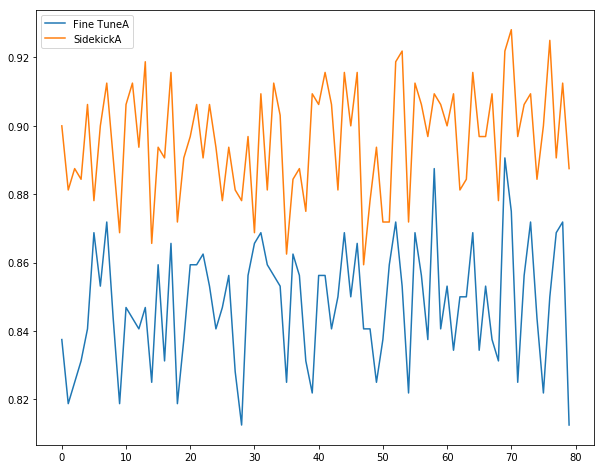

In [33]:
df[["Fine TuneA","SidekickA"]].plot(figsize=(10,8))

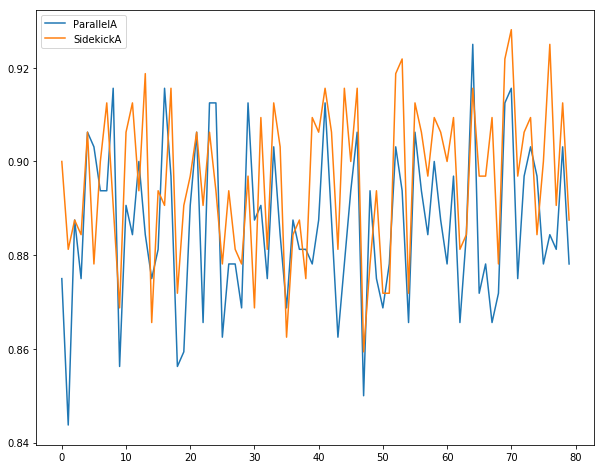

In [34]:
df[["ParallelA","SidekickA"]].plot(figsize=(10,8))

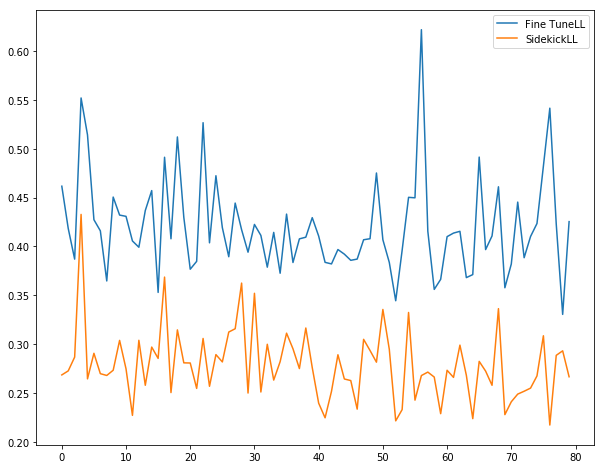

In [35]:
df[["Fine TuneLL","SidekickLL"]].plot(figsize=(10,8))

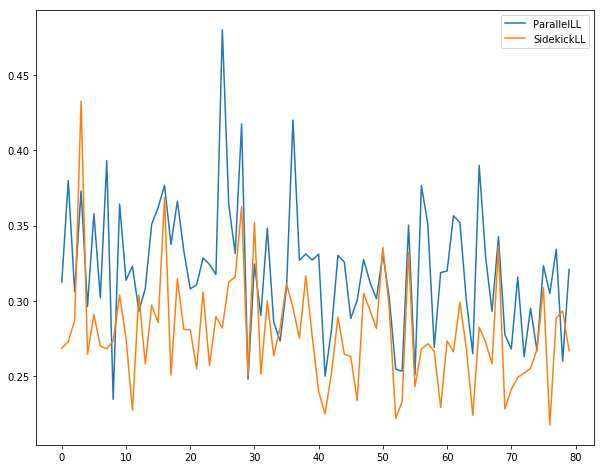

In [37]:
df[["ParallelLL","SidekickLL"]].plot(figsize=(10,8))

In [23]:
data = getData()
def testWidth(width=1):
    out = [width]  
    learnSK = Learner(data,SidekickAlexNet(data.train_ds.c,width=width),metrics=[accuracy,logloss])
    learnSK.split([learnSK.model.hero,learnSK.model.features[0],learnSK.model.classifier])
    learnSK.freeze_to(1)
    learnSK.fit_one_cycle(20,1e-3)
    learnSK.fit_one_cycle(10,1e-4)
    out.append(max([m[0].item() for m in learnSK.recorder.metrics]))
    out.append(max([m[1].item() for m in learnSK.recorder.metrics]))
    
    return out

In [24]:
widthRes = [testWidth(w) for w in progress_bar(range(1,17))]

epoch,train_loss,valid_loss,accuracy,logloss
1,0.589997,0.481696,0.793750,0.481696
2,0.496180,0.388698,0.812500,0.388698
3,0.421430,0.362561,0.825000,0.362561
4,0.385973,0.332476,0.853125,0.332476
5,0.364337,0.334109,0.837500,0.334109
6,0.363469,0.311746,0.846875,0.311746
7,0.351873,0.389805,0.806250,0.389805
8,0.361444,0.358989,0.809375,0.358989
9,0.364850,0.302951,0.865625,0.302951
10,0.360678,0.286756,0.887500,0.286756


epoch,train_loss,valid_loss,accuracy,logloss
1,0.263750,0.237820,0.896875,0.237820
2,0.289258,0.247854,0.896875,0.247854
3,0.266269,0.249385,0.893750,0.249385
4,0.267495,0.237476,0.896875,0.237476
5,0.272357,0.239861,0.900000,0.239861
6,0.281556,0.241797,0.903125,0.241797
7,0.250056,0.233922,0.903125,0.233922
8,0.243012,0.251233,0.887500,0.251233
9,0.263564,0.232722,0.903125,0.232722
10,0.264635,0.234134,0.903125,0.234134


epoch,train_loss,valid_loss,accuracy,logloss
1,0.557648,0.470233,0.800000,0.470233
2,0.457272,0.356720,0.837500,0.356720
3,0.396370,0.494037,0.775000,0.494037
4,0.375081,0.327069,0.834375,0.327069
5,0.368907,0.299879,0.850000,0.299879
6,0.349848,0.303350,0.865625,0.303350
7,0.360686,0.383769,0.784375,0.383769
8,0.345222,0.321486,0.850000,0.321486
9,0.350576,0.345210,0.856250,0.345210
10,0.351115,0.304386,0.853125,0.304386


epoch,train_loss,valid_loss,accuracy,logloss
1,0.281704,0.269901,0.875000,0.269901
2,0.262765,0.267739,0.887500,0.267739
3,0.257397,0.269196,0.890625,0.269196
4,0.260166,0.265935,0.884375,0.265935
5,0.289684,0.269533,0.871875,0.269533
6,0.265713,0.241059,0.903125,0.241059
7,0.282109,0.280141,0.868750,0.280141
8,0.282501,0.247104,0.890625,0.247104
9,0.259387,0.262099,0.884375,0.262099
10,0.271820,0.256892,0.884375,0.256892


epoch,train_loss,valid_loss,accuracy,logloss
1,0.558168,0.439607,0.800000,0.439607
2,0.438382,0.330302,0.840625,0.330302
3,0.407749,0.379554,0.806250,0.379554
4,0.406363,0.472806,0.775000,0.472806
5,0.383276,0.391032,0.818750,0.391032
6,0.388933,0.383313,0.828125,0.383313
7,0.370527,0.315979,0.859375,0.315979
8,0.388645,0.399793,0.815625,0.399793
9,0.361736,0.517865,0.778125,0.517865
10,0.371070,0.307704,0.850000,0.307704


epoch,train_loss,valid_loss,accuracy,logloss
1,0.263554,0.271713,0.878125,0.271713
2,0.275670,0.265200,0.878125,0.265200
3,0.270025,0.273764,0.878125,0.273764
4,0.283270,0.285444,0.865625,0.285444
5,0.283063,0.268486,0.875000,0.268486
6,0.270889,0.272542,0.868750,0.272542
7,0.283142,0.267190,0.871875,0.267190
8,0.282011,0.268706,0.868750,0.268706
9,0.278113,0.271175,0.871875,0.271175
10,0.290931,0.266451,0.875000,0.266451


epoch,train_loss,valid_loss,accuracy,logloss
1,0.549074,0.421544,0.821875,0.421544
2,0.428188,0.347407,0.846875,0.347407
3,0.384959,0.425164,0.781250,0.425164
4,0.377838,0.345416,0.821875,0.345416
5,0.361787,0.329996,0.846875,0.329996
6,0.368814,0.343119,0.828125,0.343119
7,0.344528,0.400802,0.815625,0.400802
8,0.369160,0.323379,0.840625,0.323379
9,0.370990,0.281631,0.881250,0.281631
10,0.367432,0.323064,0.850000,0.323064


epoch,train_loss,valid_loss,accuracy,logloss
1,0.281874,0.242822,0.903125,0.242822
2,0.271042,0.243861,0.896875,0.243861
3,0.269464,0.253395,0.890625,0.253395
4,0.274766,0.252366,0.903125,0.252366
5,0.273000,0.254843,0.906250,0.254843
6,0.264480,0.238312,0.906250,0.238312
7,0.259593,0.241919,0.896875,0.241919
8,0.260868,0.240449,0.896875,0.240449
9,0.246401,0.235721,0.909375,0.235721
10,0.252456,0.241477,0.893750,0.241477


epoch,train_loss,valid_loss,accuracy,logloss
1,0.534508,0.401209,0.806250,0.401209
2,0.431193,0.364802,0.818750,0.364802
3,0.394485,0.455405,0.815625,0.455405
4,0.388373,0.369919,0.787500,0.369919
5,0.384503,0.314561,0.850000,0.314561
6,0.382618,0.515346,0.715625,0.515346
7,0.379429,0.314393,0.850000,0.314393
8,0.345648,0.274518,0.871875,0.274518
9,0.353214,0.307603,0.859375,0.307603
10,0.330893,0.358618,0.815625,0.358618


epoch,train_loss,valid_loss,accuracy,logloss
1,0.270134,0.245401,0.906250,0.245401
2,0.269216,0.260168,0.893750,0.260168
3,0.288266,0.242212,0.909375,0.242212
4,0.269173,0.249262,0.896875,0.249262
5,0.254570,0.246648,0.887500,0.246648
6,0.275616,0.244918,0.903125,0.244918
7,0.251947,0.238935,0.900000,0.238935
8,0.269609,0.237042,0.893750,0.237042
9,0.284410,0.242929,0.890625,0.242929
10,0.267806,0.244461,0.893750,0.244461


epoch,train_loss,valid_loss,accuracy,logloss
1,0.503614,0.389656,0.818750,0.389656
2,0.423238,0.322714,0.862500,0.322714
3,0.391846,0.393356,0.818750,0.393356
4,0.415124,0.361071,0.825000,0.361071
5,0.400887,0.364450,0.828125,0.364450
6,0.393294,0.350015,0.834375,0.350015
7,0.359412,0.659712,0.665625,0.659712
8,0.351023,0.810469,0.600000,0.810469
9,0.367895,0.323979,0.828125,0.323979
10,0.350987,0.322410,0.834375,0.322410


epoch,train_loss,valid_loss,accuracy,logloss
1,0.249836,0.254132,0.884375,0.254132
2,0.268679,0.263276,0.887500,0.263276
3,0.265791,0.270126,0.878125,0.270126
4,0.269413,0.255216,0.884375,0.255216
5,0.265761,0.252151,0.890625,0.252151
6,0.268385,0.258396,0.884375,0.258396
7,0.253263,0.256515,0.878125,0.256515
8,0.266537,0.247429,0.893750,0.247429
9,0.264203,0.287210,0.893750,0.287210
10,0.255550,0.245047,0.893750,0.245047


epoch,train_loss,valid_loss,accuracy,logloss
1,0.503582,0.413171,0.784375,0.413171
2,0.432932,0.329812,0.853125,0.329812
3,0.402307,0.345711,0.843750,0.345711
4,0.387261,0.355321,0.821875,0.355321
5,0.391773,0.566889,0.728125,0.566889
6,0.393103,0.378910,0.821875,0.378910
7,0.367477,0.369730,0.809375,0.369730
8,0.330319,0.457129,0.806250,0.457129
9,0.340952,0.308650,0.862500,0.308650
10,0.348874,0.283408,0.871875,0.283408


epoch,train_loss,valid_loss,accuracy,logloss
1,0.272358,0.251989,0.884375,0.251989
2,0.260914,0.242317,0.896875,0.242317
3,0.277555,0.243883,0.900000,0.243883
4,0.251725,0.261282,0.884375,0.261282
5,0.249123,0.244521,0.900000,0.244521
6,0.269381,0.245618,0.896875,0.245618
7,0.263420,0.243515,0.893750,0.243515
8,0.270544,0.241096,0.903125,0.241096
9,0.260029,0.245000,0.906250,0.245000
10,0.258688,0.239784,0.900000,0.239784


epoch,train_loss,valid_loss,accuracy,logloss
1,0.497291,0.405610,0.787500,0.405610
2,0.397489,0.346006,0.825000,0.346006
3,0.409853,0.299555,0.853125,0.299555
4,0.409318,0.432880,0.796875,0.432880
5,0.391636,0.543680,0.781250,0.543680
6,0.364700,0.342898,0.834375,0.342898
7,0.360868,0.329219,0.840625,0.329219
8,0.326406,0.556951,0.775000,0.556951
9,0.323209,0.346156,0.837500,0.346156
10,0.322426,0.290622,0.878125,0.290622


epoch,train_loss,valid_loss,accuracy,logloss
1,0.269596,0.252432,0.887500,0.252432
2,0.264699,0.250806,0.875000,0.250806
3,0.253782,0.247153,0.893750,0.247153
4,0.256026,0.248247,0.887500,0.248247
5,0.261041,0.246013,0.875000,0.246013
6,0.258216,0.240944,0.890625,0.240944
7,0.251098,0.250357,0.884375,0.250357
8,0.266324,0.237559,0.903125,0.237559
9,0.241567,0.242833,0.884375,0.242833
10,0.267434,0.237141,0.900000,0.237141


epoch,train_loss,valid_loss,accuracy,logloss
1,0.481004,0.408730,0.778125,0.408730
2,0.423506,0.355626,0.818750,0.355626
3,0.393887,0.666500,0.775000,0.666500
4,0.380493,0.331189,0.843750,0.331189
5,0.418548,0.325235,0.846875,0.325235
6,0.386906,0.315687,0.865625,0.315687
7,0.382185,0.823167,0.587500,0.823167
8,0.352248,0.458963,0.768750,0.458963
9,0.378879,0.353773,0.834375,0.353773
10,0.348082,0.333861,0.834375,0.333861


epoch,train_loss,valid_loss,accuracy,logloss
1,0.276517,0.242232,0.887500,0.242232
2,0.276576,0.242843,0.881250,0.242843
3,0.259024,0.260781,0.875000,0.260781
4,0.268532,0.248962,0.890625,0.248962
5,0.267620,0.247840,0.890625,0.247840
6,0.257224,0.239553,0.893750,0.239553
7,0.250971,0.243141,0.884375,0.243141
8,0.250880,0.239066,0.893750,0.239066
9,0.236167,0.234857,0.903125,0.234857
10,0.252337,0.245871,0.884375,0.245871


epoch,train_loss,valid_loss,accuracy,logloss
1,0.464424,0.392490,0.803125,0.392490
2,0.403714,0.471802,0.746875,0.471802
3,0.397085,0.346120,0.825000,0.346120
4,0.378067,0.339055,0.834375,0.339055
5,0.401526,0.346653,0.853125,0.346653
6,0.381067,0.630310,0.746875,0.630310
7,0.410419,0.354270,0.828125,0.354270
8,0.407735,0.392226,0.831250,0.392226
9,0.382537,0.446954,0.793750,0.446954
10,0.354408,0.281114,0.865625,0.281114


epoch,train_loss,valid_loss,accuracy,logloss
1,0.296028,0.274911,0.865625,0.274911
2,0.269001,0.269851,0.865625,0.269851
3,0.313019,0.266844,0.875000,0.266844
4,0.272113,0.265695,0.865625,0.265695
5,0.269085,0.276058,0.871875,0.276058
6,0.290945,0.301646,0.856250,0.301646
7,0.278617,0.277238,0.875000,0.277238
8,0.265298,0.276173,0.881250,0.276173
9,0.279532,0.276256,0.875000,0.276256
10,0.266070,0.273242,0.881250,0.273242


epoch,train_loss,valid_loss,accuracy,logloss
1,0.471998,0.373625,0.815625,0.373625
2,0.415539,0.442382,0.781250,0.442382
3,0.425823,0.563821,0.690625,0.563821
4,0.393819,0.421997,0.759375,0.421997
5,0.385138,0.348877,0.853125,0.348877
6,0.393601,0.833356,0.712500,0.833356
7,0.372405,0.319715,0.865625,0.319715
8,0.347839,0.433577,0.806250,0.433577
9,0.332315,0.299756,0.875000,0.299756
10,0.357317,0.323023,0.846875,0.323022


epoch,train_loss,valid_loss,accuracy,logloss
1,0.280354,0.255549,0.887500,0.255549
2,0.289294,0.259633,0.881250,0.259633
3,0.284105,0.260463,0.893750,0.260463
4,0.278302,0.257827,0.881250,0.257827
5,0.258407,0.257920,0.881250,0.257920
6,0.274256,0.279417,0.890625,0.279417
7,0.274730,0.283228,0.878125,0.283228
8,0.267296,0.290037,0.875000,0.290037
9,0.266702,0.266529,0.881250,0.266529
10,0.260753,0.271849,0.881250,0.271849


epoch,train_loss,valid_loss,accuracy,logloss
1,0.451817,0.367636,0.803125,0.367636
2,0.402656,0.322758,0.865625,0.322758
3,0.407953,0.843693,0.596875,0.843693
4,0.402033,0.401923,0.831250,0.401923
5,0.382587,0.385860,0.771875,0.385860
6,0.407182,0.724169,0.628125,0.724169
7,0.390608,0.460824,0.750000,0.460824
8,0.346058,0.539882,0.796875,0.539882
9,0.346001,0.304283,0.859375,0.304283
10,0.361518,0.710201,0.643750,0.710201


epoch,train_loss,valid_loss,accuracy,logloss
1,0.275932,0.246667,0.881250,0.246667
2,0.275036,0.248701,0.887500,0.248701
3,0.292487,0.250844,0.887500,0.250844
4,0.288120,0.259352,0.878125,0.259352
5,0.266207,0.271609,0.871875,0.271609
6,0.285459,0.251652,0.884375,0.251652
7,0.254217,0.256426,0.884375,0.256426
8,0.252269,0.256211,0.900000,0.256211
9,0.265413,0.257589,0.881250,0.257589
10,0.251203,0.251120,0.890625,0.251120


epoch,train_loss,valid_loss,accuracy,logloss
1,0.449793,0.393585,0.809375,0.393585
2,0.411721,0.712288,0.612500,0.712288
3,0.391194,0.406182,0.793750,0.406182
4,0.401269,0.391233,0.803125,0.391233
5,0.406787,0.330617,0.837500,0.330617
6,0.366728,1.291038,0.553125,1.291038
7,0.382861,0.300142,0.875000,0.300142
8,0.357974,0.348321,0.834375,0.348321
9,0.350507,0.324933,0.834375,0.324933
10,0.332913,0.422020,0.765625,0.422020


epoch,train_loss,valid_loss,accuracy,logloss
1,0.281269,0.339546,0.875000,0.339546
2,0.272146,0.323589,0.881250,0.323589
3,0.262917,0.258367,0.878125,0.258367
4,0.267887,0.274662,0.878125,0.274662
5,0.287830,0.257872,0.881250,0.257872
6,0.272135,0.274433,0.875000,0.274433
7,0.269659,0.263130,0.887500,0.263130
8,0.263164,0.259283,0.884375,0.259283
9,0.273249,0.270126,0.887500,0.270126
10,0.260538,0.252427,0.893750,0.252427


epoch,train_loss,valid_loss,accuracy,logloss
1,0.463478,0.447048,0.759375,0.447048
2,0.394367,1.021182,0.590625,1.021182
3,0.392274,0.390811,0.818750,0.390811
4,0.369563,1.488629,0.571875,1.488629
5,0.391272,0.434373,0.800000,0.434373
6,0.365005,0.381823,0.828125,0.381823
7,0.376740,0.395653,0.815625,0.395653
8,0.370280,0.831362,0.625000,0.831362
9,0.371019,2.232951,0.481250,2.232951
10,0.371384,0.859039,0.643750,0.859039


epoch,train_loss,valid_loss,accuracy,logloss
1,0.278612,0.260099,0.884375,0.260099
2,0.284894,0.258107,0.893750,0.258107
3,0.290450,0.288787,0.878125,0.288787
4,0.276711,0.261252,0.871875,0.261252
5,0.279298,0.251438,0.893750,0.251438
6,0.266246,0.242735,0.887500,0.242735
7,0.243999,0.249907,0.881250,0.249907
8,0.285573,0.244024,0.884375,0.244024
9,0.269727,0.248507,0.884375,0.248507
10,0.263508,0.246333,0.893750,0.246333


epoch,train_loss,valid_loss,accuracy,logloss
1,0.456161,0.357497,0.821875,0.357497
2,0.418878,0.431139,0.775000,0.431139
3,0.414171,0.732807,0.728125,0.732807
4,0.406927,0.462455,0.803125,0.462455
5,0.399662,0.863346,0.612500,0.863346
6,0.388512,0.872914,0.659375,0.872914
7,0.388817,0.290827,0.868750,0.290827
8,0.370375,0.481930,0.746875,0.481930
9,0.360676,0.329343,0.843750,0.329343
10,0.369576,0.355466,0.806250,0.355466


epoch,train_loss,valid_loss,accuracy,logloss
1,0.273564,0.263884,0.887500,0.263884
2,0.268006,0.254742,0.884375,0.254742
3,0.285190,0.266054,0.887500,0.266054
4,0.265327,0.250570,0.893750,0.250570
5,0.290725,0.249527,0.890625,0.249527
6,0.251510,0.248366,0.881250,0.248366
7,0.254178,0.244697,0.890625,0.244697
8,0.266087,0.247682,0.887500,0.247682
9,0.282325,0.247897,0.884375,0.247897
10,0.256677,0.246351,0.884375,0.246351


epoch,train_loss,valid_loss,accuracy,logloss
1,0.473603,0.364587,0.806250,0.364587
2,0.389107,0.569521,0.718750,0.569521
3,0.383641,0.326230,0.850000,0.326230
4,0.387997,0.557160,0.756250,0.557160
5,0.397098,0.372935,0.843750,0.372935
6,0.382963,0.330232,0.837500,0.330232
7,0.381749,0.470432,0.796875,0.470432
8,0.375042,0.298424,0.871875,0.298424
9,0.361431,0.740091,0.593750,0.740091
10,0.365858,0.377001,0.803125,0.377001


epoch,train_loss,valid_loss,accuracy,logloss
1,0.282485,0.266716,0.887500,0.266716
2,0.271469,0.267444,0.878125,0.267444
3,0.281164,0.282696,0.884375,0.282696
4,0.273960,0.268781,0.868750,0.268781
5,0.280630,0.254313,0.893750,0.254313
6,0.247053,0.245918,0.890625,0.245918
7,0.267500,0.252703,0.893750,0.252703
8,0.281744,0.255802,0.887500,0.255802
9,0.271021,0.247226,0.884375,0.247226
10,0.282220,0.259143,0.881250,0.259143


In [25]:
widthDF = pd.DataFrame(widthRes,columns=["width","acc","ll"])

In [26]:
widthDF

,width,acc,ll
0,1,0.903125,0.251233
1,2,0.903125,0.280141
2,3,0.878125,0.285444
3,4,0.909375,0.254843
4,5,0.909375,0.260168
5,6,0.893750,0.287210
6,7,0.906250,0.261282
7,8,0.903125,0.252432
8,9,0.903125,0.260781
9,10,0.881250,0.301646


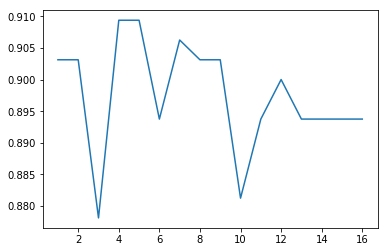

In [27]:
plt.plot(widthDF.width,widthDF.acc)